# Train & Test model to determine when seg2_rf > seg2_glm and agg_rf > seg2_glm


In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
install.packages("ggforce")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(rpart)
library(rpart.plot)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)

# for viz
library(ggforce)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_05_moredata"

In [4]:

# source('../orig/functions.R')

# source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')

# source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

In [5]:
compare_df_all <- read.csv("../../data/reseller_compare_formodel.csv")[-1]

In [6]:
head(compare_df_all)

,reseller,seg2_glm_lift10,seg2_glm_auc,seg_glm_lift10,seg_glm_auc,seg_rf_lift10,seg_rf_auc,count,ren_prp,tld_rat,reseller_country_maj,region_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,⋯,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt,agg_glm_lift10,agg_glm_auc,agg_rf_lift10,agg_rf_auc,seg2_rf_lift10,seg2_rf_auc,l10_win_seg2seg2,auc_win_seg2seg2,l10_win_aggseg2,auc_win_aggseg2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1,1&1 internet,1.0816327,0.5471429,1.1530612,0.5470408,1.2857143,0.5513265,9340,0.4430407,0.0009635974,Germany,Non China,1,99,43.686296,98,26.5590656,0.09861704,-0.8022303,3,46,12.010385,43,5.266594,1.0436144,⋯,270.62571,1,28,1.371949,27,1.7337454,11.855277,168.795878,1e-04,65.0,4.094250,64.9999,6.381621,2.727326086,13.1896630,1.387755,0.5533673,1.3571429,0.5438776,1.1632653,0.5462245,TRUE,FALSE,TRUE,FALSE
2,101 domain,1.0526316,0.5552632,0.5263158,0.5500000,0.5263158,0.4447368,80,0.6875000,0.1000000000,United States,Non China,1,5,1.625000,4,1.0717902,1.99309800,3.4254456,3,26,9.025000,23,4.018864,1.4285805,⋯,64.58484,1,3,1.275000,2,0.5271130,1.726399,2.073281,6e+00,40.0,25.006250,34.0000,9.287426,-0.002951292,-0.9244696,1.578947,0.5500000,1.5789474,0.6184211,0.5263158,0.5184211,FALSE,FALSE,TRUE,TRUE
3,10dencehispahard,1.9354839,0.6661290,2.5806452,0.7177419,1.2903226,0.5758065,590,0.1898305,0.0118644068,Spain,Non China,1,27,4.935593,26,6.2868003,2.34542064,4.9154734,3,39,10.791525,36,4.464034,1.5335674,⋯,345.80532,1,4,1.186441,3,0.5236212,3.303867,11.855982,1e+00,20.5,2.779661,19.5000,1.805649,5.682930743,49.0073588,2.580645,0.6370968,1.6129032,0.6629032,NA,NA,NA,NA,FALSE,FALSE
4,123hjemmeside,1.7647059,0.5264706,1.1764706,0.5147059,1.7647059,0.5147059,305,0.1639344,0.0163934426,Denmark,Non China,1,6,1.544262,5,0.8952588,2.66390630,9.7240176,4,28,11.026230,24,4.486013,1.0736463,⋯,1.75536,1,1,1.000000,0,0.0000000,NA,NA,2e+00,8.0,7.960656,6.0000,0.485066,-12.167204287,146.5212900,0.000000,0.4382353,1.1764706,0.4558824,1.1764706,0.5617647,FALSE,TRUE,FALSE,FALSE
5,1api,0.6976744,0.5058140,0.6976744,0.5569767,0.9302326,0.4500000,368,0.4918478,0.0244565217,Germany,Non China,1,64,12.766304,63,23.5705158,1.70355779,0.9212875,3,29,9.880435,26,4.216465,1.1307433,⋯,101.43079,1,5,1.472826,4,0.9592917,2.394980,5.397796,1e+00,21.5,8.543750,20.5000,4.245763,-0.648167848,-0.6684833,1.590909,0.5522727,0.9090909,0.5863636,0.9302326,0.5476744,TRUE,TRUE,TRUE,TRUE
6,1blu,3.3333333,0.5500000,3.3333333,0.5500000,3.3333333,0.5500000,4,0.7500000,1.0000000000,Germany,Non China,1,1,1.000000,0,0.0000000,NA,NA,8,23,12.750000,15,6.946222,0.6800021,⋯,-2.31454,1,1,1.000000,0,0.0000000,NA,NA,1e+01,10.0,10.000000,0.0000,0.000000,NA,NA,3.333333,0.5500000,3.3333333,0.5500000,NA,NA,NA,NA,FALSE,FALSE


## Proportion of wins by RF over GLM
interestingly, agg rf does better than seg2 rf

In [7]:
compare_df_all %>% 
    summarize(l10_win_seg2seg2_prop = sum(l10_win_seg2seg2, na.rm=TRUE)/length(which(!is.na(l10_win_seg2seg2))),
              auc_win_seg2seg2_prop = sum(auc_win_seg2seg2, na.rm=TRUE)/length(which(!is.na(auc_win_seg2seg2))),
              l10_win_aggseg2_prop = sum(l10_win_aggseg2, na.rm=TRUE)/length(which(!is.na(l10_win_aggseg2))),
              auc_win_aggseg2_prop = sum(auc_win_aggseg2, na.rm=TRUE)/length(which(!is.na(auc_win_aggseg2))))

l10_win_seg2seg2_prop,auc_win_seg2seg2_prop,l10_win_aggseg2_prop,auc_win_aggseg2_prop
<dbl>,<dbl>,<dbl>,<dbl>
0.3508772,0.4408602,0.3648649,0.5082645


## EDA

In [8]:
names(compare_df_all)

[1] "reseller"             "seg2_glm_lift10"      "seg2_glm_auc"        
 [4] "seg_glm_lift10"       "seg_glm_auc"          "seg_rf_lift10"       
 [7] "seg_rf_auc"           "count"                "ren_prp"             
[10] "tld_rat"              "reseller_country_maj" "region_maj"          
[13] "daydom_min"           "daydom_max"           "daydom_mean"         
[16] "daydom_rng"           "daydom_std"           "daydom_skew"         
[19] "daydom_kurt"          "sldlen_min"           "sldlen_max"          
[22] "sldlen_mean"          "sldlen_rng"           "sldlen_std"          
[25] "sldlen_skew"          "sldlen_kurt"          "gibbs_min"           
[28] "gibbs_max"            "gibbs_mean"           "gibbs_rng"           
[31] "gibbs_std"            "gibbs_skew"           "gibbs_kurt"          
[34] "pdcnt_min"            "pdcnt_max"            "pdcnt_mean"          
[37] "pdcnt_rng"            "pdcnt_std"            "pdcnt_skew"          
[40] "pdcnt_kurt"           "rarpt_min"            "rarpt_max"           
[43] "rarpt_mean"           "rarpt_rng"            "rarpt_std"           
[46] "rarpt_skew"           "rarpt_kurt"           "agg_glm_lift10"      
[49] "agg_glm_auc"          "agg_rf_lift10"        "agg_rf_auc"          
[52] "seg2_rf_lift10"       "seg2_rf_auc"          "l10_win_seg2seg2"    
[55] "auc_win_seg2seg2"     "l10_win_aggseg2"      "auc_win_aggseg2"

In [9]:
compare_df_sub <- compare_df_all %>% 
    select('count','ren_prp','tld_rat',
           'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
           'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
           'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
           'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
           'rarpt_min','rarpt_max','rarpt_mean','rarpt_rng','rarpt_std','rarpt_skew','rarpt_kurt')

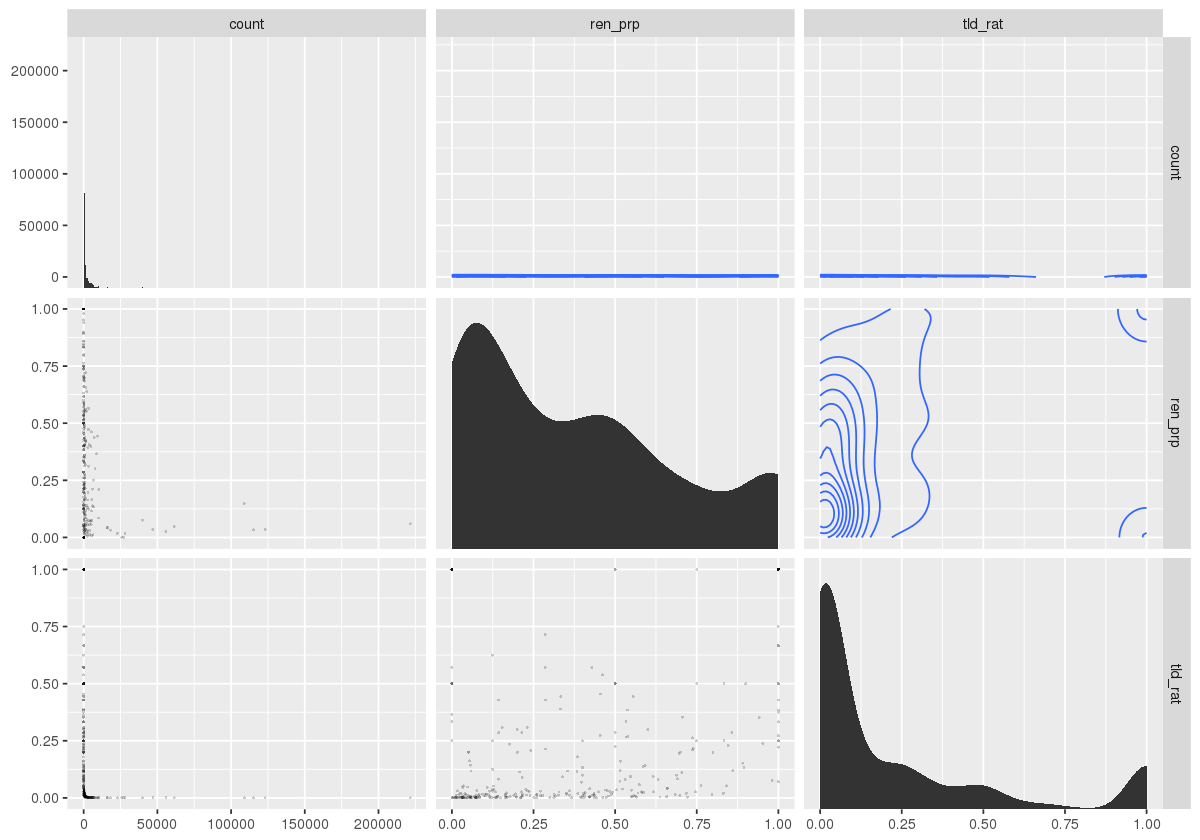

In [10]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(compare_df_sub[1:3], aes(x = .panel_x, y = .panel_y)) + 
  geom_point(alpha = 0.2, shape = 16, size = 0.5) + 
  geom_autodensity() +
  geom_density2d() +
  facet_matrix(vars(everything()), layer.diag = 2, layer.upper = 3, 
               grid.y.diag = FALSE)

Warning message:
“Removed 159 rows containing non-finite values (stat_autodensity).”
Warning message:
“Removed 831 rows containing non-finite values (stat_density2d).”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”
Warning message:
“Removed 1536 rows containing missing values (position_stack).”
Warning message:
“Removed 831 rows containing missing values (geom_point).”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning 

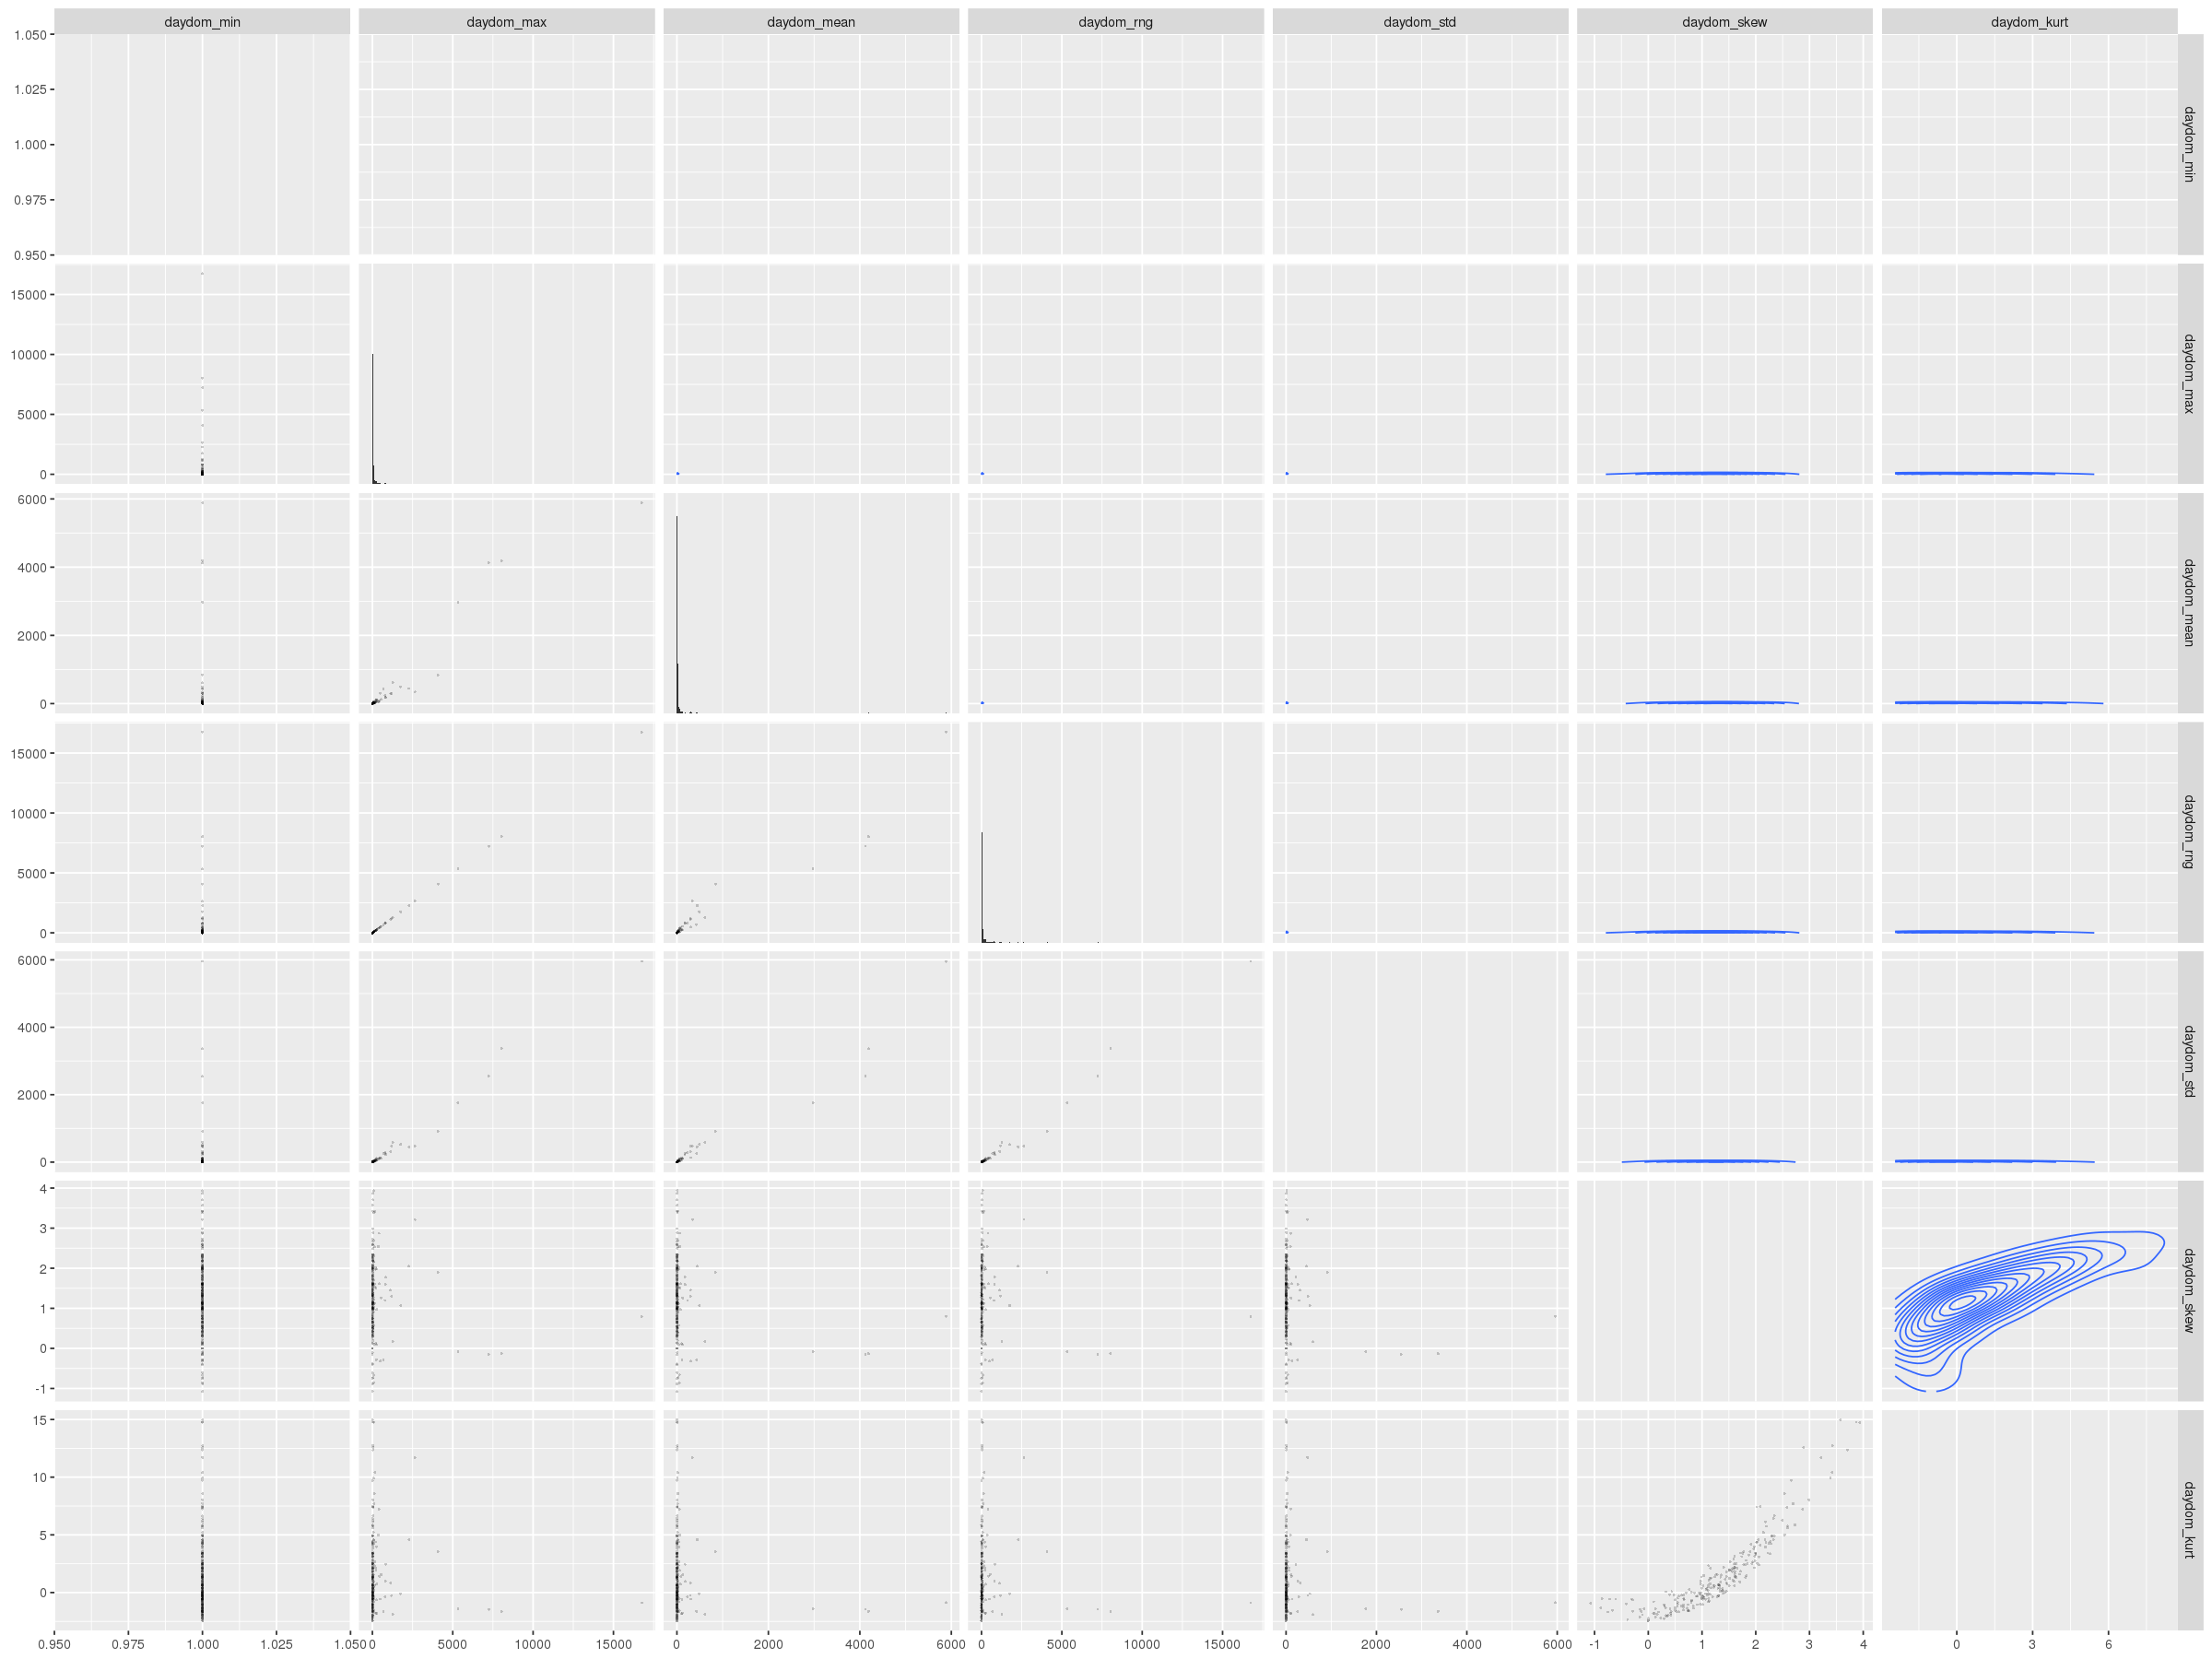

In [11]:
options(repr.plot.width=20, repr.plot.height=15)
ggplot(compare_df_sub[4:10], aes(x = .panel_x, y = .panel_y)) + 
  geom_point(alpha = 0.2, shape = 16, size = 0.5) + 
  geom_autodensity() +
  geom_density2d() +
  facet_matrix(vars(everything()), layer.diag = 2, layer.upper = 3, 
               grid.y.diag = FALSE)

## Data Prep

In [12]:
compare_df_all_f <- compare_df_all %>%
  mutate_if(sapply(compare_df_all, is.character), as.factor)

In [13]:
str(compare_df_all_f)

'data.frame':	309 obs. of  57 variables:
 $ reseller            : Factor w/ 309 levels "1&1 internet",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ seg2_glm_lift10     : num  1.082 1.053 1.935 1.765 0.698 ...
 $ seg2_glm_auc        : num  0.547 0.555 0.666 0.526 0.506 ...
 $ seg_glm_lift10      : num  1.153 0.526 2.581 1.176 0.698 ...
 $ seg_glm_auc         : num  0.547 0.55 0.718 0.515 0.557 ...
 $ seg_rf_lift10       : num  1.286 0.526 1.29 1.765 0.93 ...
 $ seg_rf_auc          : num  0.551 0.445 0.576 0.515 0.45 ...
 $ count               : int  9340 80 590 305 368 4 4 224 39 26 ...
 $ ren_prp             : num  0.443 0.688 0.19 0.164 0.492 ...
 $ tld_rat             : num  0.000964 0.1 0.011864 0.016393 0.024457 ...
 $ reseller_country_maj: Factor w/ 55 levels "","Argentina",..: 18 53 46 15 18 18 35 12 53 53 ...
 $ region_maj          : Factor w/ 2 levels "China","Non China": 2 2 2 2 2 2 2 1 2 2 ...
 $ daydom_min          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max          : int  99 5 27 6 64 

In [14]:
compare_df_all_f %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t()

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


reseller,0
seg2_glm_lift10,67
seg2_glm_auc,67
seg_glm_lift10,67
seg_glm_auc,67
seg_rf_lift10,67
seg_rf_auc,67
count,0
ren_prp,0
tld_rat,0
reseller_country_maj,0


### Add-in *_win_glm_aggseg2 (agg_glm > seg2_glm)

In [27]:
compare_df_all_f = compare_df_all %>% 
    mutate( l10_win_glm_aggseg2 = (agg_glm_lift10/seg2_glm_lift10)>1,
            auc_win_glm_aggseg2 = (agg_glm_auc/seg2_glm_auc)>1,
           
            l10_win_glmagg_glmseg2_rfagg = l10_win_glm_aggseg2 * !l10_win_aggseg2 ,
            auc_win_glmagg_glmseg2_rfagg = auc_win_glm_aggseg2 * !auc_win_aggseg2,
          )

In [30]:
names(compare_df_all_f)

[1] "reseller"                     "seg2_glm_lift10"             
 [3] "seg2_glm_auc"                 "seg_glm_lift10"              
 [5] "seg_glm_auc"                  "seg_rf_lift10"               
 [7] "seg_rf_auc"                   "count"                       
 [9] "ren_prp"                      "tld_rat"                     
[11] "reseller_country_maj"         "region_maj"                  
[13] "daydom_min"                   "daydom_max"                  
[15] "daydom_mean"                  "daydom_rng"                  
[17] "daydom_std"                   "daydom_skew"                 
[19] "daydom_kurt"                  "sldlen_min"                  
[21] "sldlen_max"                   "sldlen_mean"                 
[23] "sldlen_rng"                   "sldlen_std"                  
[25] "sldlen_skew"                  "sldlen_kurt"                 
[27] "gibbs_min"                    "gibbs_max"                   
[29] "gibbs_mean"                   "gibbs_rng"                   
[31] "gibbs_std"                    "gibbs_skew"                  
[33] "gibbs_kurt"                   "pdcnt_min"                   
[35] "pdcnt_max"                    "pdcnt_mean"                  
[37] "pdcnt_rng"                    "pdcnt_std"                   
[39] "pdcnt_skew"                   "pdcnt_kurt"                  
[41] "rarpt_min"                    "rarpt_max"                   
[43] "rarpt_mean"                   "rarpt_rng"                   
[45] "rarpt_std"                    "rarpt_skew"                  
[47] "rarpt_kurt"                   "agg_glm_lift10"              
[49] "agg_glm_auc"                  "agg_rf_lift10"               
[51] "agg_rf_auc"                   "seg2_rf_lift10"              
[53] "seg2_rf_auc"                  "l10_win_seg2seg2"            
[55] "auc_win_seg2seg2"             "l10_win_aggseg2"             
[57] "auc_win_aggseg2"              "l10_win_glm_aggseg2"         
[59] "auc_win_glm_aggseg2"          "l10_win_glmagg_glmseg2_rfagg"
[61] "auc_win_glmagg_glmseg2_rfagg"

In [28]:
compare_df_all_f %>% 
    summarize(l10_win_seg2seg2_prop = sum(l10_win_seg2seg2, na.rm=TRUE)/length(which(!is.na(l10_win_seg2seg2))),
              auc_win_seg2seg2_prop = sum(auc_win_seg2seg2, na.rm=TRUE)/length(which(!is.na(auc_win_seg2seg2))),
              l10_win_aggseg2_prop = sum(l10_win_aggseg2, na.rm=TRUE)/length(which(!is.na(l10_win_aggseg2))),
              auc_win_aggseg2_prop = sum(auc_win_aggseg2, na.rm=TRUE)/length(which(!is.na(auc_win_aggseg2))),
              
              l10_win_glm_aggseg2_prop = sum(l10_win_glm_aggseg2, na.rm=TRUE)/length(which(!is.na(l10_win_glm_aggseg2))),
              auc_win_glm_aggseg2_prop = sum(auc_win_glm_aggseg2, na.rm=TRUE)/length(which(!is.na(auc_win_glm_aggseg2))),
              l10_win_glmagg_glmseg2_rfagg_prop = sum(l10_win_glmagg_glmseg2_rfagg, na.rm=TRUE)/length(which(!is.na(l10_win_glmagg_glmseg2_rfagg))),
              auc_win_glmagg_glmseg2_rfagg_prop = sum(auc_win_glmagg_glmseg2_rfagg, na.rm=TRUE)/length(which(!is.na(auc_win_glmagg_glmseg2_rfagg)))) %>% t()

l10_win_seg2seg2_prop,0.35087719
auc_win_seg2seg2_prop,0.44086022
l10_win_aggseg2_prop,0.36486486
auc_win_aggseg2_prop,0.50826446
l10_win_glm_aggseg2_prop,0.30530973
auc_win_glm_aggseg2_prop,0.36363636
l10_win_glmagg_glmseg2_rfagg_prop,0.10045662
auc_win_glmagg_glmseg2_rfagg_prop,0.08264463


## Train/Test Split

In [31]:
compare_df_all_f_sub = compare_df_all_f %>% 
  select('auc_win_aggseg2','l10_win_aggseg2','auc_win_seg2seg2','l10_win_seg2seg2',
         'l10_win_glm_aggseg2','auc_win_glm_aggseg2','l10_win_glmagg_glmseg2_rfagg','auc_win_glmagg_glmseg2_rfagg',
         'count','ren_prp','tld_rat','reseller_country_maj','region_maj',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'rarpt_min','rarpt_max','rarpt_mean','rarpt_rng','rarpt_std','rarpt_skew','rarpt_kurt')
head(compare_df_all_f_sub)

,auc_win_aggseg2,l10_win_aggseg2,auc_win_seg2seg2,l10_win_seg2seg2,l10_win_glm_aggseg2,auc_win_glm_aggseg2,l10_win_glmagg_glmseg2_rfagg,auc_win_glmagg_glmseg2_rfagg,count,ren_prp,tld_rat,reseller_country_maj,region_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,0,1,9340,0.4430407,0.0009635974,Germany,Non China,1,99,43.686296,98,26.5590656,0.09861704,-0.8022303,3,46,12.010385,43,5.266594,1.0436144,1.709098,0.01,100.00,5.198351,99.99,5.078021,14.69793406,270.62571,1,28,1.371949,27,1.7337454,11.855277,168.795878,1e-04,65.0,4.094250,64.9999,6.381621,2.727326086,13.1896630
2,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,0,0,80,0.6875000,0.1000000000,United States,Non China,1,5,1.625000,4,1.0717902,1.99309800,3.4254456,3,26,9.025000,23,4.018864,1.4285805,3.550621,0.15,100.00,5.839000,99.85,10.981285,7.86590051,64.58484,1,3,1.275000,2,0.5271130,1.726399,2.073281,6e+00,40.0,25.006250,34.0000,9.287426,-0.002951292,-0.9244696
3,FALSE,FALSE,NA,NA,TRUE,FALSE,1,0,590,0.1898305,0.0118644068,Spain,Non China,1,27,4.935593,26,6.2868003,2.34542064,4.9154734,3,39,10.791525,36,4.464034,1.5335674,5.304185,0.13,100.00,5.512220,99.87,4.436891,16.40817676,345.80532,1,4,1.186441,3,0.5236212,3.303867,11.855982,1e+00,20.5,2.779661,19.5000,1.805649,5.682930743,49.0073588
4,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,0,0,305,0.1639344,0.0163934426,Denmark,Non China,1,6,1.544262,5,0.8952588,2.66390630,9.7240176,4,28,11.026230,24,4.486013,1.0736463,1.454026,0.19,17.12,5.307213,16.93,2.512423,0.87603903,1.75536,1,1,1.000000,0,0.0000000,NA,NA,2e+00,8.0,7.960656,6.0000,0.485066,-12.167204287,146.5212900
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,0,0,368,0.4918478,0.0244565217,Germany,Non China,1,64,12.766304,63,23.5705158,1.70355779,0.9212875,3,29,9.880435,26,4.216465,1.1307433,1.802688,0.01,100.00,5.558859,99.99,8.877448,9.80305841,101.43079,1,5,1.472826,4,0.9592917,2.394980,5.397796,1e+00,21.5,8.543750,20.5000,4.245763,-0.648167848,-0.6684833
6,FALSE,FALSE,NA,NA,FALSE,FALSE,0,0,4,0.7500000,1.0000000000,Germany,Non China,1,1,1.000000,0,0.0000000,NA,NA,8,23,12.750000,15,6.946222,0.6800021,-1.737756,3.48,5.72,4.505000,2.24,1.088286,0.08295079,-2.31454,1,1,1.000000,0,0.0000000,NA,NA,1e+01,10.0,10.000000,0.0000,0.000000,NA,NA


In [32]:
set.seed(123) 
smp_siz = floor(0.8*nrow(compare_df_all_f))
train_ind = sample(seq_len(nrow(compare_df_all_f)),size = smp_siz) 
train =compare_df_all_f_sub[train_ind,] 
test=compare_df_all_f_sub[-train_ind,]  

In [33]:
dim(train)

[1] 247  48

In [34]:
dim(test)

[1] 62 48

## Decision Tree

### auc_win_glmagg_glmseg2_rfagg

In [38]:
fit <- rpart(auc_win_glmagg_glmseg2_rfagg ~ .,
             method="class", 
             data=subset(train, select = -c(auc_win_aggseg2, l10_win_aggseg2,auc_win_seg2seg2,l10_win_seg2seg2,
                                            l10_win_glm_aggseg2,auc_win_glm_aggseg2,l10_win_glmagg_glmseg2_rfagg) ))

In [43]:
summary(fit)

Call:
rpart(formula = auc_win_glmagg_glmseg2_rfagg ~ ., data = subset(train, 
    select = -c(auc_win_aggseg2, l10_win_aggseg2, auc_win_seg2seg2, 
        l10_win_seg2seg2, l10_win_glm_aggseg2, auc_win_glm_aggseg2, 
        l10_win_glmagg_glmseg2_rfagg)), method = "class")
  n=198 (49 observations deleted due to missingness)

          CP nsplit rel error   xerror      xstd
1 0.08333333      0 1.0000000 1.000000 0.2247333
2 0.01000000      2 0.8333333 1.333333 0.2551380

Variable importance
reseller_country_maj          daydom_mean                count 
                  28                   13                   11 
          daydom_max           daydom_rng           daydom_std 
                  11                   11                   11 
             tld_rat            rarpt_max 
                  11                    2 

Node number 1: 198 observations,    complexity param=0.08333333
  predicted class=0  expected loss=0.09090909  P(node) =1
    class counts:   180    18
   probab

In [47]:
levels(train$reseller_country_maj)

[1] ""               "Argentina"      "Australia"      "Austria"       
 [5] "Bangladesh"     "Belarus"        "Belgium"        "Brazil"        
 [9] "Bulgaria"       "Canada"         "Cayman Islands" "China"         
[13] "Cyprus"         "Czech Republic" "Denmark"        "Finland"       
[17] "France"         "Germany"        "Gibraltor"      "Greece"        
[21] "Hong Kong"      "Hungary"        "India"          "Indonesia"     
[25] "Ireland"        "Israel"         "Italy"          "Japan"         
[29] "Korea"          "Lithuania"      "Luxembourg"     "Malaysia"      
[33] "Mexico"         "Netherlands"    "New Zealand"    "Nigeria"       
[37] "Norway"         "Others"         "Poland"         "Portugal"      
[41] "Russia"         "Singapore"      "Slovakia"       "South Africa"  
[45] "Southafrica"    "Spain"          "Sweden"         "Switzerland"   
[49] "Thailand"       "Turkey"         "Ukraine"        "United Kingdom"
[53] "United States"  "USA"            "Vietnam"

In [49]:
names(fit)

[1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"            
[16] "na.action"

In [58]:
fit

n=198 (49 observations deleted due to missingness)

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 198 18 0 (0.90909091 0.09090909)  
  2) reseller_country_maj=,Australia,Austria,Belgium,Bulgaria,Canada,Cayman Islands,China,Cyprus,Czech Republic,Denmark,France,Germany,India,Ireland,Israel,Japan,Korea,Lithuania,Luxembourg,Mexico,Netherlands,Nigeria,Poland,Slovakia,South Africa,Spain,Sweden,Switzerland,Ukraine,United Kingdom,United States,USA,Vietnam 174  8 0 (0.95402299 0.04597701) *
  3) reseller_country_maj=Brazil,Indonesia,Italy,Norway,Portugal,Russia,Singapore,Turkey 24 10 0 (0.58333333 0.41666667)  
    6) daydom_mean>=5.869879 9  1 0 (0.88888889 0.11111111) *
    7) daydom_mean< 5.869879 15  6 1 (0.40000000 0.60000000) *

Warning message in plot.window(...):
“"use.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"use.n" is not a graphical parameter”
Warning message in title(...):
“"use.n" is not a graphical parameter”


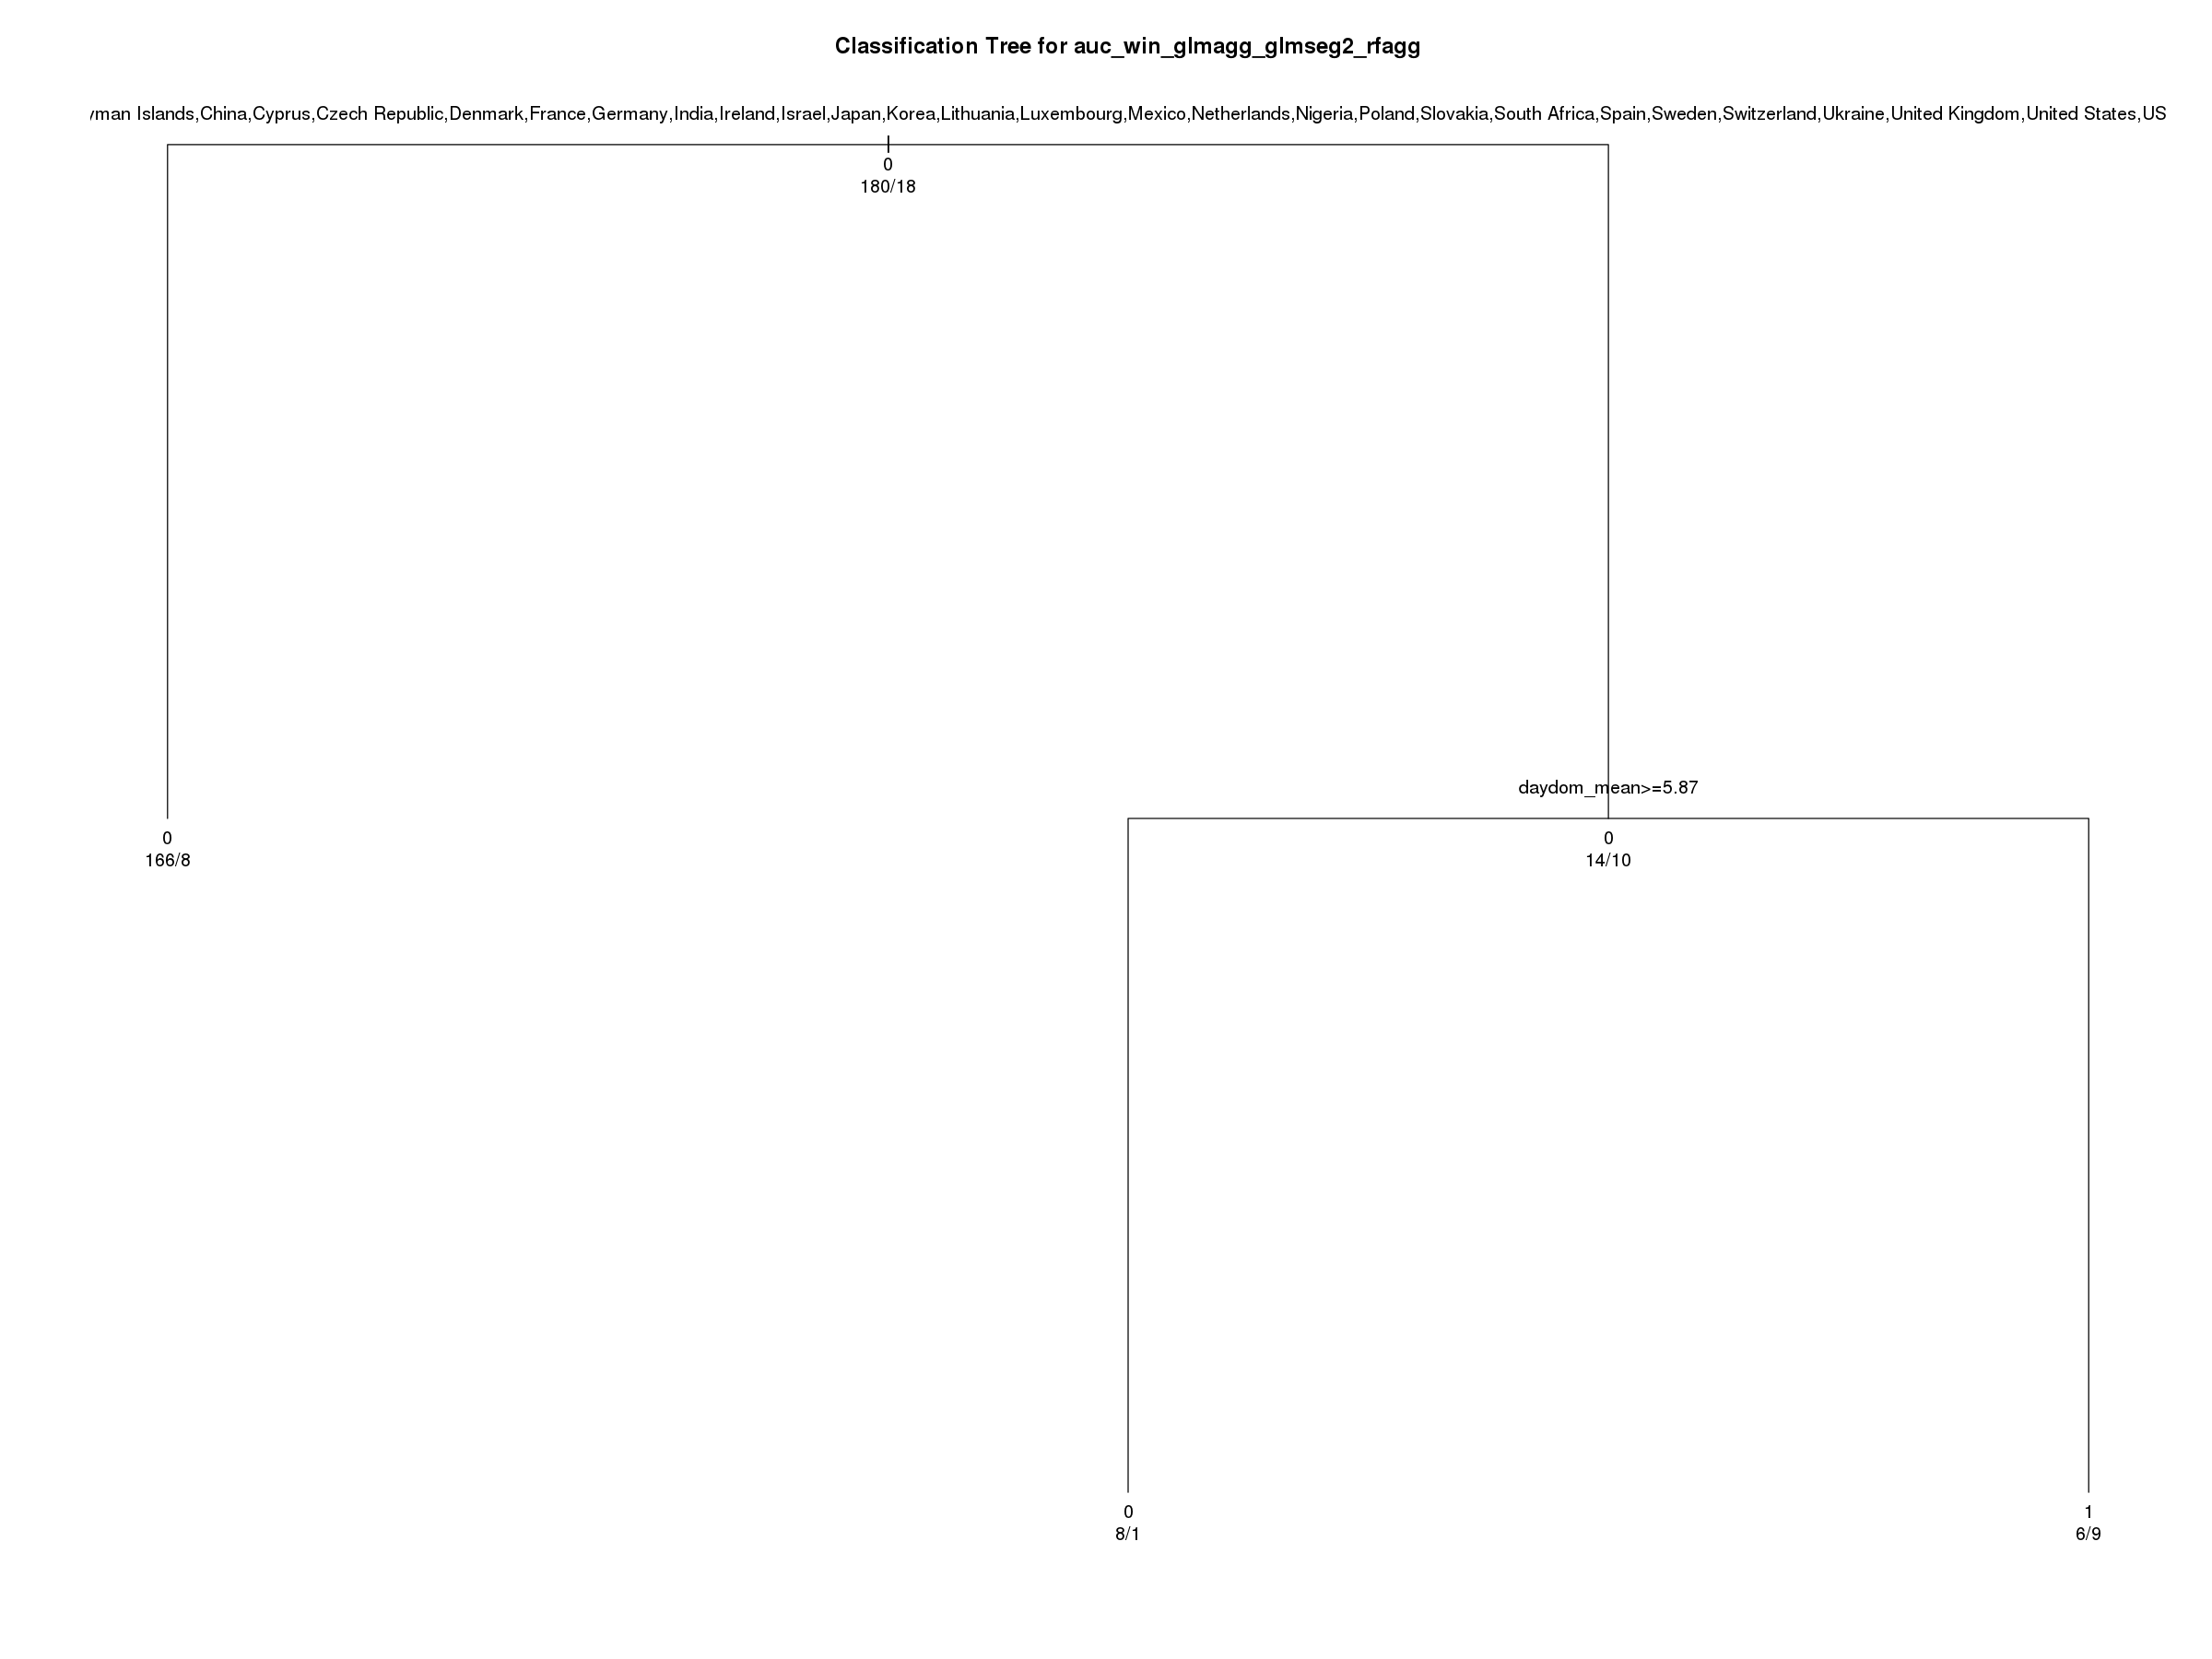

In [59]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for auc_win_glmagg_glmseg2_rfagg", use.n=TRUE)
text(fit, use.n=TRUE, all=TRUE, cex=1, pretty=1)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


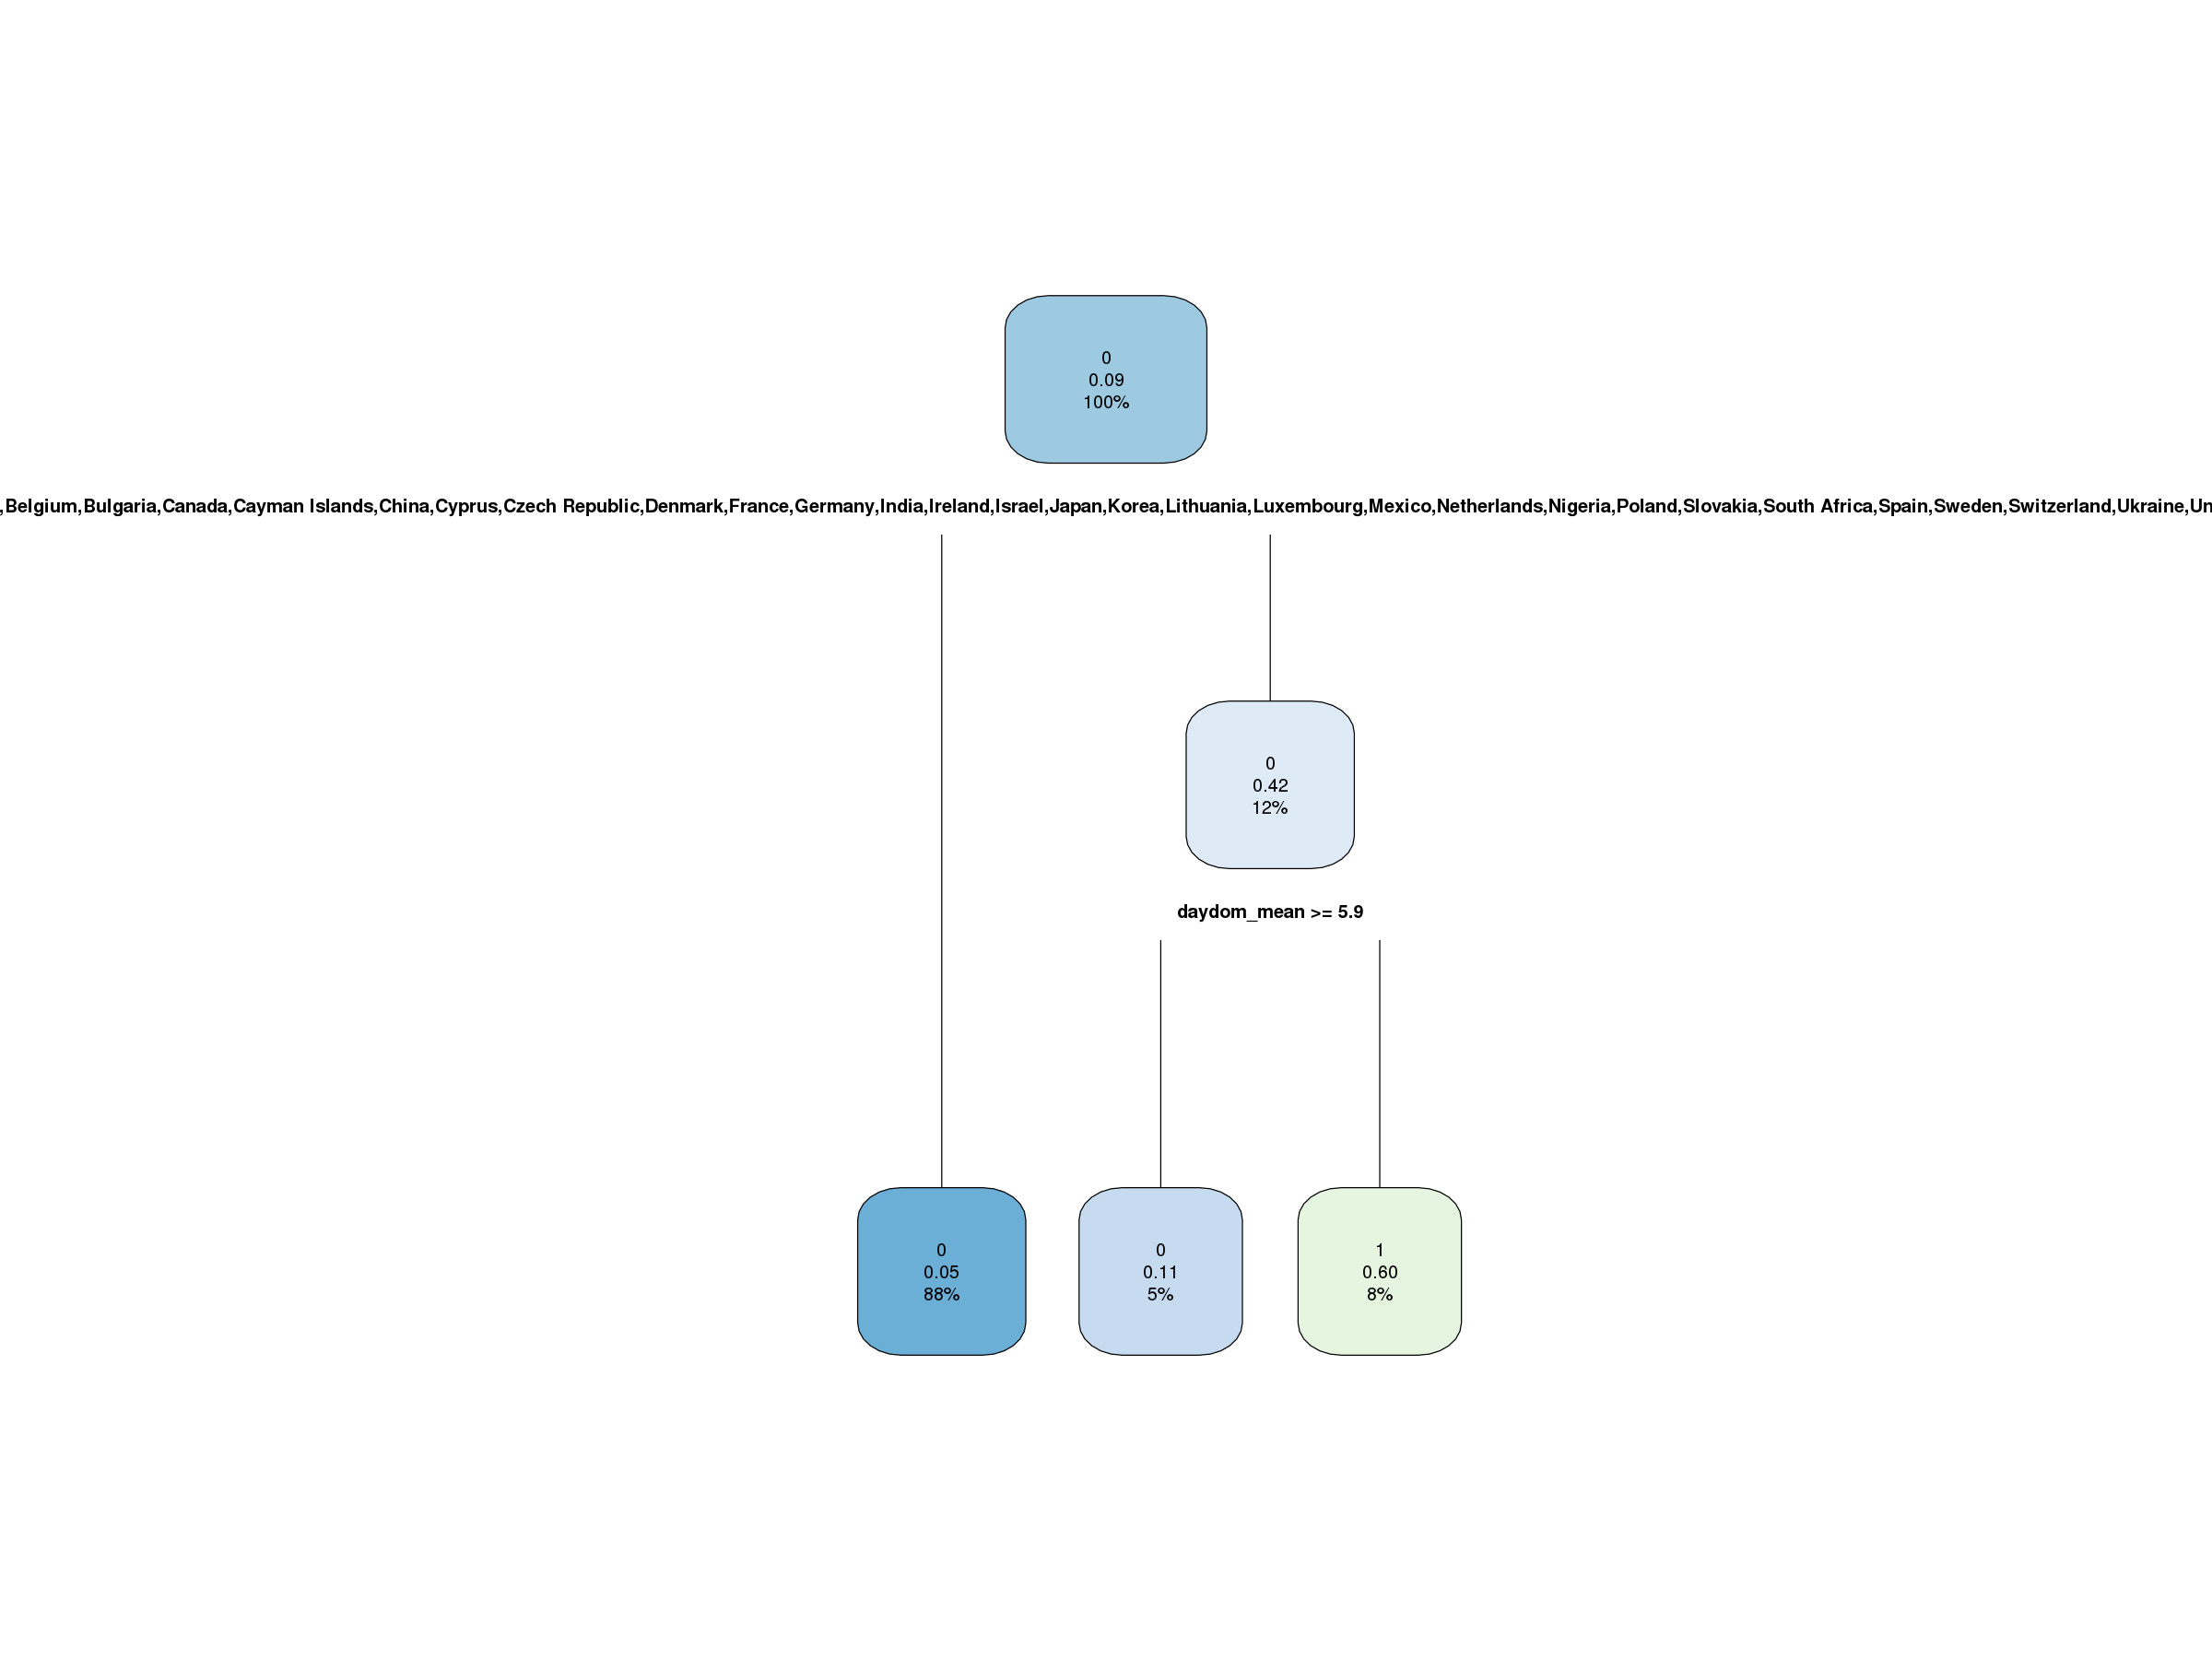

In [41]:
rpart.plot(pfit)

In [60]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree ")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

ERROR: Error in plot.rpart(pfit, uniform = TRUE, main = "Pruned Classification Tree for auc_win_aggseg2"): fit is not a tree, just a root


In [65]:
t = factor(predict(fit,test,type="class"))

In [66]:
p = factor(test[['auc_win_glmagg_glmseg2_rfagg']])

In [67]:
length(t)
length(p)

[1] 62

[1] 62

In [69]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_glmagg_glmseg2_rfagg']]),
                factor(predict(fit,test,type="class")), positive='1')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 39  3
         1  1  1
                                          
               Accuracy : 0.9091          
                 95% CI : (0.7833, 0.9747)
    No Information Rate : 0.9091          
    P-Value [Acc > NIR] : 0.6290          
                                          
                  Kappa : 0.2903          
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.25000         
            Specificity : 0.97500         
         Pos Pred Value : 0.50000         
         Neg Pred Value : 0.92857         
             Prevalence : 0.09091         
         Detection Rate : 0.02273         
   Detection Prevalence : 0.04545         
      Balanced Accuracy : 0.61250         
                                          
       'Positive' Class : 1               
                                    

### auc_win_aggseg2

In [107]:
names(train)

[1] "auc_win_aggseg2"      "l10_win_aggseg2"      "auc_win_seg2seg2"    
 [4] "l10_win_seg2seg2"     "count"                "ren_prp"             
 [7] "tld_rat"              "reseller_country_maj" "region_maj"          
[10] "daydom_min"           "daydom_max"           "daydom_mean"         
[13] "daydom_rng"           "daydom_std"           "daydom_skew"         
[16] "daydom_kurt"          "sldlen_min"           "sldlen_max"          
[19] "sldlen_mean"          "sldlen_rng"           "sldlen_std"          
[22] "sldlen_skew"          "sldlen_kurt"          "gibbs_min"           
[25] "gibbs_max"            "gibbs_mean"           "gibbs_rng"           
[28] "gibbs_std"            "gibbs_skew"           "gibbs_kurt"          
[31] "pdcnt_min"            "pdcnt_max"            "pdcnt_mean"          
[34] "pdcnt_rng"            "pdcnt_std"            "pdcnt_skew"          
[37] "pdcnt_kurt"           "rarpt_min"            "rarpt_max"           
[40] "rarpt_mean"           "rarpt_rng"            "rarpt_std"           
[43] "rarpt_skew"           "rarpt_kurt"

In [35]:
fit <- rpart(auc_win_aggseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(l10_win_aggseg2,auc_win_seg2seg2,l10_win_seg2seg2,
                                            l10_win_glm_aggseg2,auc_win_glm_aggseg2,l10_win_glmagg_glmseg2_rfagg,auc_win_glmagg_glmseg2_rfagg) ))

In [36]:
printcp(fit) 


Classification tree:
rpart(formula = auc_win_aggseg2 ~ ., data = subset(train, select = -c(l10_win_aggseg2, 
    auc_win_seg2seg2, l10_win_seg2seg2, l10_win_glm_aggseg2, 
    auc_win_glm_aggseg2, l10_win_glmagg_glmseg2_rfagg, auc_win_glmagg_glmseg2_rfagg)), 
    method = "class")

Variables actually used in tree construction:
[1] count                daydom_kurt          gibbs_rng           
[4] pdcnt_mean           rarpt_min            reseller_country_maj
[7] sldlen_max          

Root node error: 96/198 = 0.48485

n=198 (49 observations deleted due to missingness)

        CP nsplit rel error  xerror     xstd
1 0.229167      0   1.00000 1.00000 0.073254
2 0.145833      1   0.77083 0.96875 0.073153
3 0.062500      2   0.62500 0.84375 0.072066
4 0.041667      6   0.37500 0.86458 0.072324
5 0.020833      7   0.33333 0.85417 0.072199
6 0.010000      9   0.29167 0.84375 0.072066


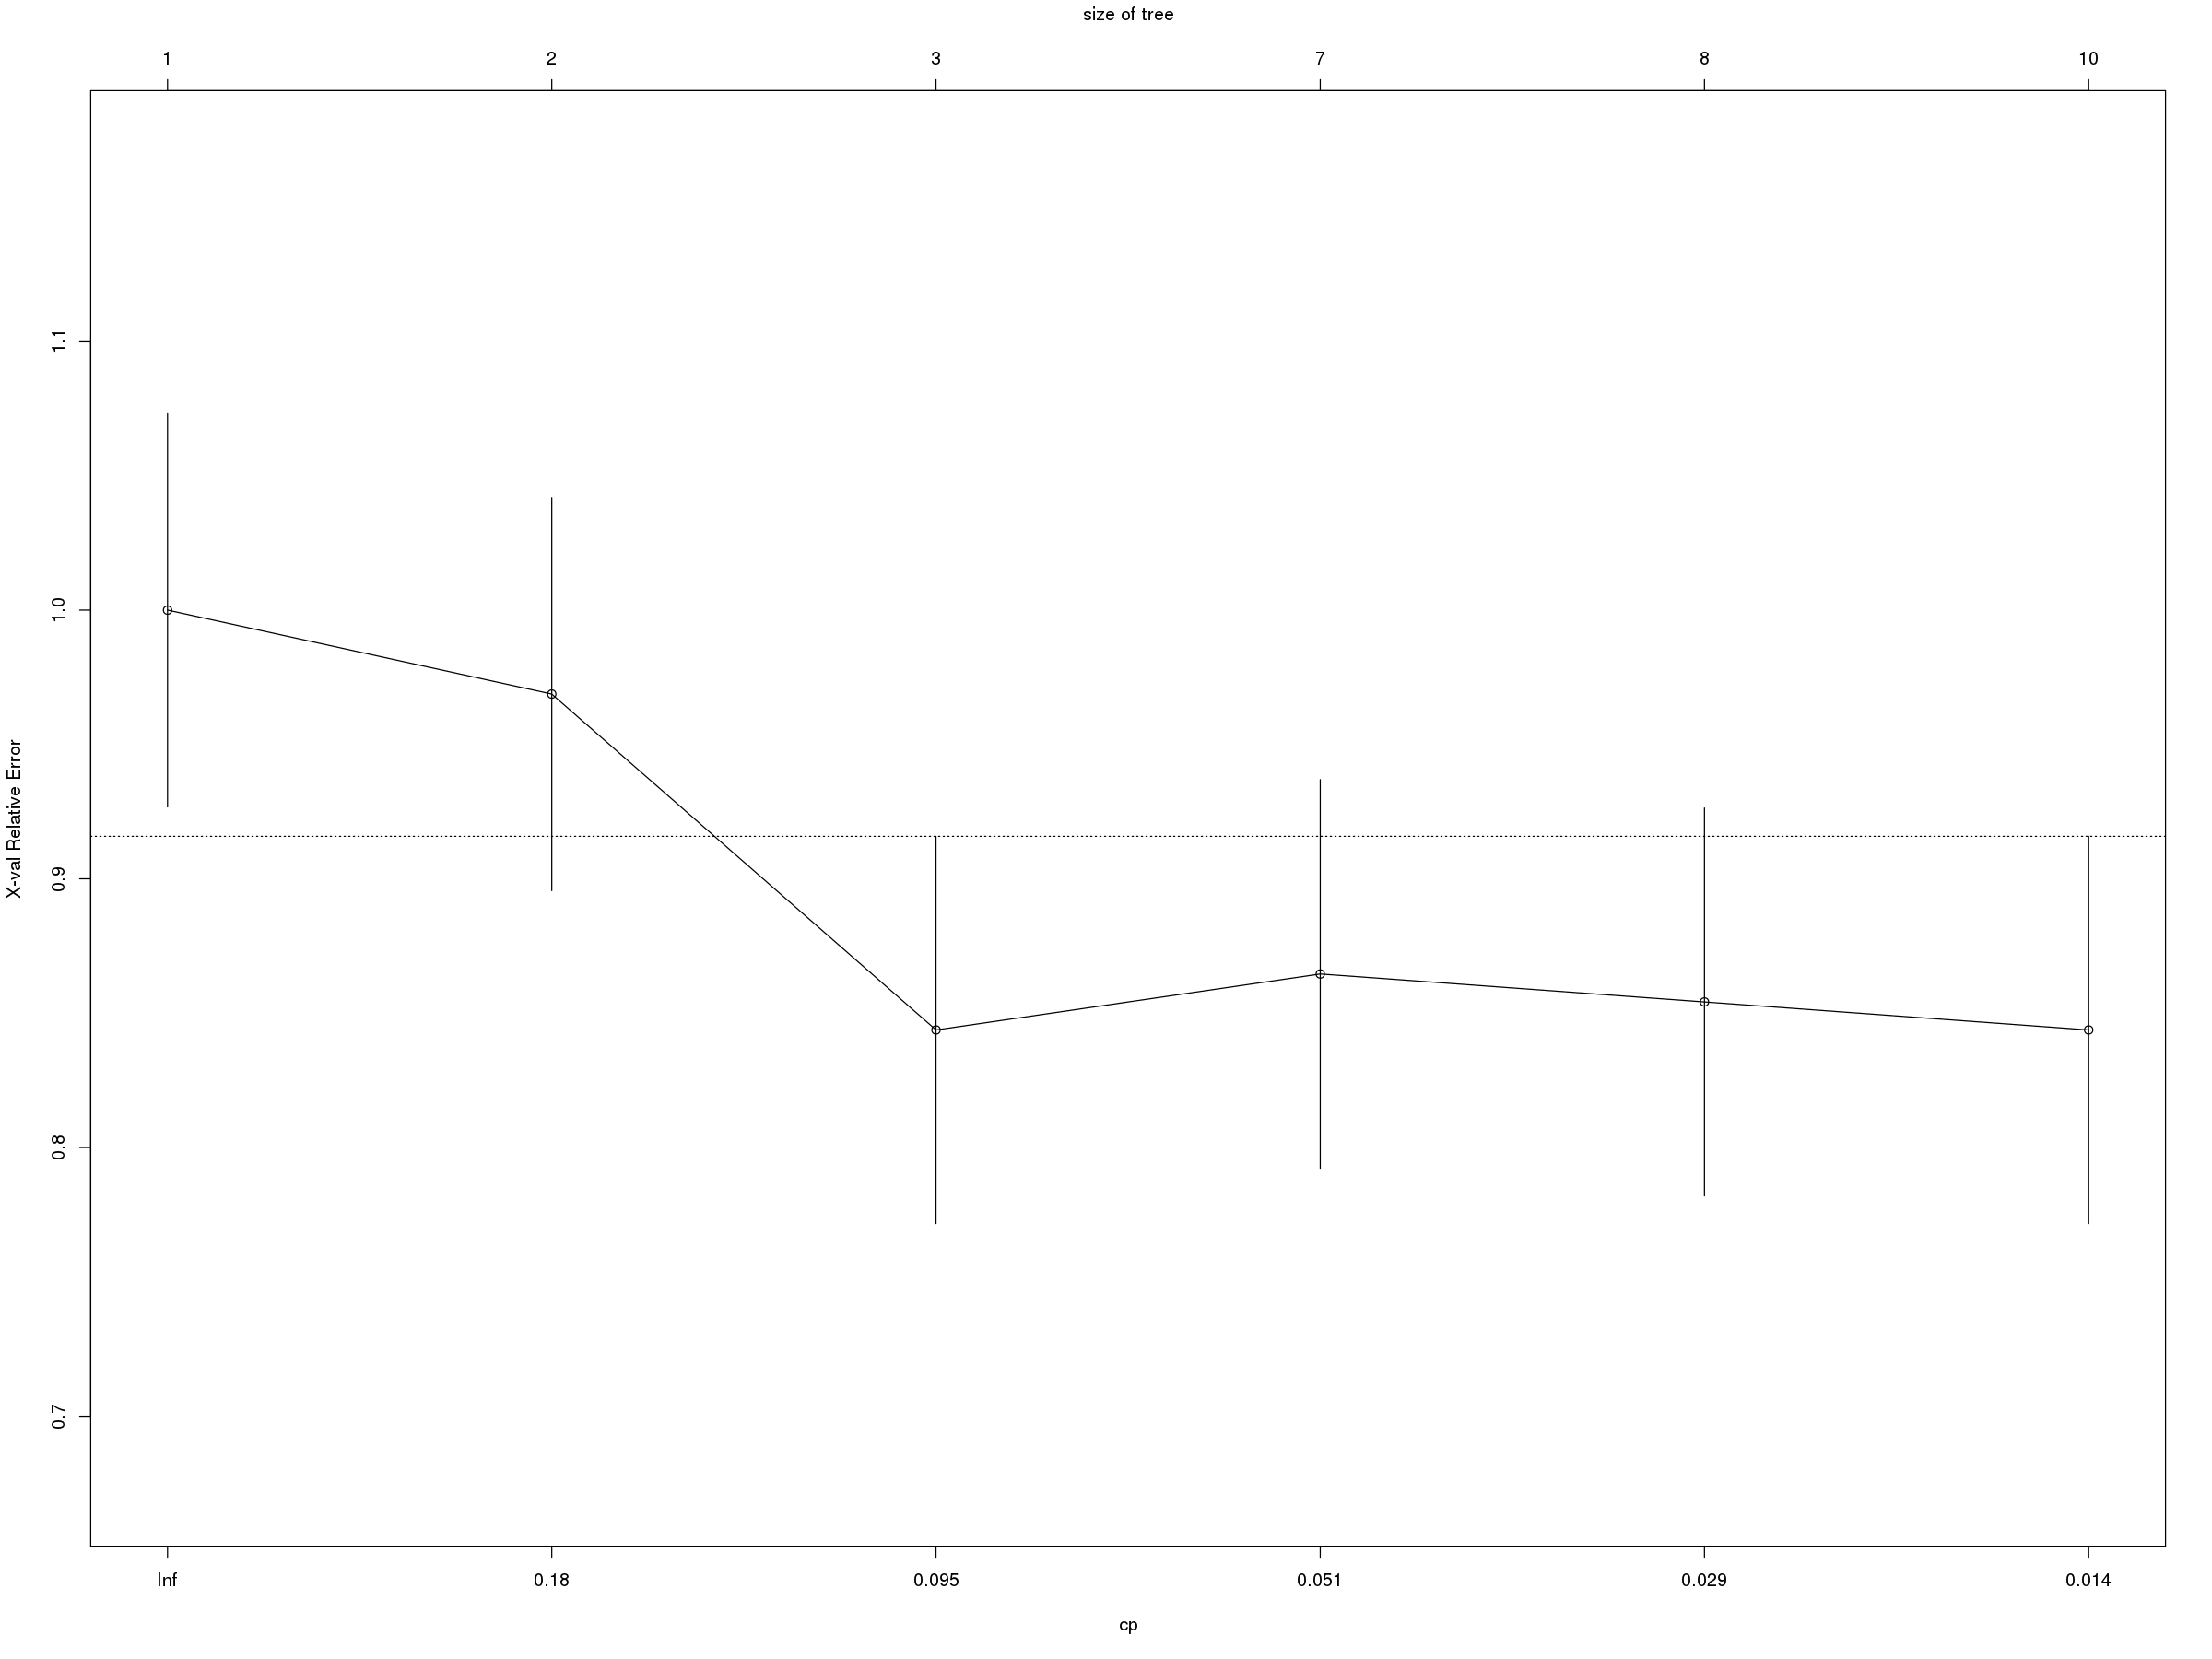

In [37]:
plotcp(fit) 

In [65]:
summary(fit)

Call:
rpart(formula = auc_win_aggseg2 ~ ., data = train, method = "class")
  n=198 (49 observations deleted due to missingness)

          CP nsplit rel error    xerror       xstd
1 0.22916667      0 1.0000000 1.0000000 0.07325409
2 0.14583333      1 0.7708333 0.9687500 0.07315303
3 0.06250000      2 0.6250000 0.8437500 0.07206620
4 0.04166667      6 0.3750000 0.8645833 0.07232428
5 0.02083333      7 0.3333333 0.8541667 0.07219915
6 0.01000000      9 0.2916667 0.8437500 0.07206620

Variable importance
reseller_country_maj                count              tld_rat 
                  14                   12                    8 
          sldlen_rng           gibbs_kurt          sldlen_kurt 
                   7                    6                    5 
           gibbs_rng           pdcnt_mean           sldlen_max 
                   4                    4                    4 
         daydom_mean           daydom_std            rarpt_min 
                   3                    3    

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


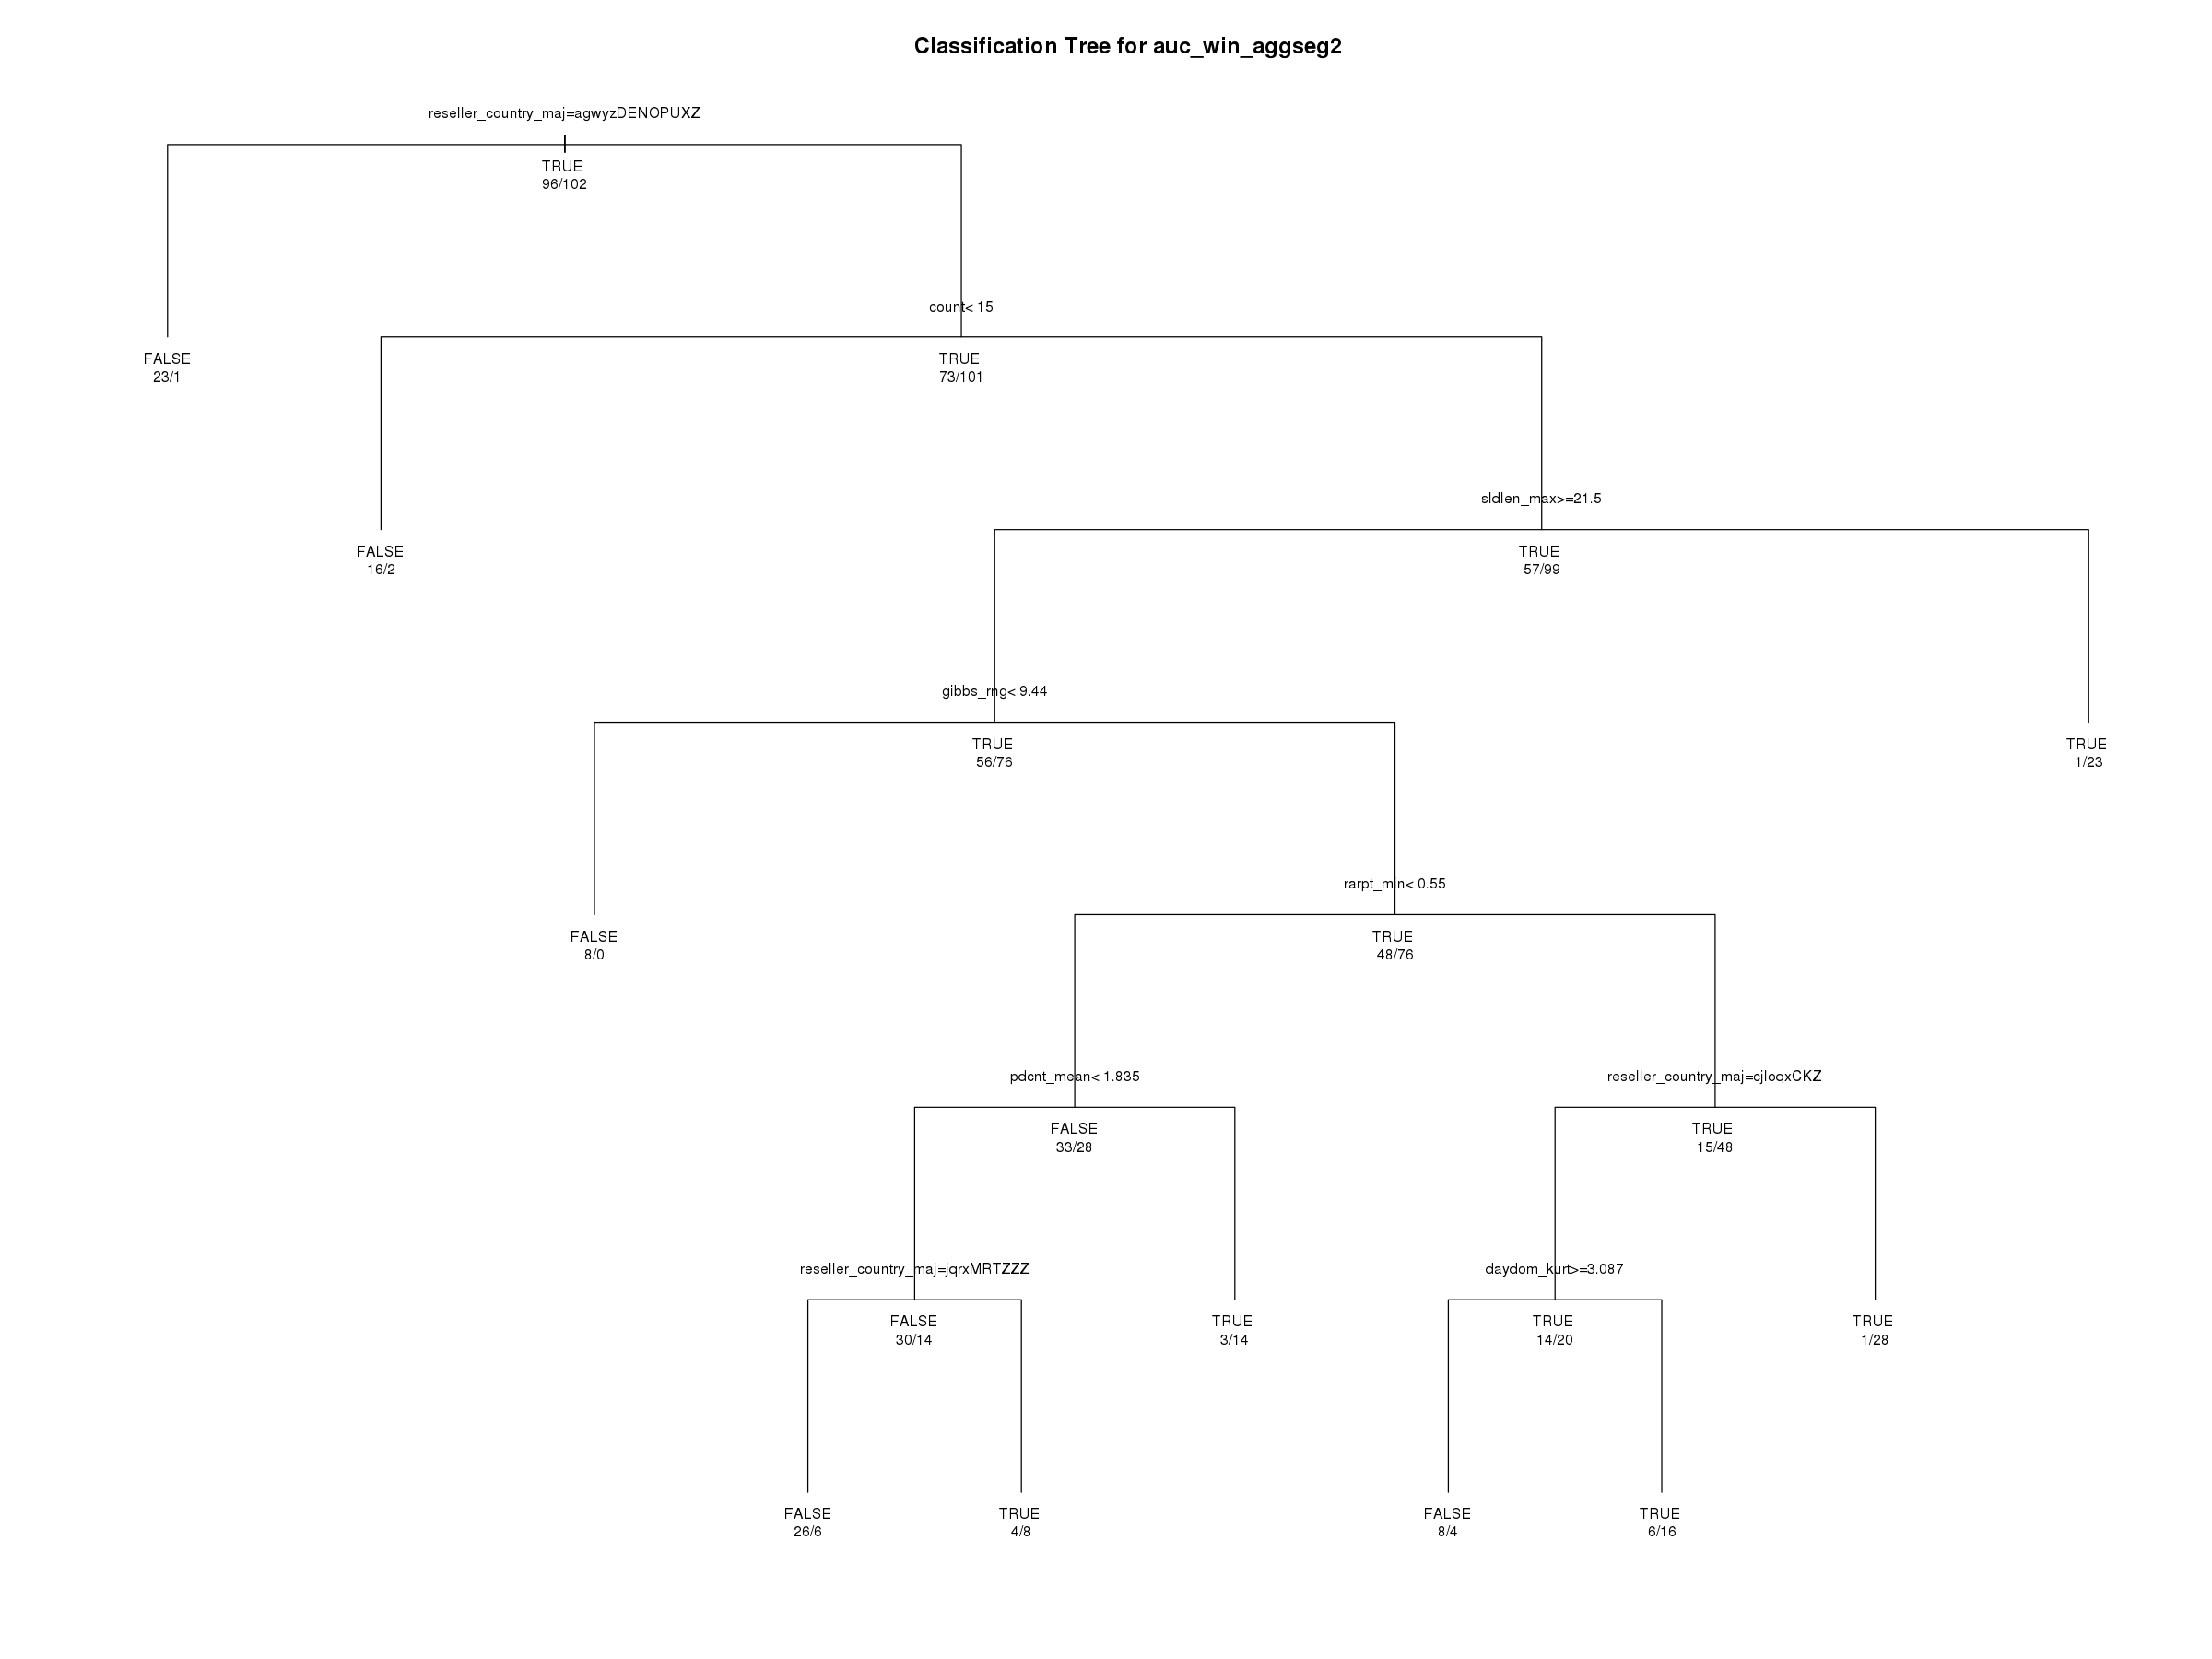

In [67]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for auc_win_aggseg2")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


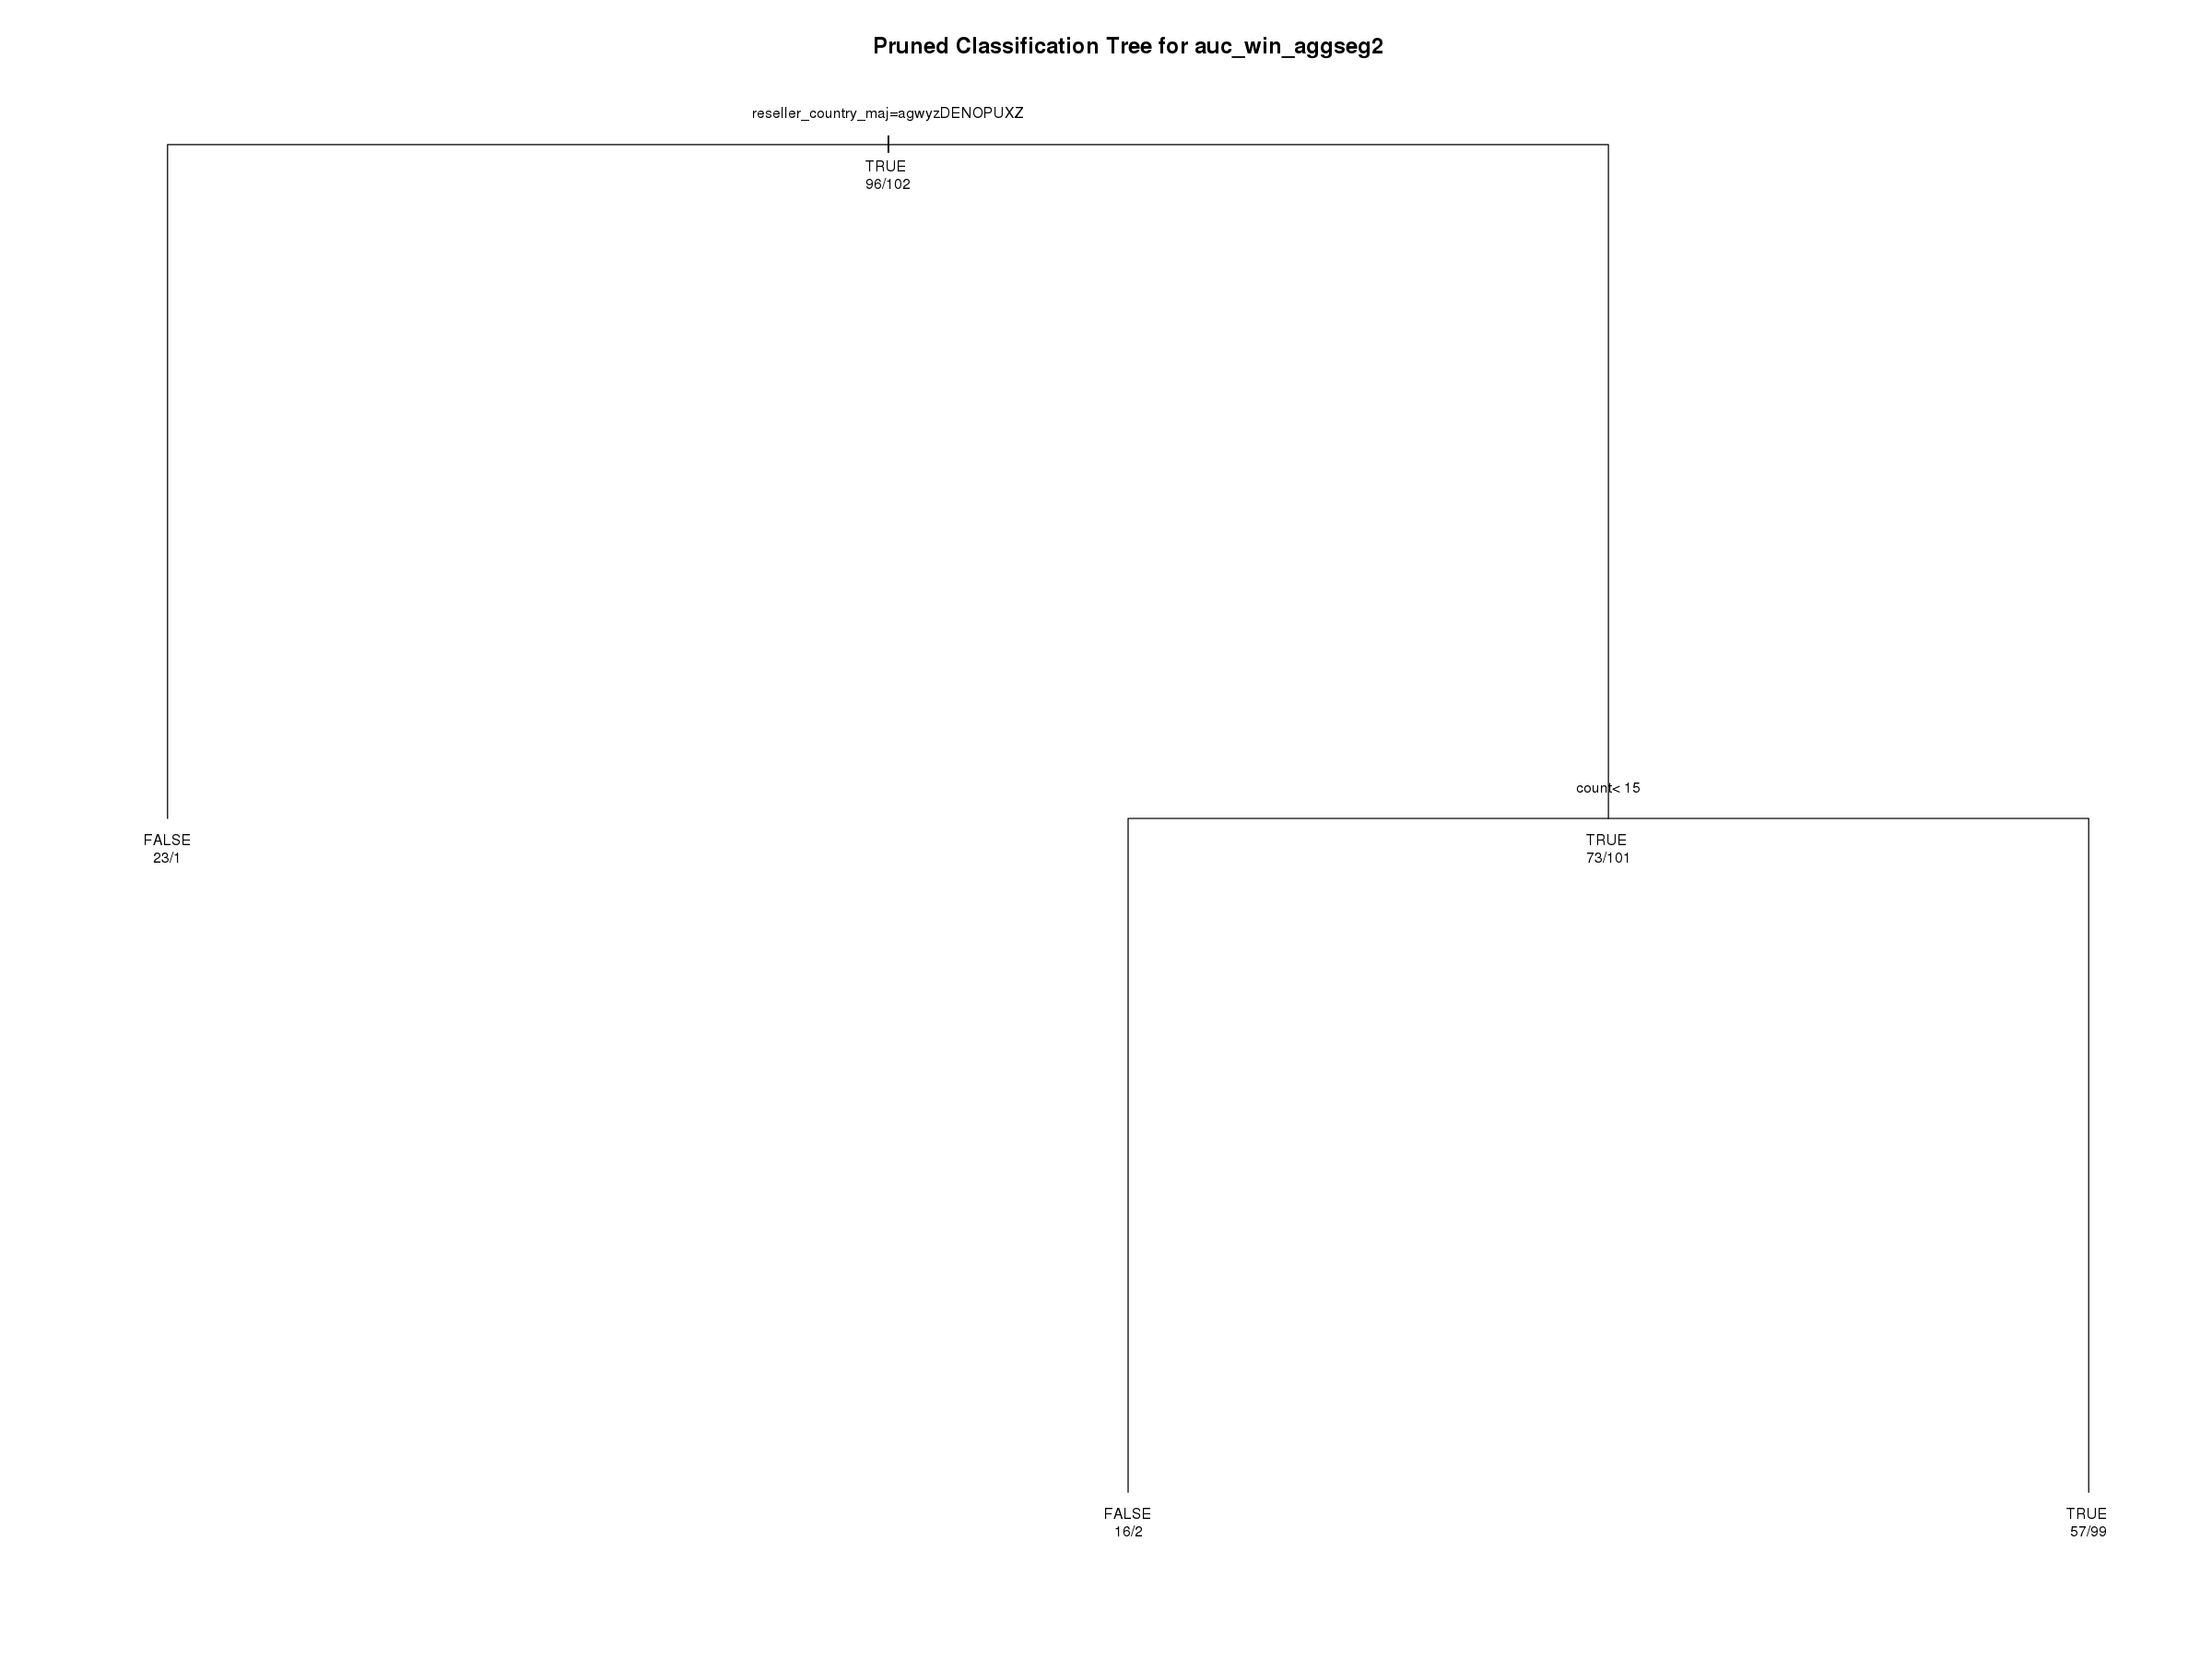

In [68]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree for auc_win_aggseg2")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

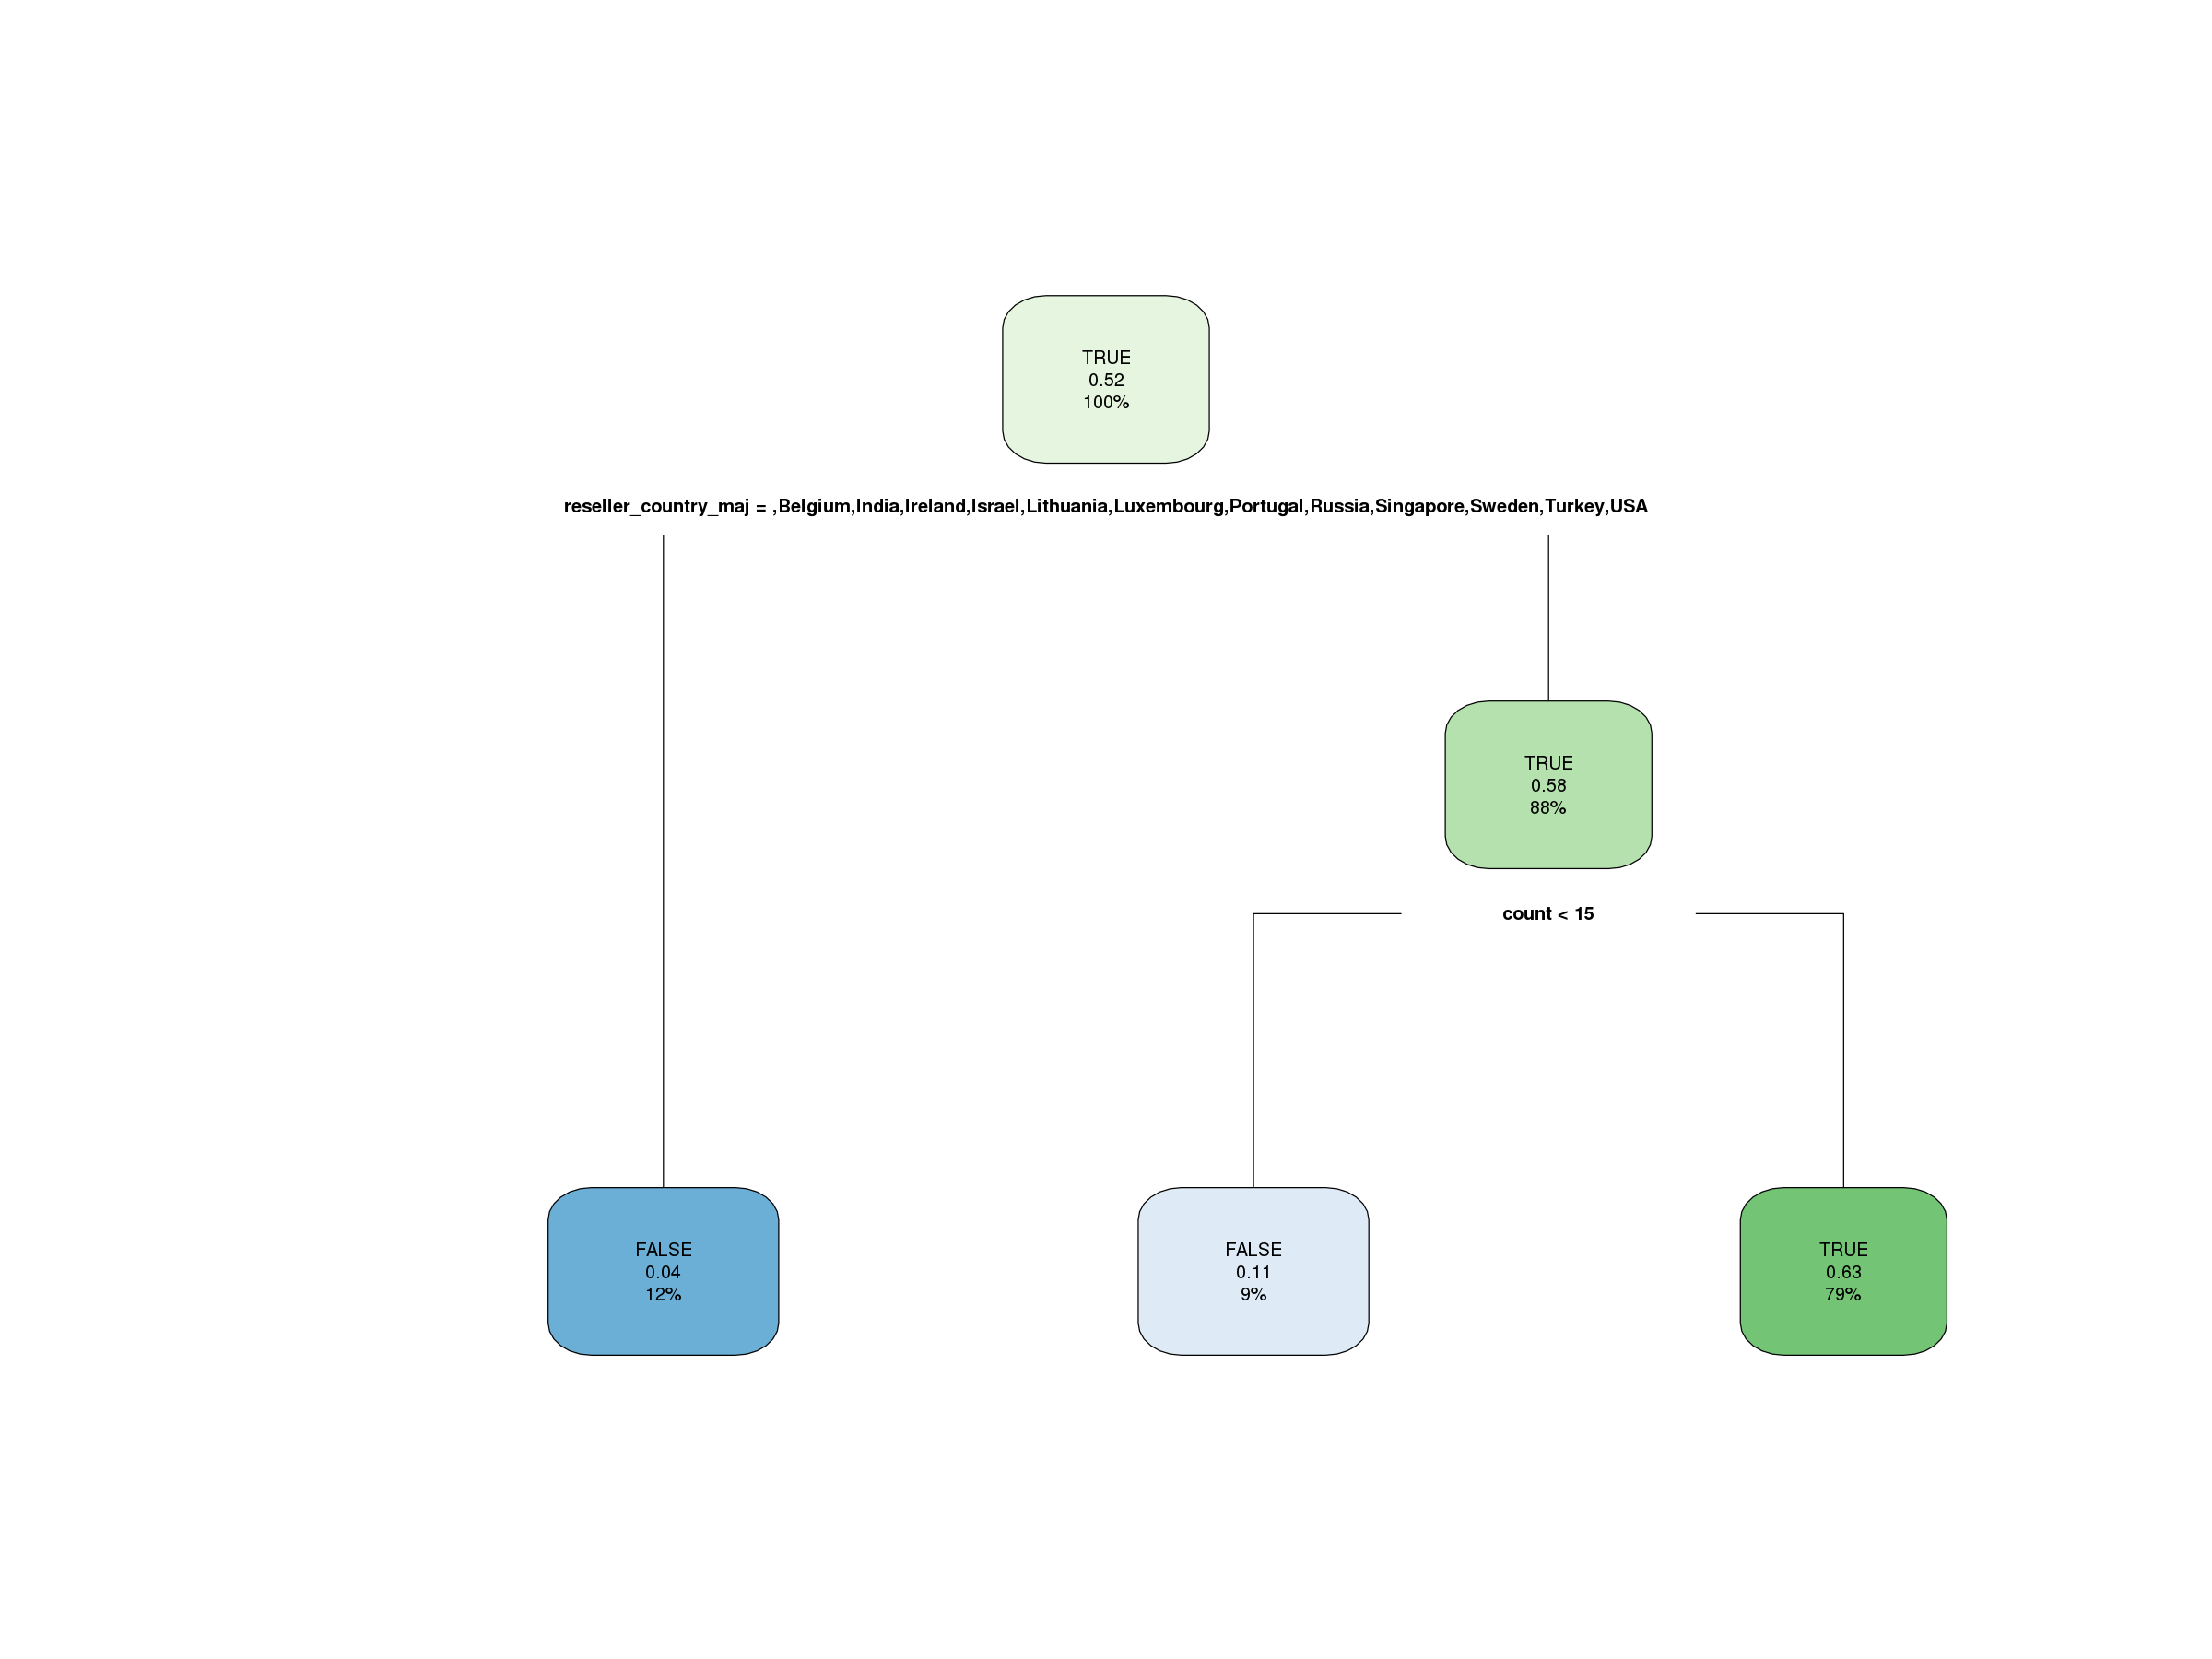

In [71]:
rpart.plot(pfit)

In [73]:
sort(prop.table(table(compare_df_all_f$reseller_country_maj)))


     Argentina     Bangladesh        Belarus        Belgium Cayman Islands 
   0.003236246    0.003236246    0.003236246    0.003236246    0.003236246 
        Cyprus        Finland      Gibraltor         Greece        Hungary 
   0.003236246    0.003236246    0.003236246    0.003236246    0.003236246 
       Ireland         Israel     Luxembourg       Portugal      Singapore 
   0.003236246    0.003236246    0.003236246    0.003236246    0.003236246 
   Southafrica       Thailand        Ukraine            USA        Austria 
   0.003236246    0.003236246    0.003236246    0.003236246    0.006472492 
Czech Republic      Hong Kong       Malaysia    New Zealand        Nigeria 
   0.006472492    0.006472492    0.006472492    0.006472492    0.006472492 
        Norway         Others       Slovakia       Bulgaria      Lithuania 
   0.006472492    0.006472492    0.006472492    0.009708738    0.009708738 
        Poland    Switzerland        Denmark          Italy         Mexico 
   0.009708

In [100]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE     8   15
     TRUE      5   16
                                          
               Accuracy : 0.5455          
                 95% CI : (0.3885, 0.6961)
    No Information Rate : 0.7045          
    P-Value [Acc > NIR] : 0.99170         
                                          
                  Kappa : 0.1075          
                                          
 Mcnemar's Test P-Value : 0.04417         
                                          
            Sensitivity : 0.5161          
            Specificity : 0.6154          
         Pos Pred Value : 0.7619          
         Neg Pred Value : 0.3478          
             Prevalence : 0.7045          
         Detection Rate : 0.3636          
   Detection Prevalence : 0.4773          
      Balanced Accuracy : 0.5658          
                                          
       'Positive' Class : TRUE            
                     

In [101]:
# unpruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    14    9
     TRUE     15    6
                                          
               Accuracy : 0.4545          
                 95% CI : (0.3039, 0.6115)
    No Information Rate : 0.6591          
    P-Value [Acc > NIR] : 0.9983          
                                          
                  Kappa : -0.1069         
                                          
 Mcnemar's Test P-Value : 0.3074          
                                          
            Sensitivity : 0.4000          
            Specificity : 0.4828          
         Pos Pred Value : 0.2857          
         Neg Pred Value : 0.6087          
             Prevalence : 0.3409          
         Detection Rate : 0.1364          
   Detection Prevalence : 0.4773          
      Balanced Accuracy : 0.4414          
                                          
       'Positive' Class : TRUE            
                     

## Decision Tree
### l10_win_aggseg2

In [112]:
names(train)

[1] "auc_win_aggseg2"      "l10_win_aggseg2"      "auc_win_seg2seg2"    
 [4] "l10_win_seg2seg2"     "count"                "ren_prp"             
 [7] "tld_rat"              "reseller_country_maj" "region_maj"          
[10] "daydom_min"           "daydom_max"           "daydom_mean"         
[13] "daydom_rng"           "daydom_std"           "daydom_skew"         
[16] "daydom_kurt"          "sldlen_min"           "sldlen_max"          
[19] "sldlen_mean"          "sldlen_rng"           "sldlen_std"          
[22] "sldlen_skew"          "sldlen_kurt"          "gibbs_min"           
[25] "gibbs_max"            "gibbs_mean"           "gibbs_rng"           
[28] "gibbs_std"            "gibbs_skew"           "gibbs_kurt"          
[31] "pdcnt_min"            "pdcnt_max"            "pdcnt_mean"          
[34] "pdcnt_rng"            "pdcnt_std"            "pdcnt_skew"          
[37] "pdcnt_kurt"           "rarpt_min"            "rarpt_max"           
[40] "rarpt_mean"           "rarpt_rng"            "rarpt_std"           
[43] "rarpt_skew"           "rarpt_kurt"

In [113]:
fit <- rpart(l10_win_aggseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(auc_win_aggseg2,auc_win_seg2seg2,l10_win_seg2seg2) ))

In [114]:
printcp(fit) 


Classification tree:
rpart(formula = l10_win_aggseg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    auc_win_seg2seg2, l10_win_seg2seg2)), method = "class")

Variables actually used in tree construction:
[1] count                pdcnt_kurt           rarpt_std           
[4] ren_prp              reseller_country_maj sldlen_skew         
[7] sldlen_std          

Root node error: 65/182 = 0.35714

n=182 (65 observations deleted due to missingness)

        CP nsplit rel error xerror     xstd
1 0.084615      0   1.00000 1.0000 0.099449
2 0.076923      2   0.83077 1.2615 0.103266
3 0.061538      4   0.67692 1.2769 0.103373
4 0.046154      6   0.55385 1.2308 0.103014
5 0.015385      9   0.41538 1.1846 0.102539
6 0.010000     10   0.40000 1.2154 0.102869


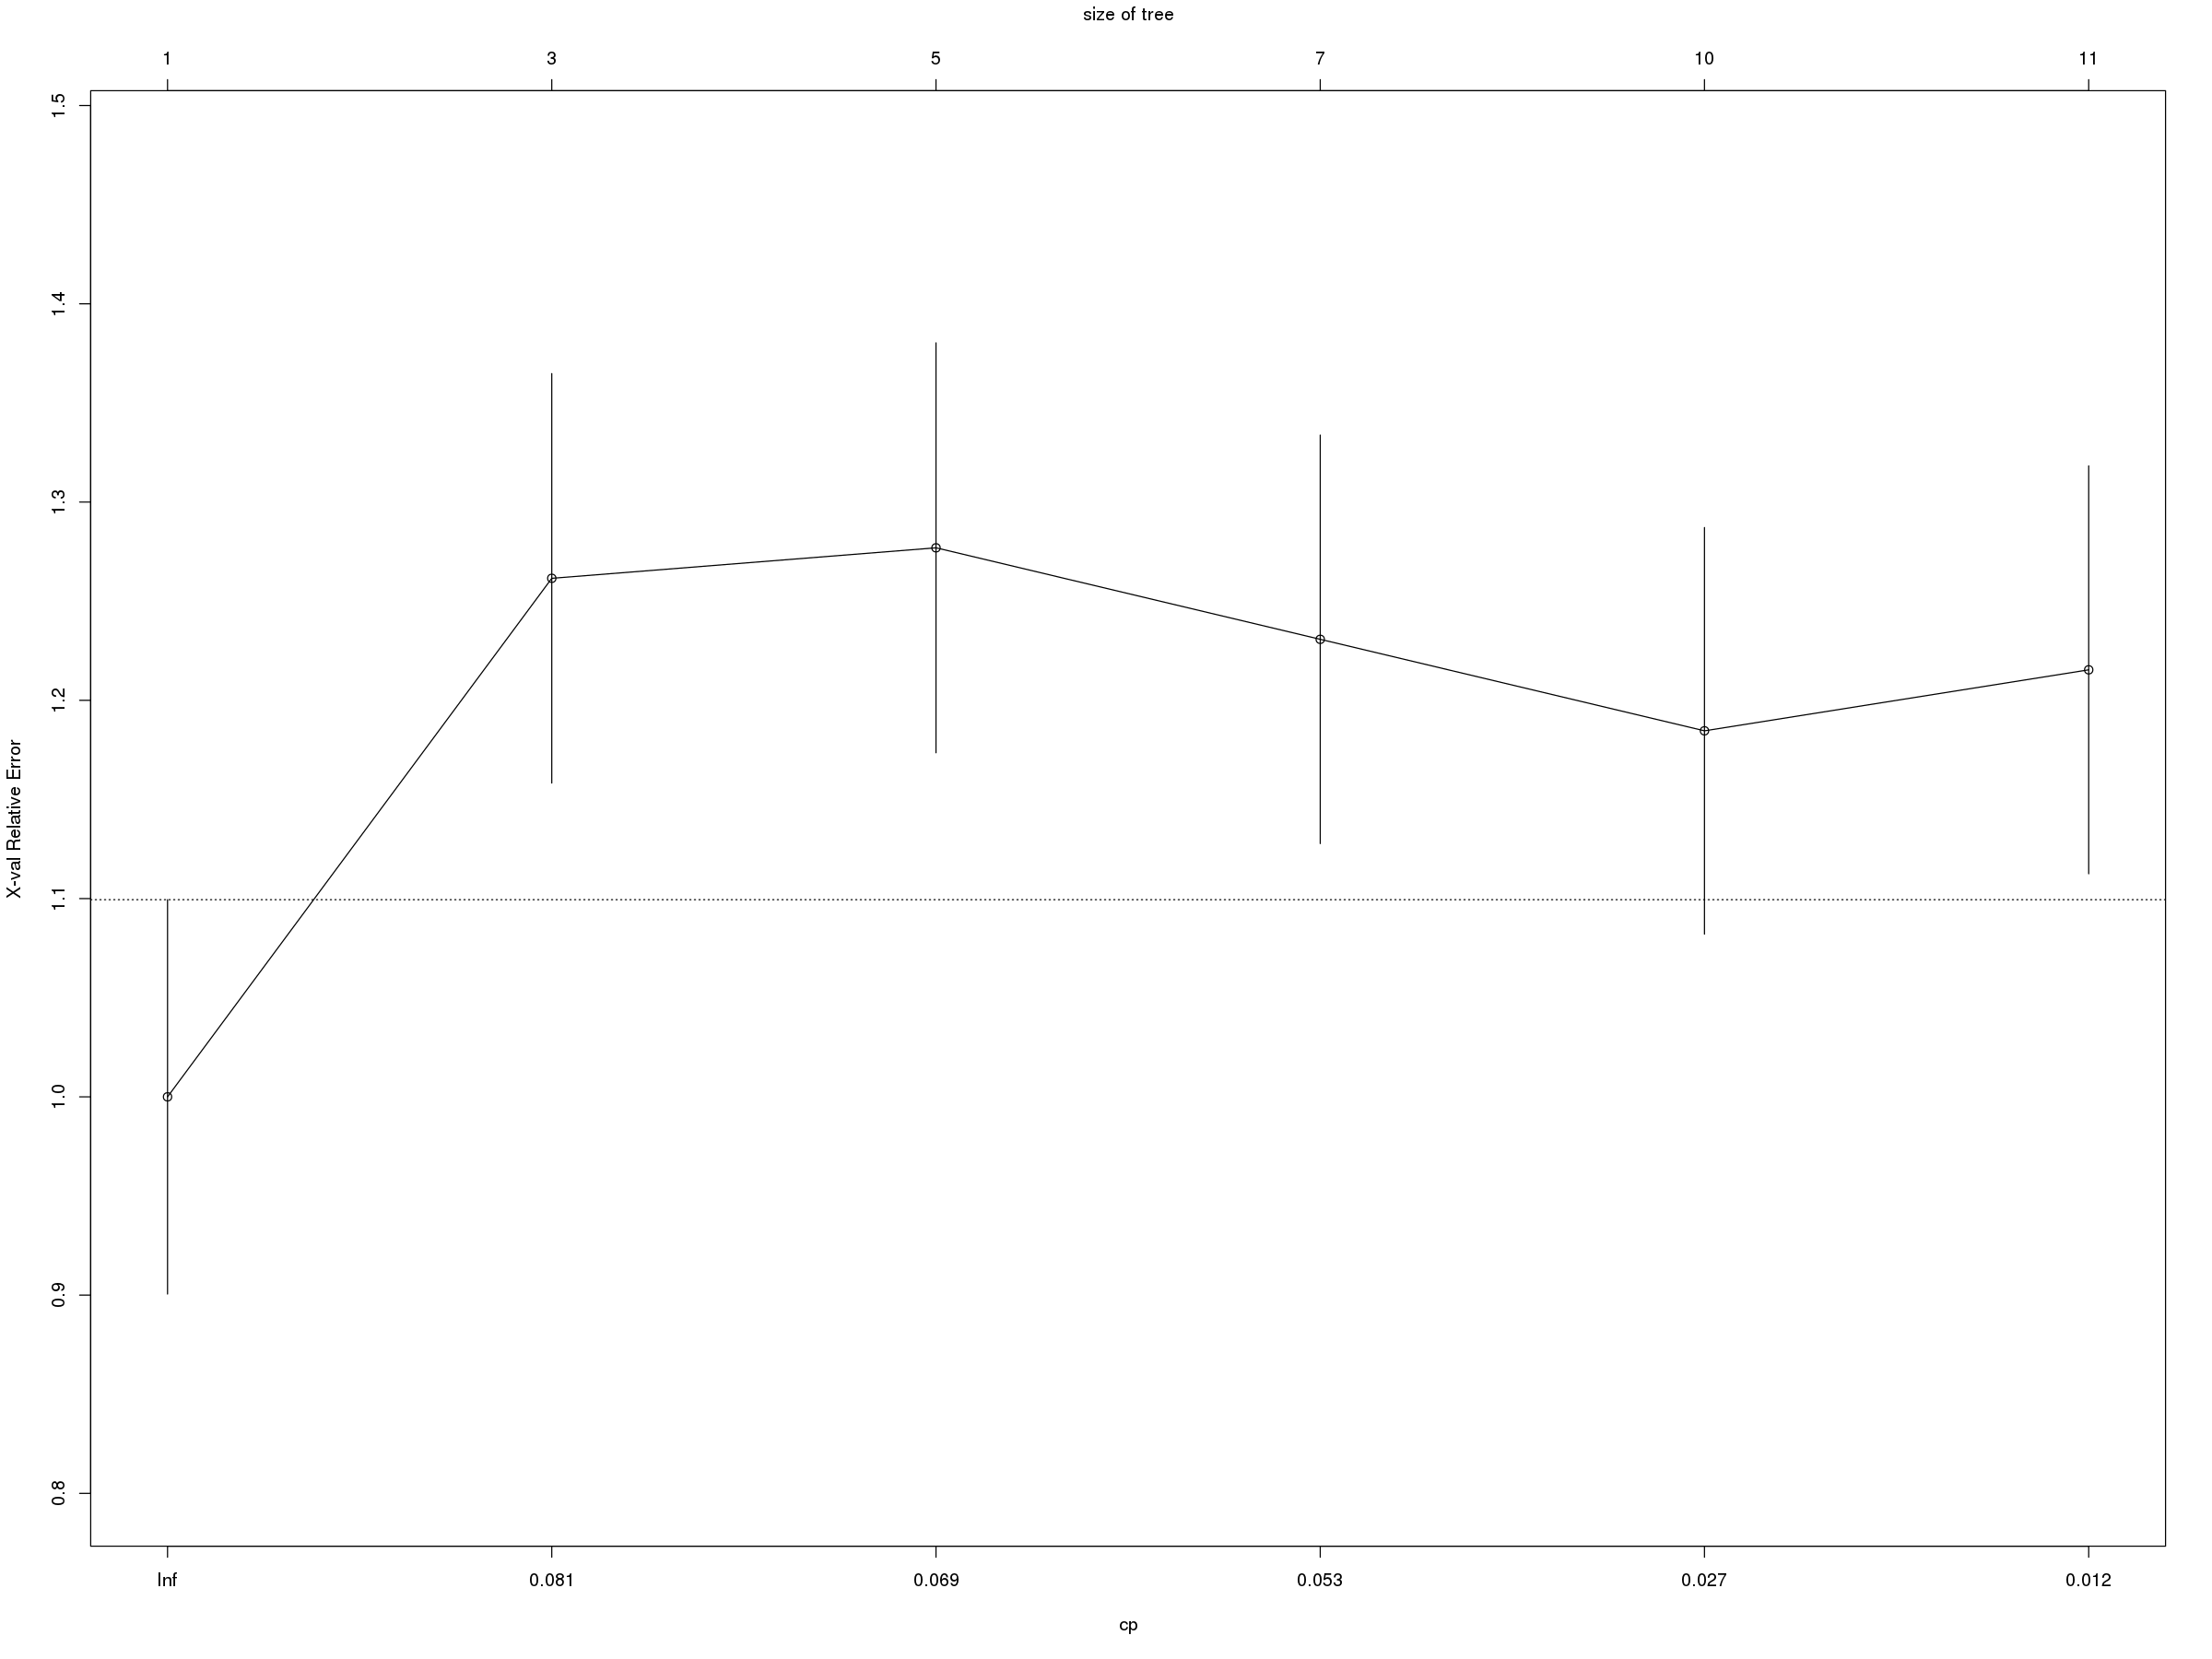

In [115]:
plotcp(fit) 

In [116]:
summary(fit)

Call:
rpart(formula = l10_win_aggseg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    auc_win_seg2seg2, l10_win_seg2seg2)), method = "class")
  n=182 (65 observations deleted due to missingness)

          CP nsplit rel error   xerror       xstd
1 0.08461538      0 1.0000000 1.000000 0.09944903
2 0.07692308      2 0.8307692 1.261538 0.10326612
3 0.06153846      4 0.6769231 1.276923 0.10337311
4 0.04615385      6 0.5538462 1.230769 0.10301395
5 0.01538462      9 0.4153846 1.184615 0.10253944
6 0.01000000     10 0.4000000 1.215385 0.10286867

Variable importance
reseller_country_maj                count            gibbs_rng 
                  18                    8                    6 
         sldlen_skew              ren_prp           daydom_max 
                   5                    4                    4 
          daydom_rng              tld_rat           sldlen_rng 
                   4                    4                    4 
         sldlen_kurt           sldlen

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


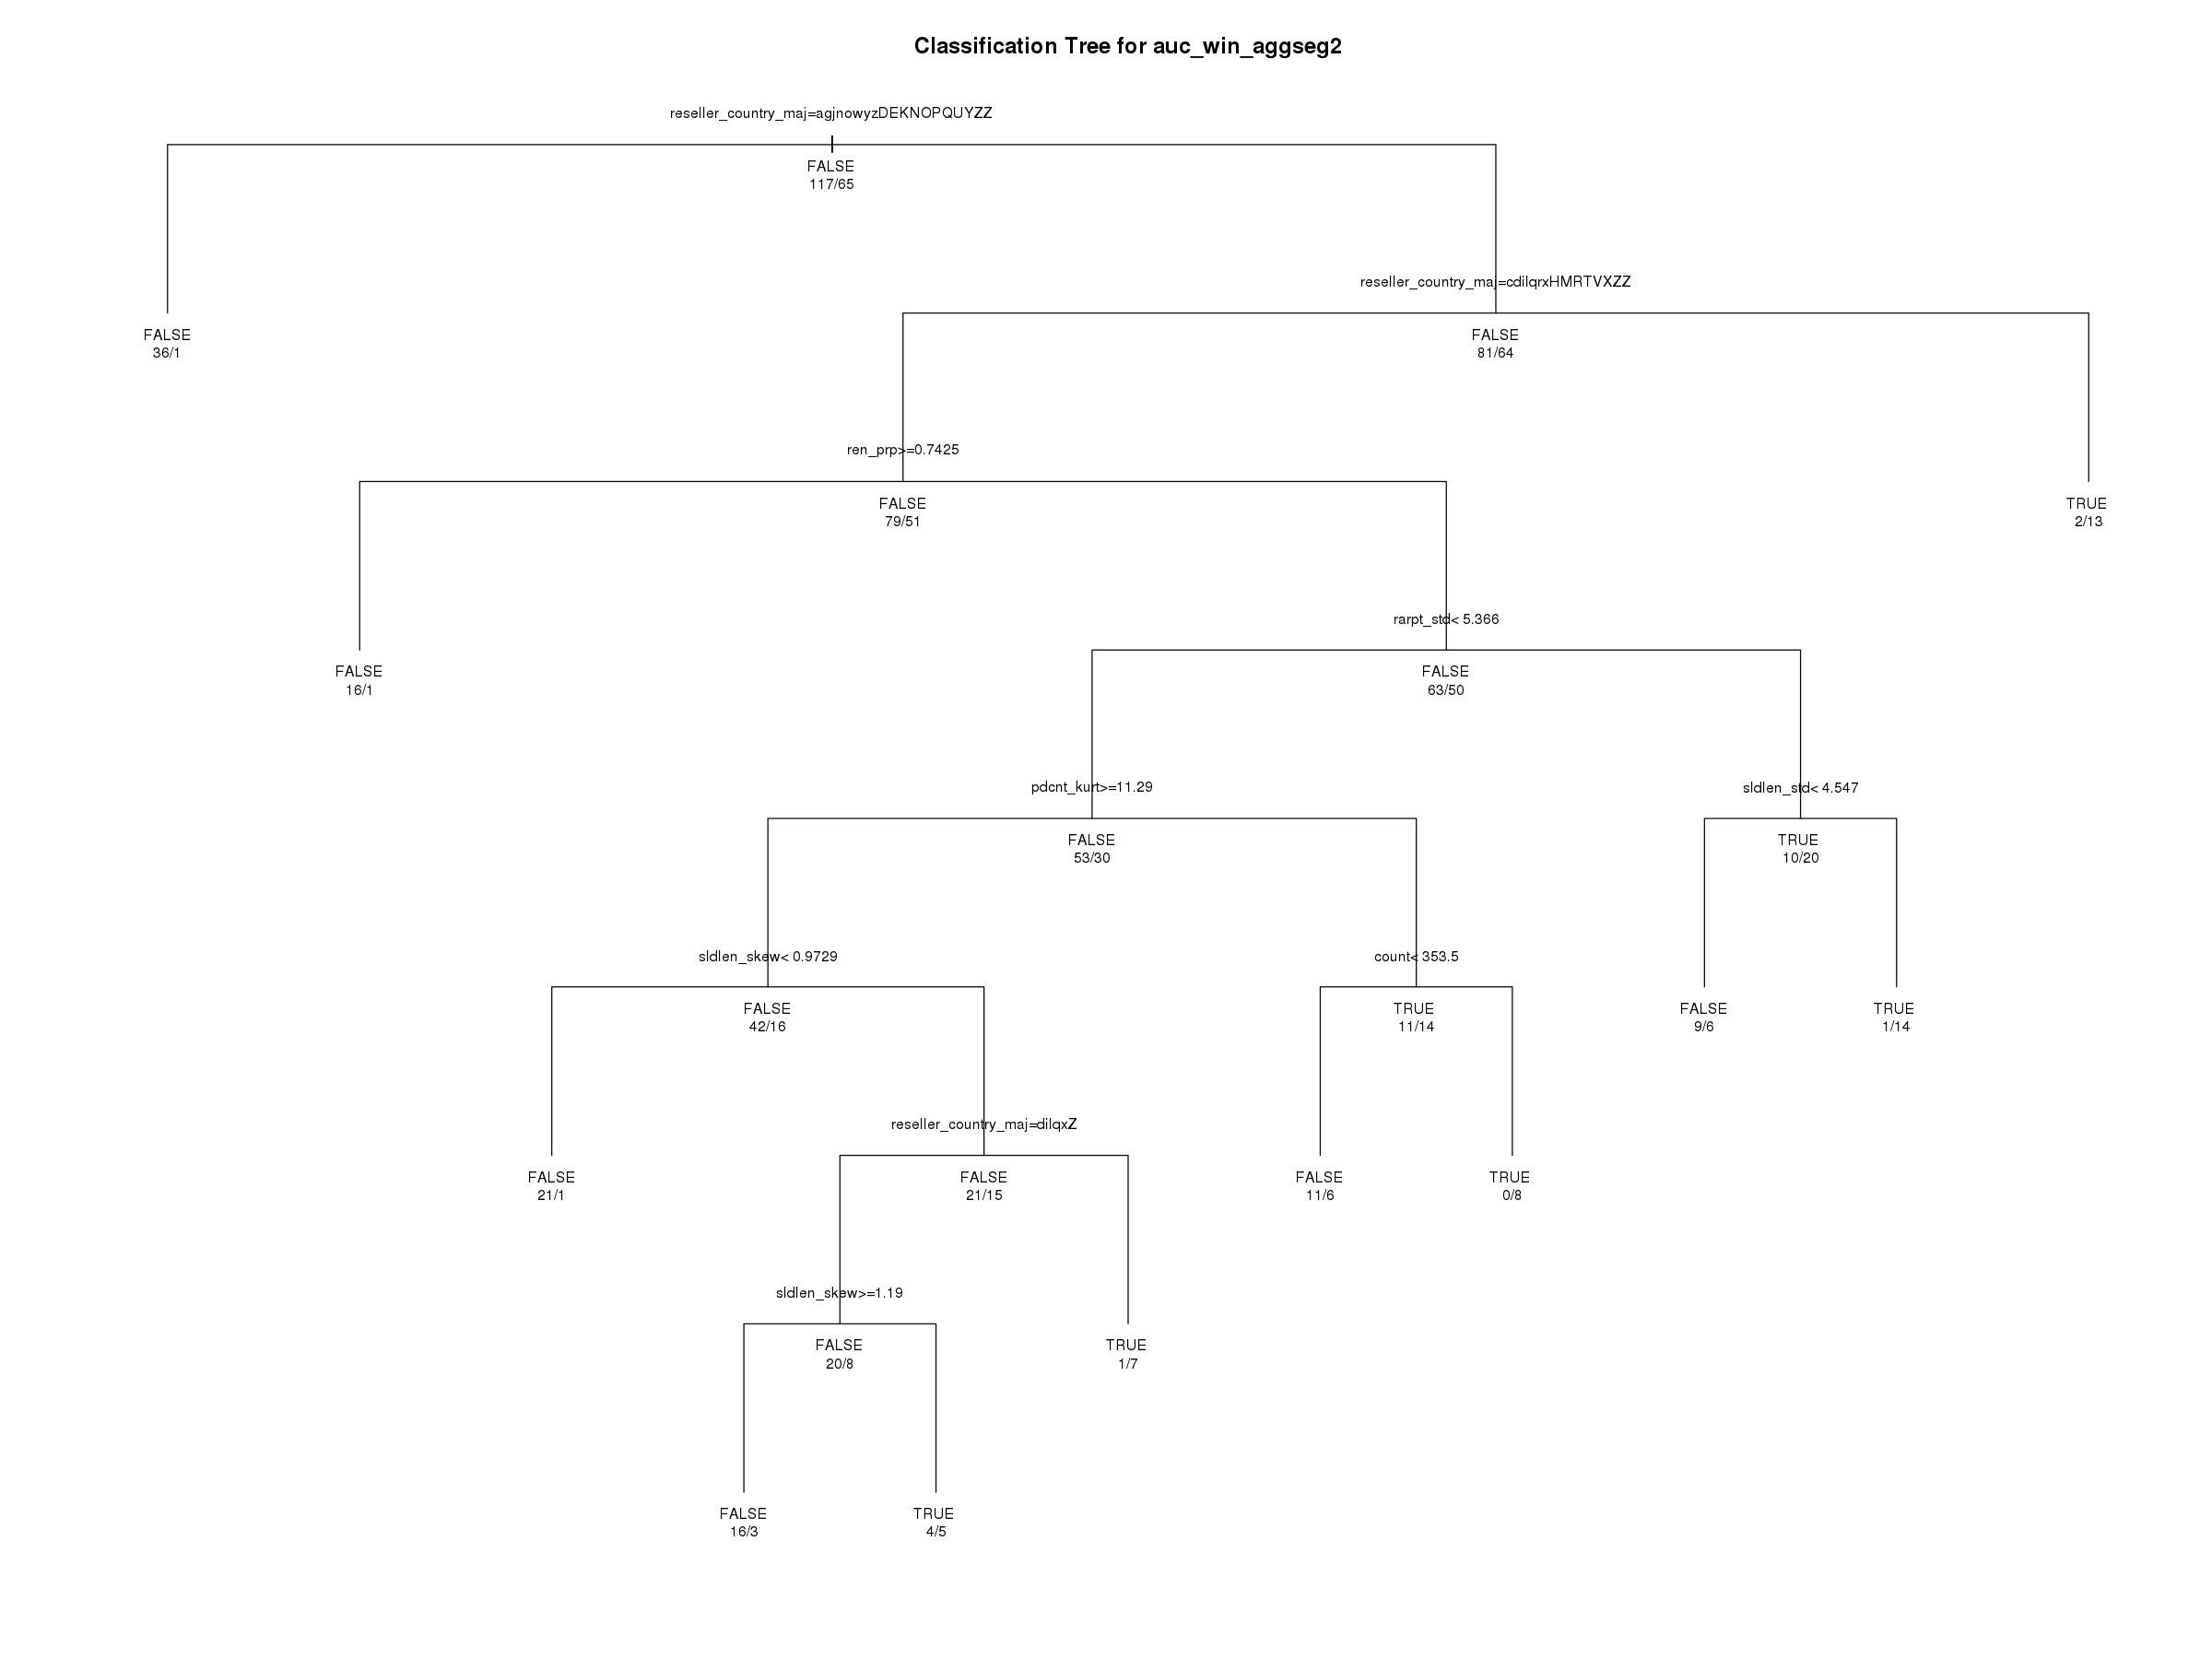

In [117]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for auc_win_aggseg2")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

In [118]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree for auc_win_aggseg2")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

ERROR: Error in plot.rpart(pfit, uniform = TRUE, main = "Pruned Classification Tree for auc_win_aggseg2"): fit is not a tree, just a root


Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


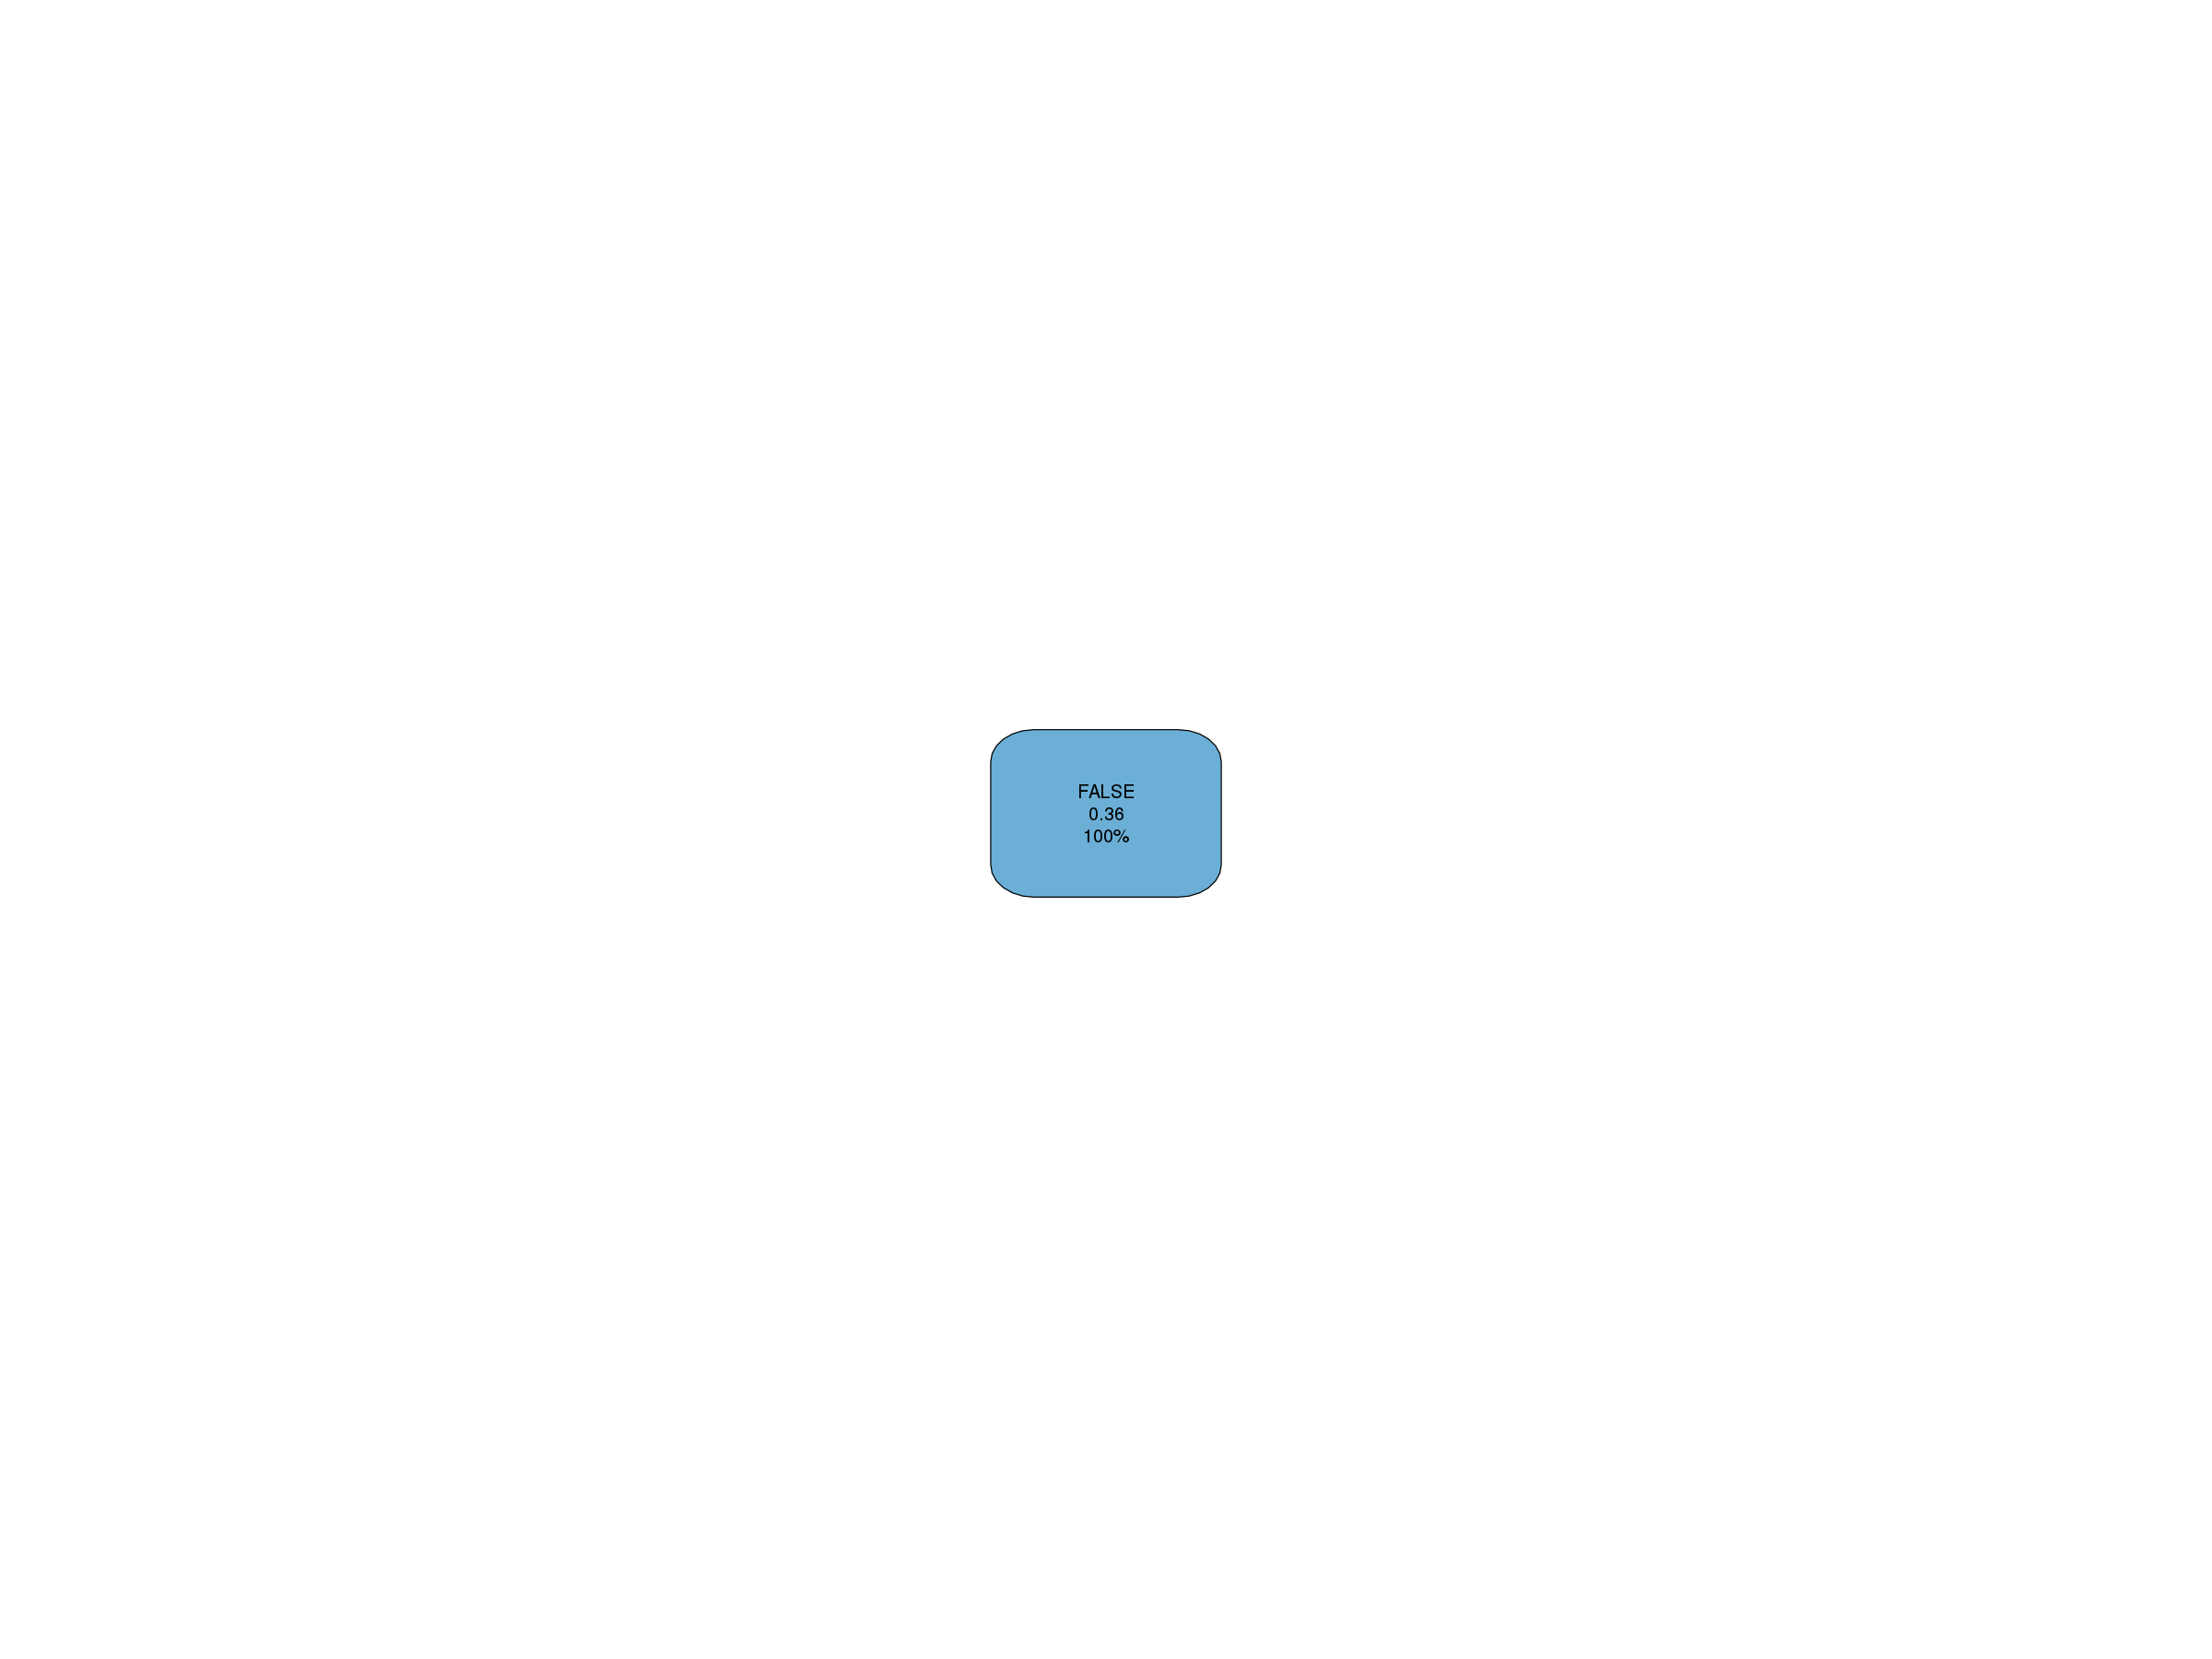

In [119]:
rpart.plot(pfit)

In [120]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")), positive='TRUE')

ERROR: Error in confusionMatrix.default(factor(test[["auc_win_aggseg2"]]), factor(predict(pfit, : the data cannot have more levels than the reference


In [121]:
# unpruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    13   10
     TRUE     12    9
                                          
               Accuracy : 0.5             
                 95% CI : (0.3456, 0.6544)
    No Information Rate : 0.5682          
    P-Value [Acc > NIR] : 0.8565          
                                          
                  Kappa : -0.0062         
                                          
 Mcnemar's Test P-Value : 0.8312          
                                          
            Sensitivity : 0.4737          
            Specificity : 0.5200          
         Pos Pred Value : 0.4286          
         Neg Pred Value : 0.5652          
             Prevalence : 0.4318          
         Detection Rate : 0.2045          
   Detection Prevalence : 0.4773          
      Balanced Accuracy : 0.4968          
                                          
       'Positive' Class : TRUE            
                     

## Decision Tree
### auc_win_seg2seg2

In [131]:
names(train)

[1] "auc_win_aggseg2"      "l10_win_aggseg2"      "auc_win_seg2seg2"    
 [4] "l10_win_seg2seg2"     "count"                "ren_prp"             
 [7] "tld_rat"              "reseller_country_maj" "region_maj"          
[10] "daydom_min"           "daydom_max"           "daydom_mean"         
[13] "daydom_rng"           "daydom_std"           "daydom_skew"         
[16] "daydom_kurt"          "sldlen_min"           "sldlen_max"          
[19] "sldlen_mean"          "sldlen_rng"           "sldlen_std"          
[22] "sldlen_skew"          "sldlen_kurt"          "gibbs_min"           
[25] "gibbs_max"            "gibbs_mean"           "gibbs_rng"           
[28] "gibbs_std"            "gibbs_skew"           "gibbs_kurt"          
[31] "pdcnt_min"            "pdcnt_max"            "pdcnt_mean"          
[34] "pdcnt_rng"            "pdcnt_std"            "pdcnt_skew"          
[37] "pdcnt_kurt"           "rarpt_min"            "rarpt_max"           
[40] "rarpt_mean"           "rarpt_rng"            "rarpt_std"           
[43] "rarpt_skew"           "rarpt_kurt"

In [122]:
fit <- rpart(auc_win_seg2seg2 ~ .,
             method="class", 
             data=subset(train, select = -c(auc_win_aggseg2,l10_win_aggseg2,l10_win_seg2seg2) ))

In [123]:
printcp(fit) 


Classification tree:
rpart(formula = auc_win_seg2seg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    l10_win_aggseg2, l10_win_seg2seg2)), method = "class")

Variables actually used in tree construction:
[1] pdcnt_skew           rarpt_std            reseller_country_maj
[4] sldlen_std           tld_rat             

Root node error: 69/153 = 0.45098

n=153 (94 observations deleted due to missingness)

        CP nsplit rel error  xerror     xstd
1 0.347826      0   1.00000 1.00000 0.089201
2 0.057971      1   0.65217 0.94203 0.088614
3 0.043478      5   0.39130 1.11594 0.089631
4 0.010000      6   0.34783 1.04348 0.089478


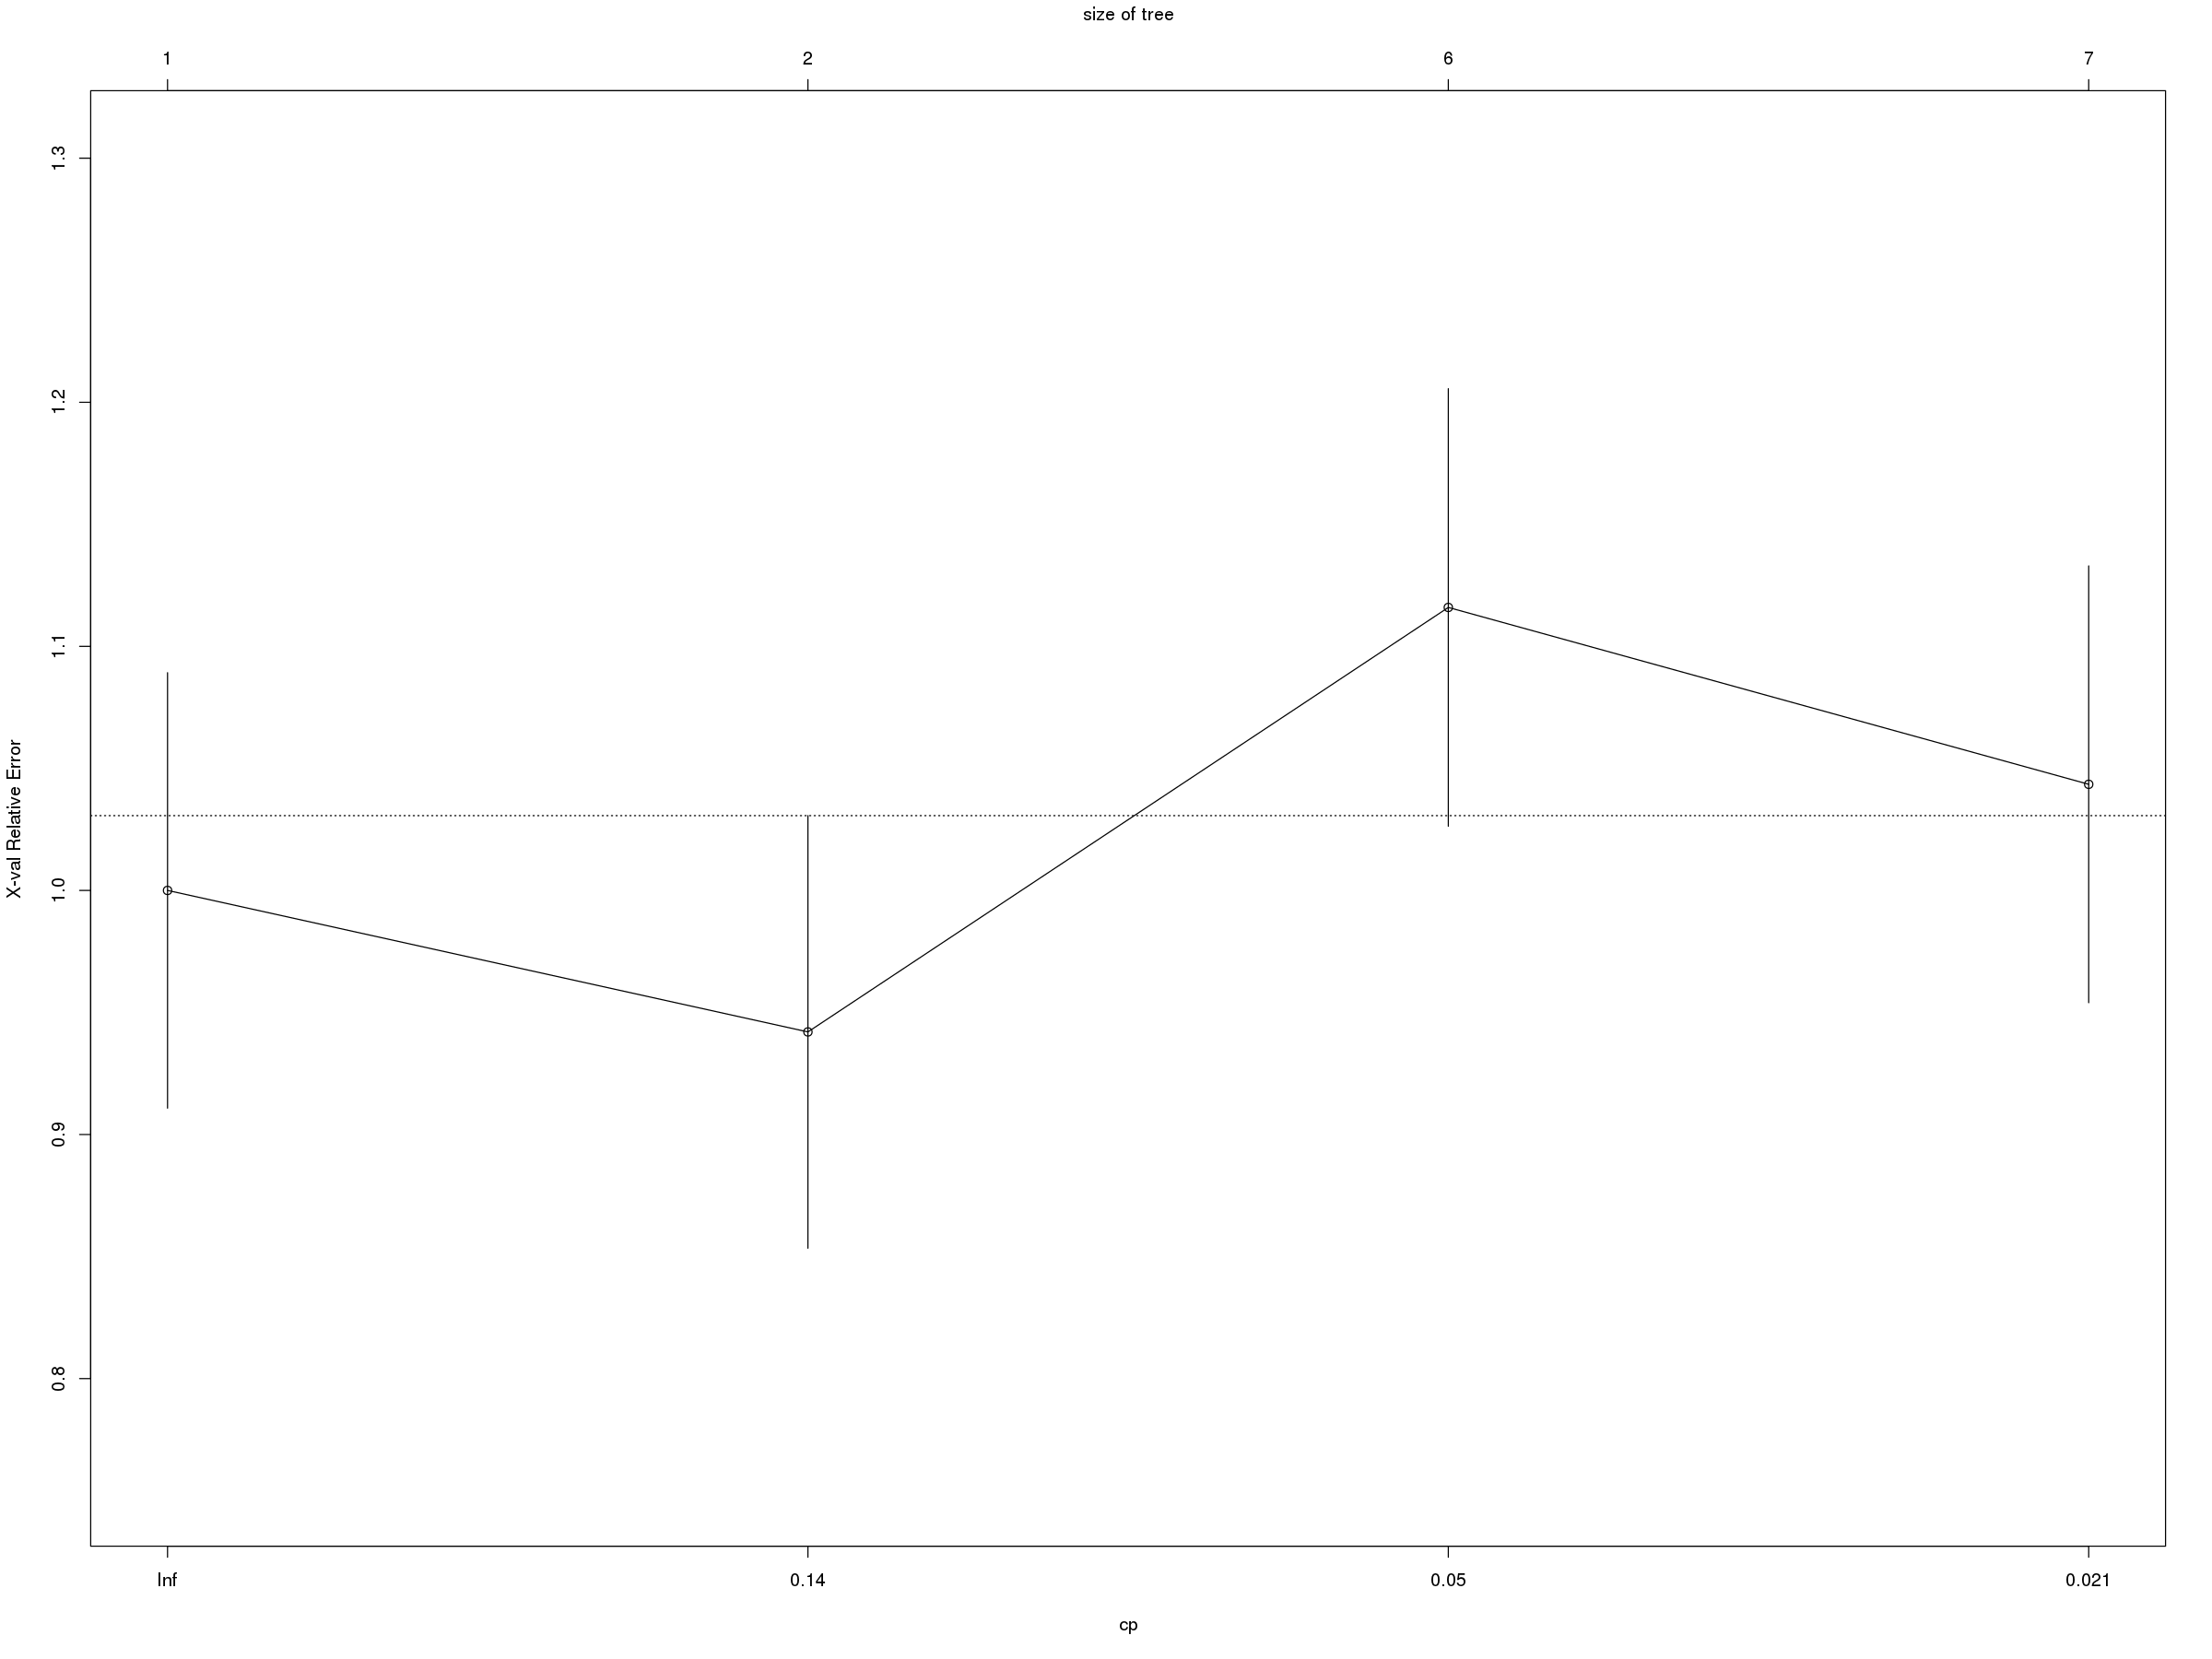

In [124]:
plotcp(fit) 

In [125]:
summary(fit)

Call:
rpart(formula = auc_win_seg2seg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    l10_win_aggseg2, l10_win_seg2seg2)), method = "class")
  n=153 (94 observations deleted due to missingness)

          CP nsplit rel error   xerror       xstd
1 0.34782609      0 1.0000000 1.000000 0.08920093
2 0.05797101      1 0.6521739 0.942029 0.08861418
3 0.04347826      5 0.3913043 1.115942 0.08963082
4 0.01000000      6 0.3478261 1.043478 0.08947752

Variable importance
reseller_country_maj              tld_rat                count 
                  25                    8                    8 
           gibbs_min           daydom_max           daydom_rng 
                   5                    5                    5 
          sldlen_std            rarpt_std            rarpt_rng 
                   5                    5                    4 
          pdcnt_skew           daydom_std           pdcnt_kurt 
                   4                    4                    4 
         

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


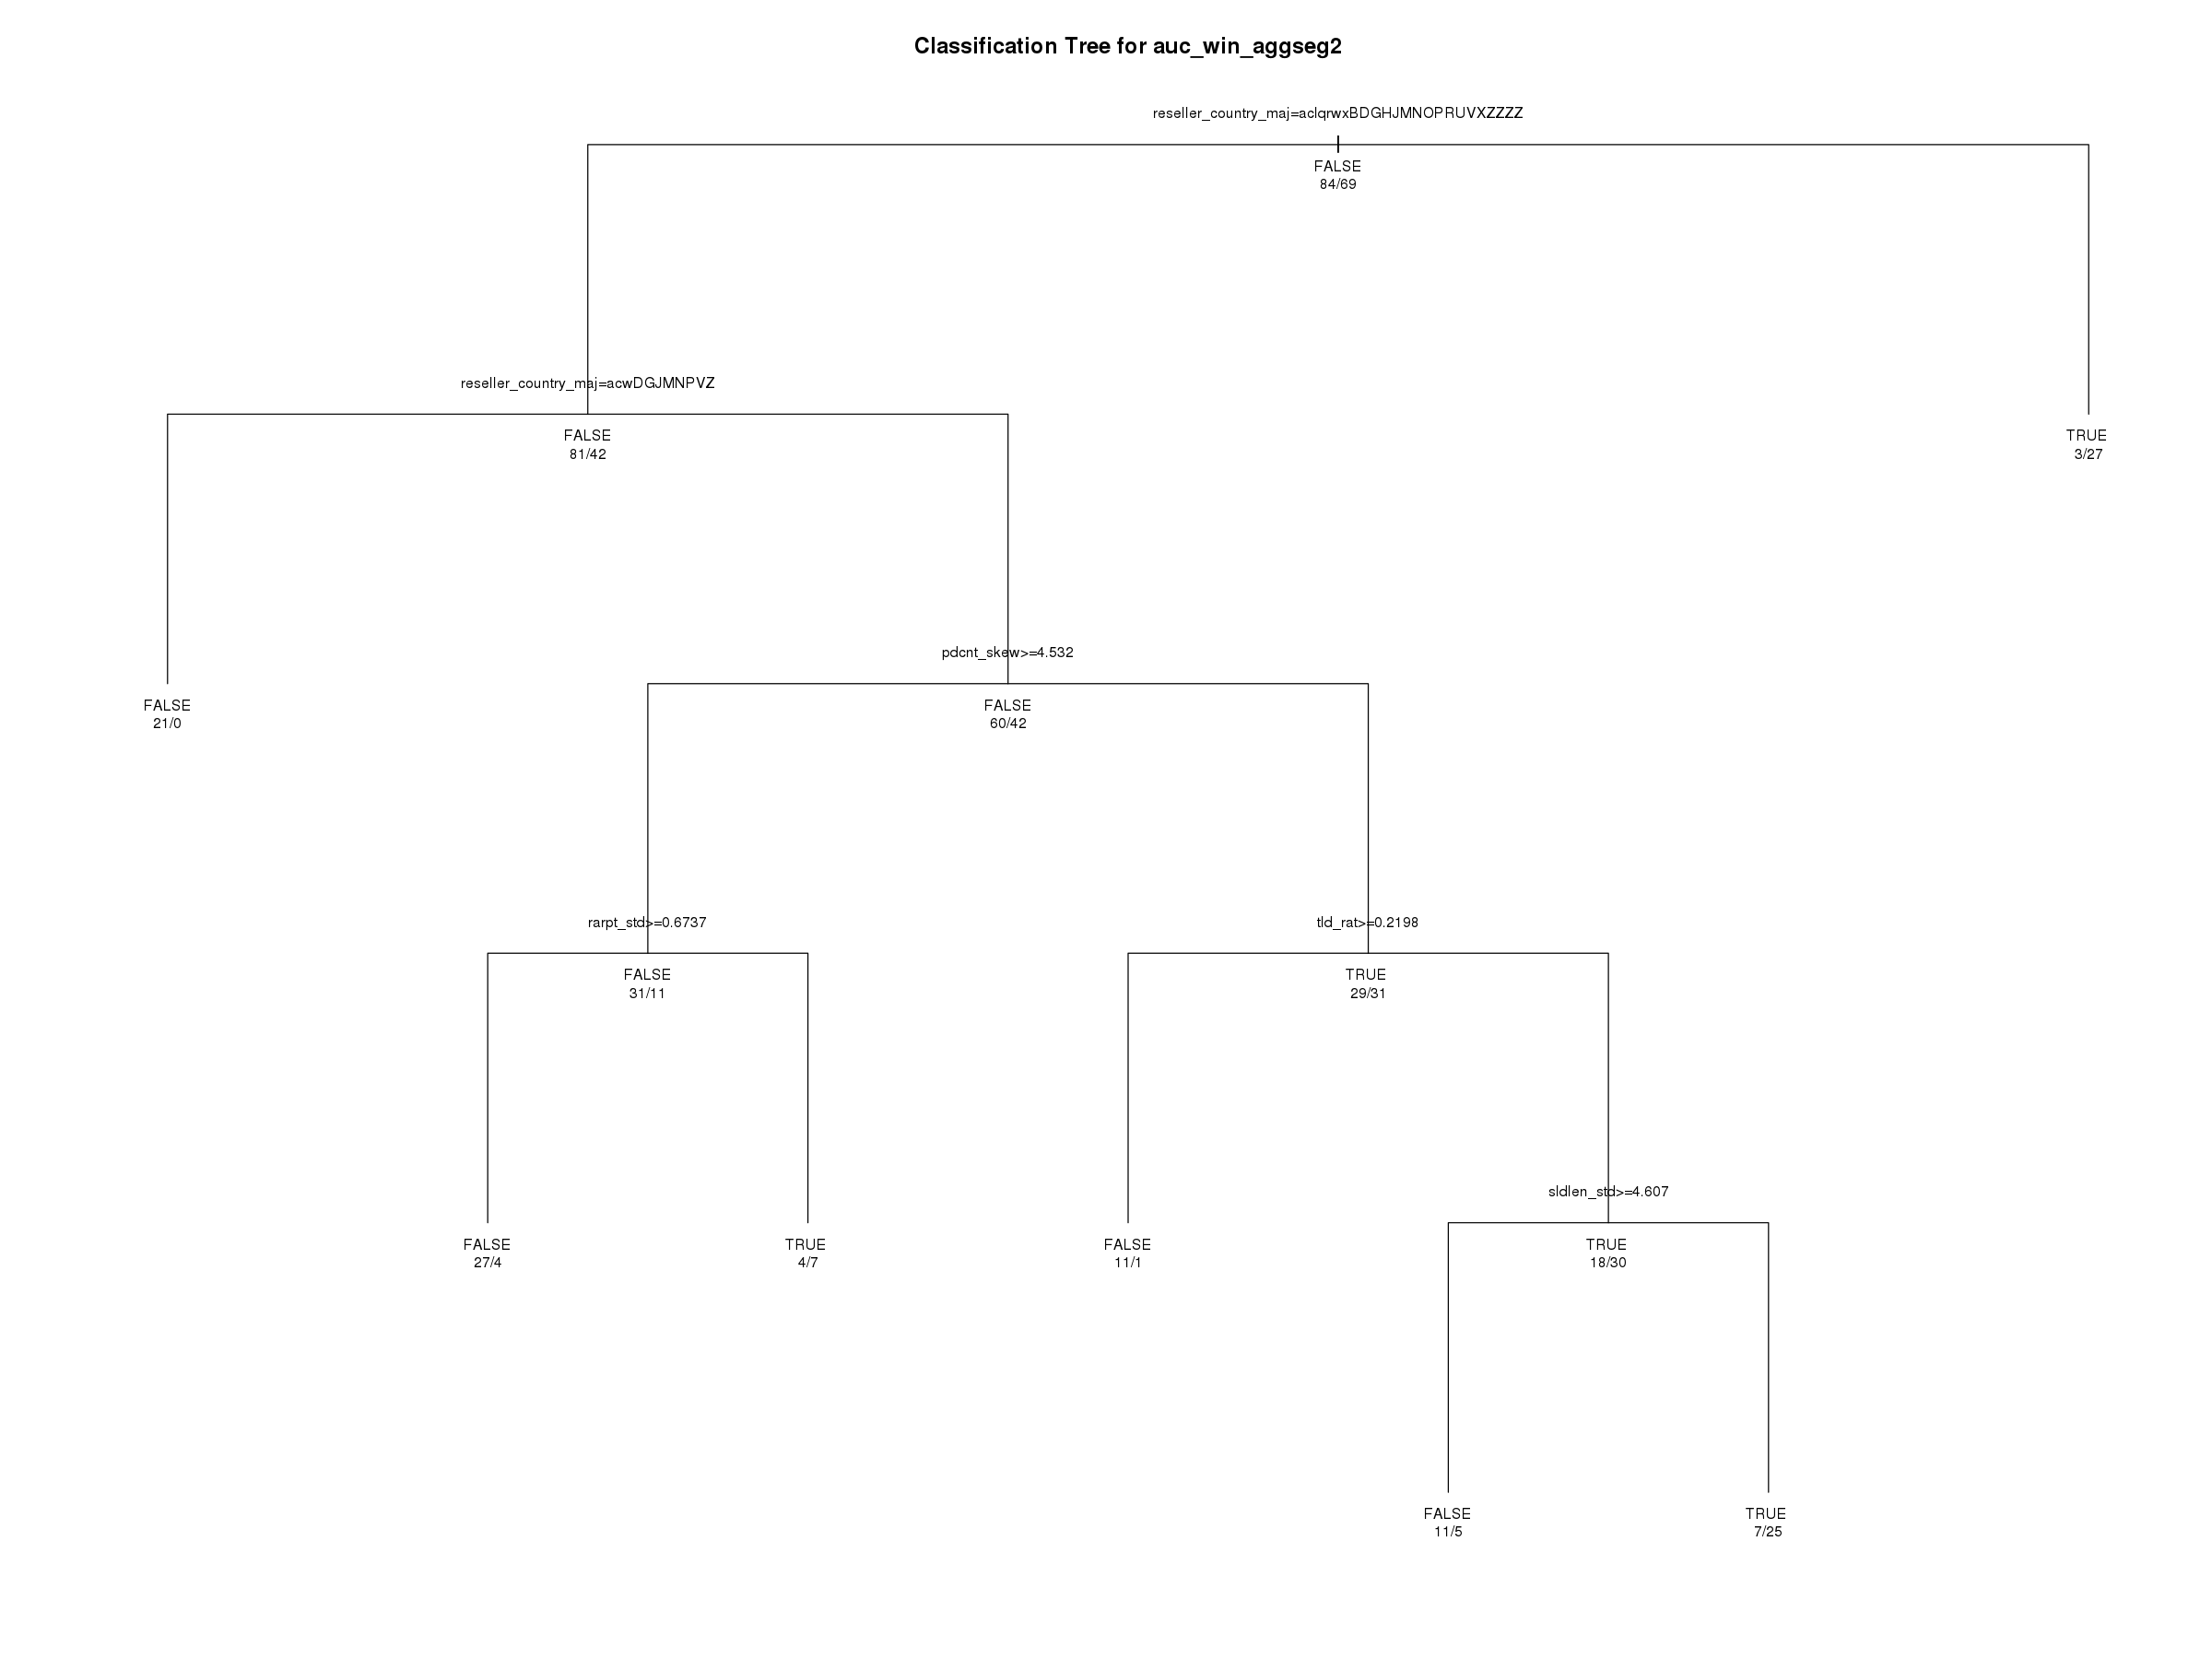

In [126]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for auc_win_aggseg2")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


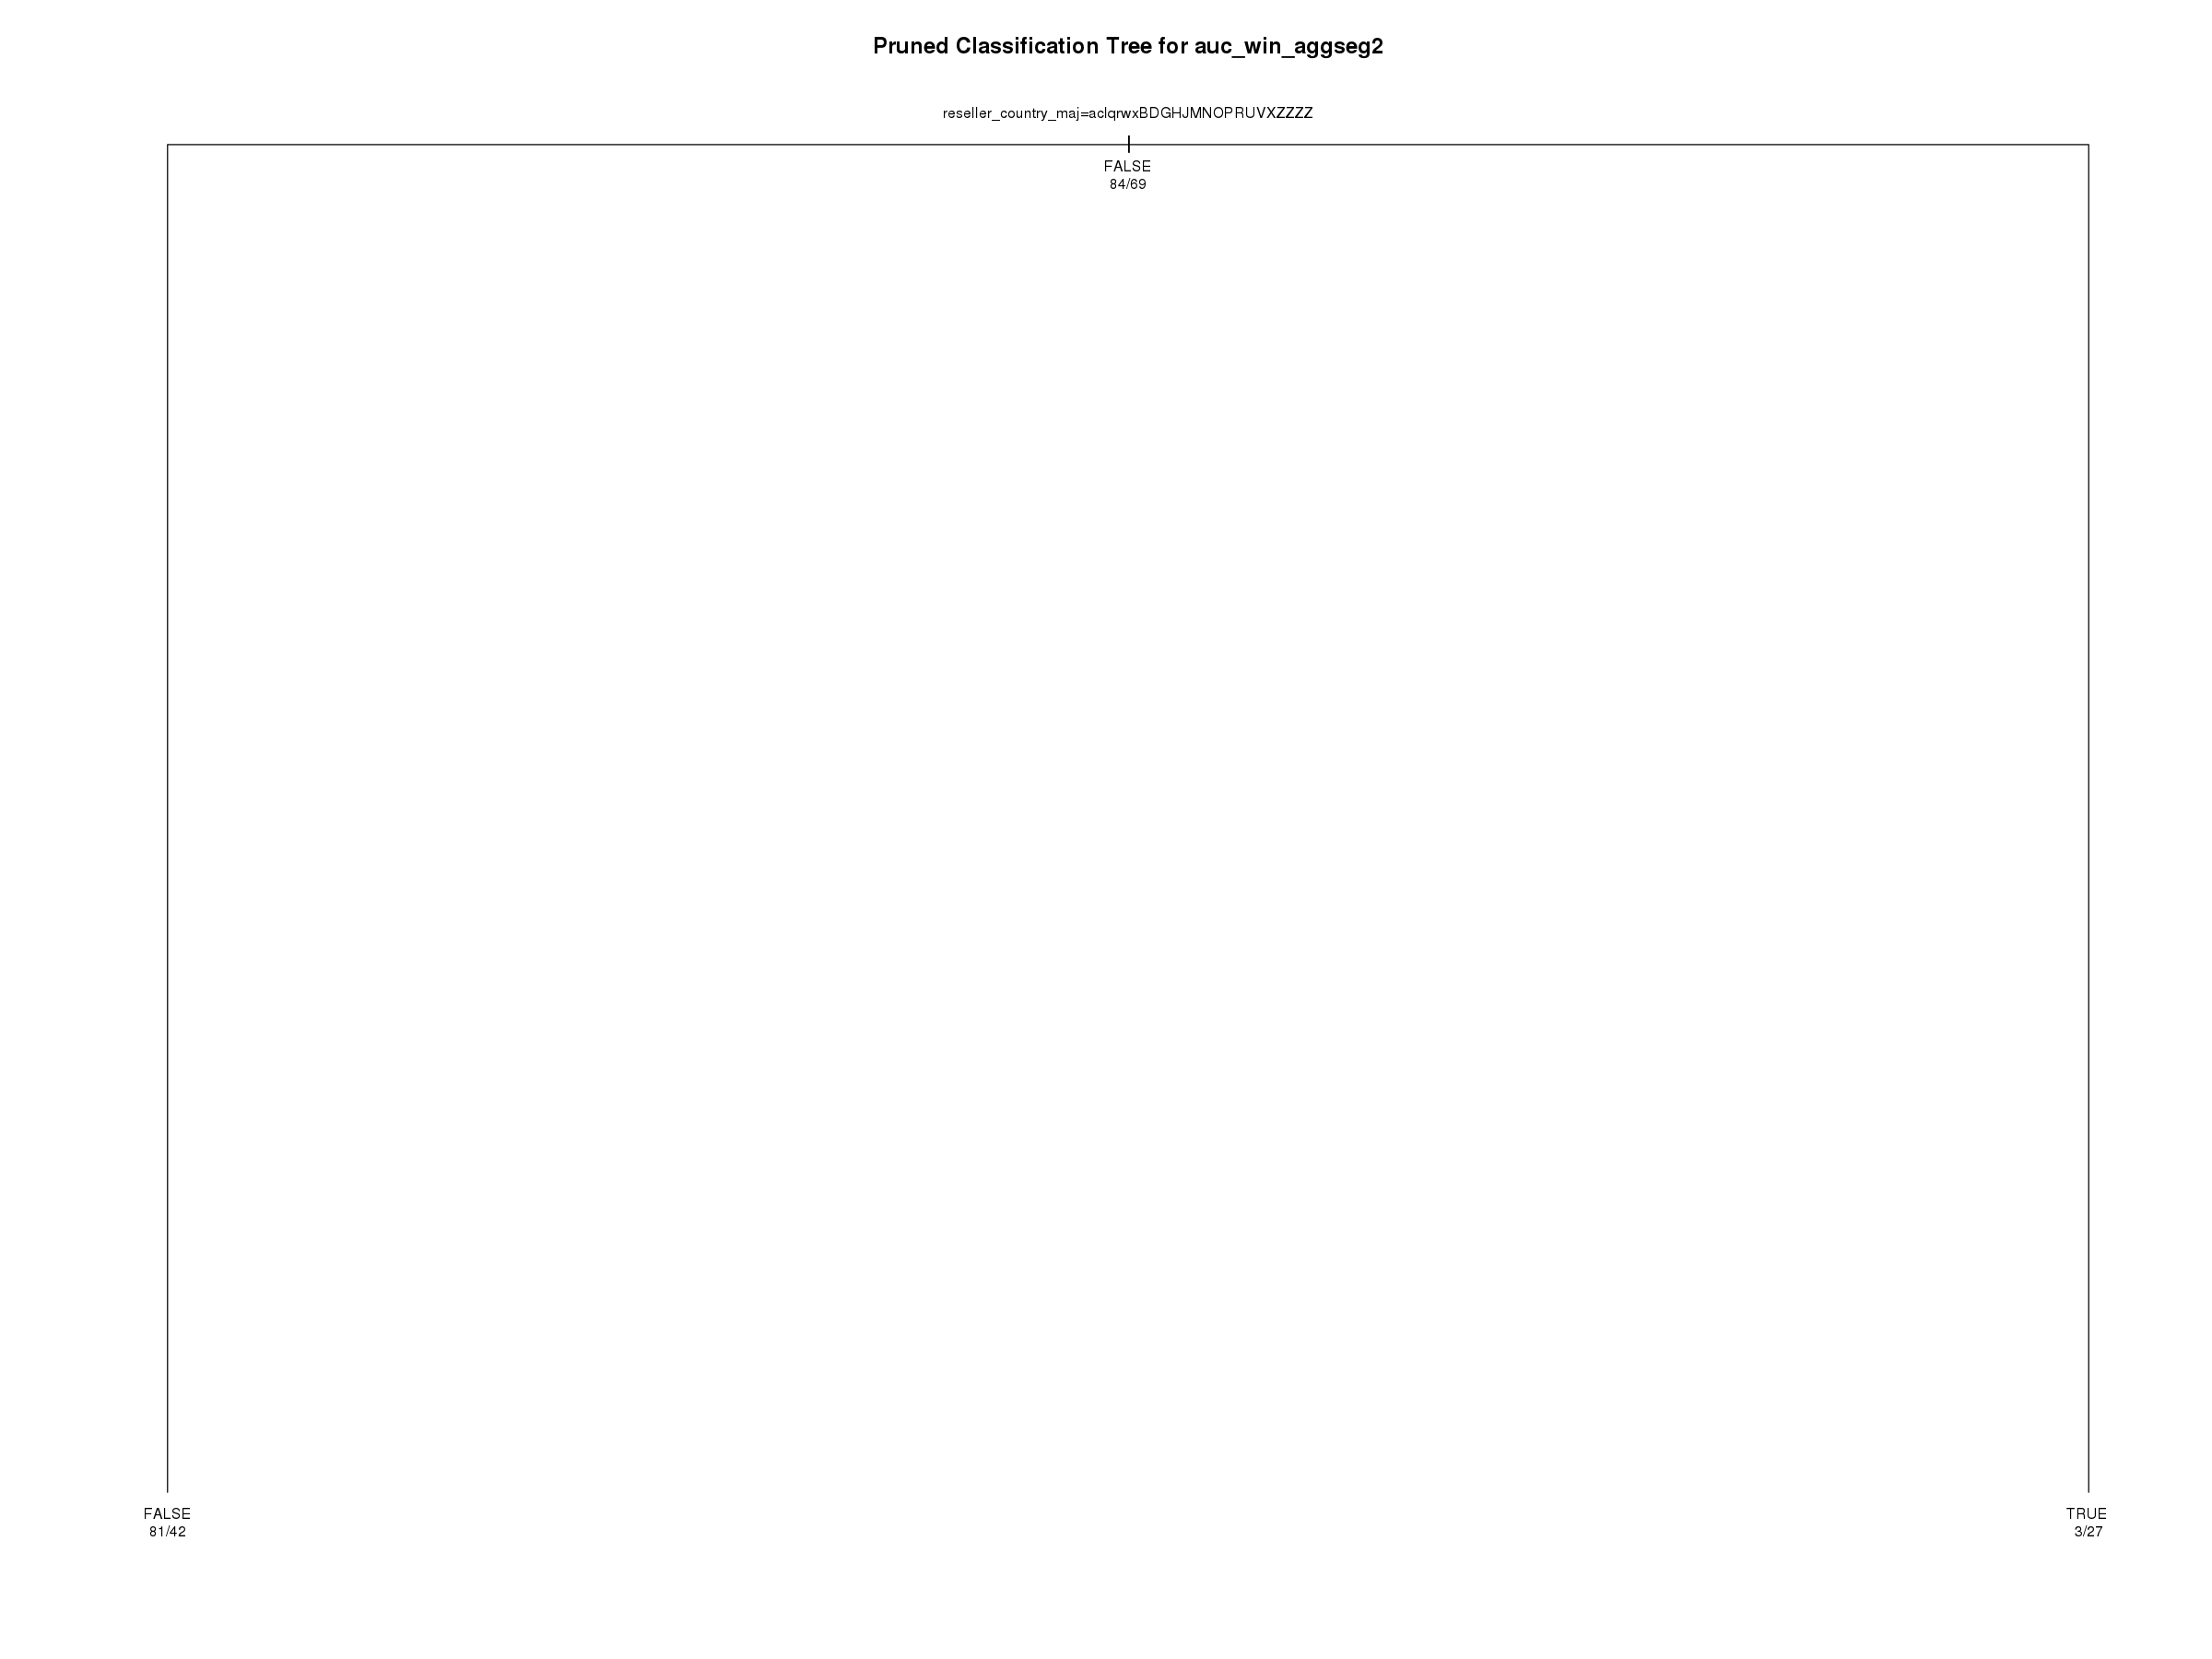

In [127]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree for auc_win_aggseg2")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


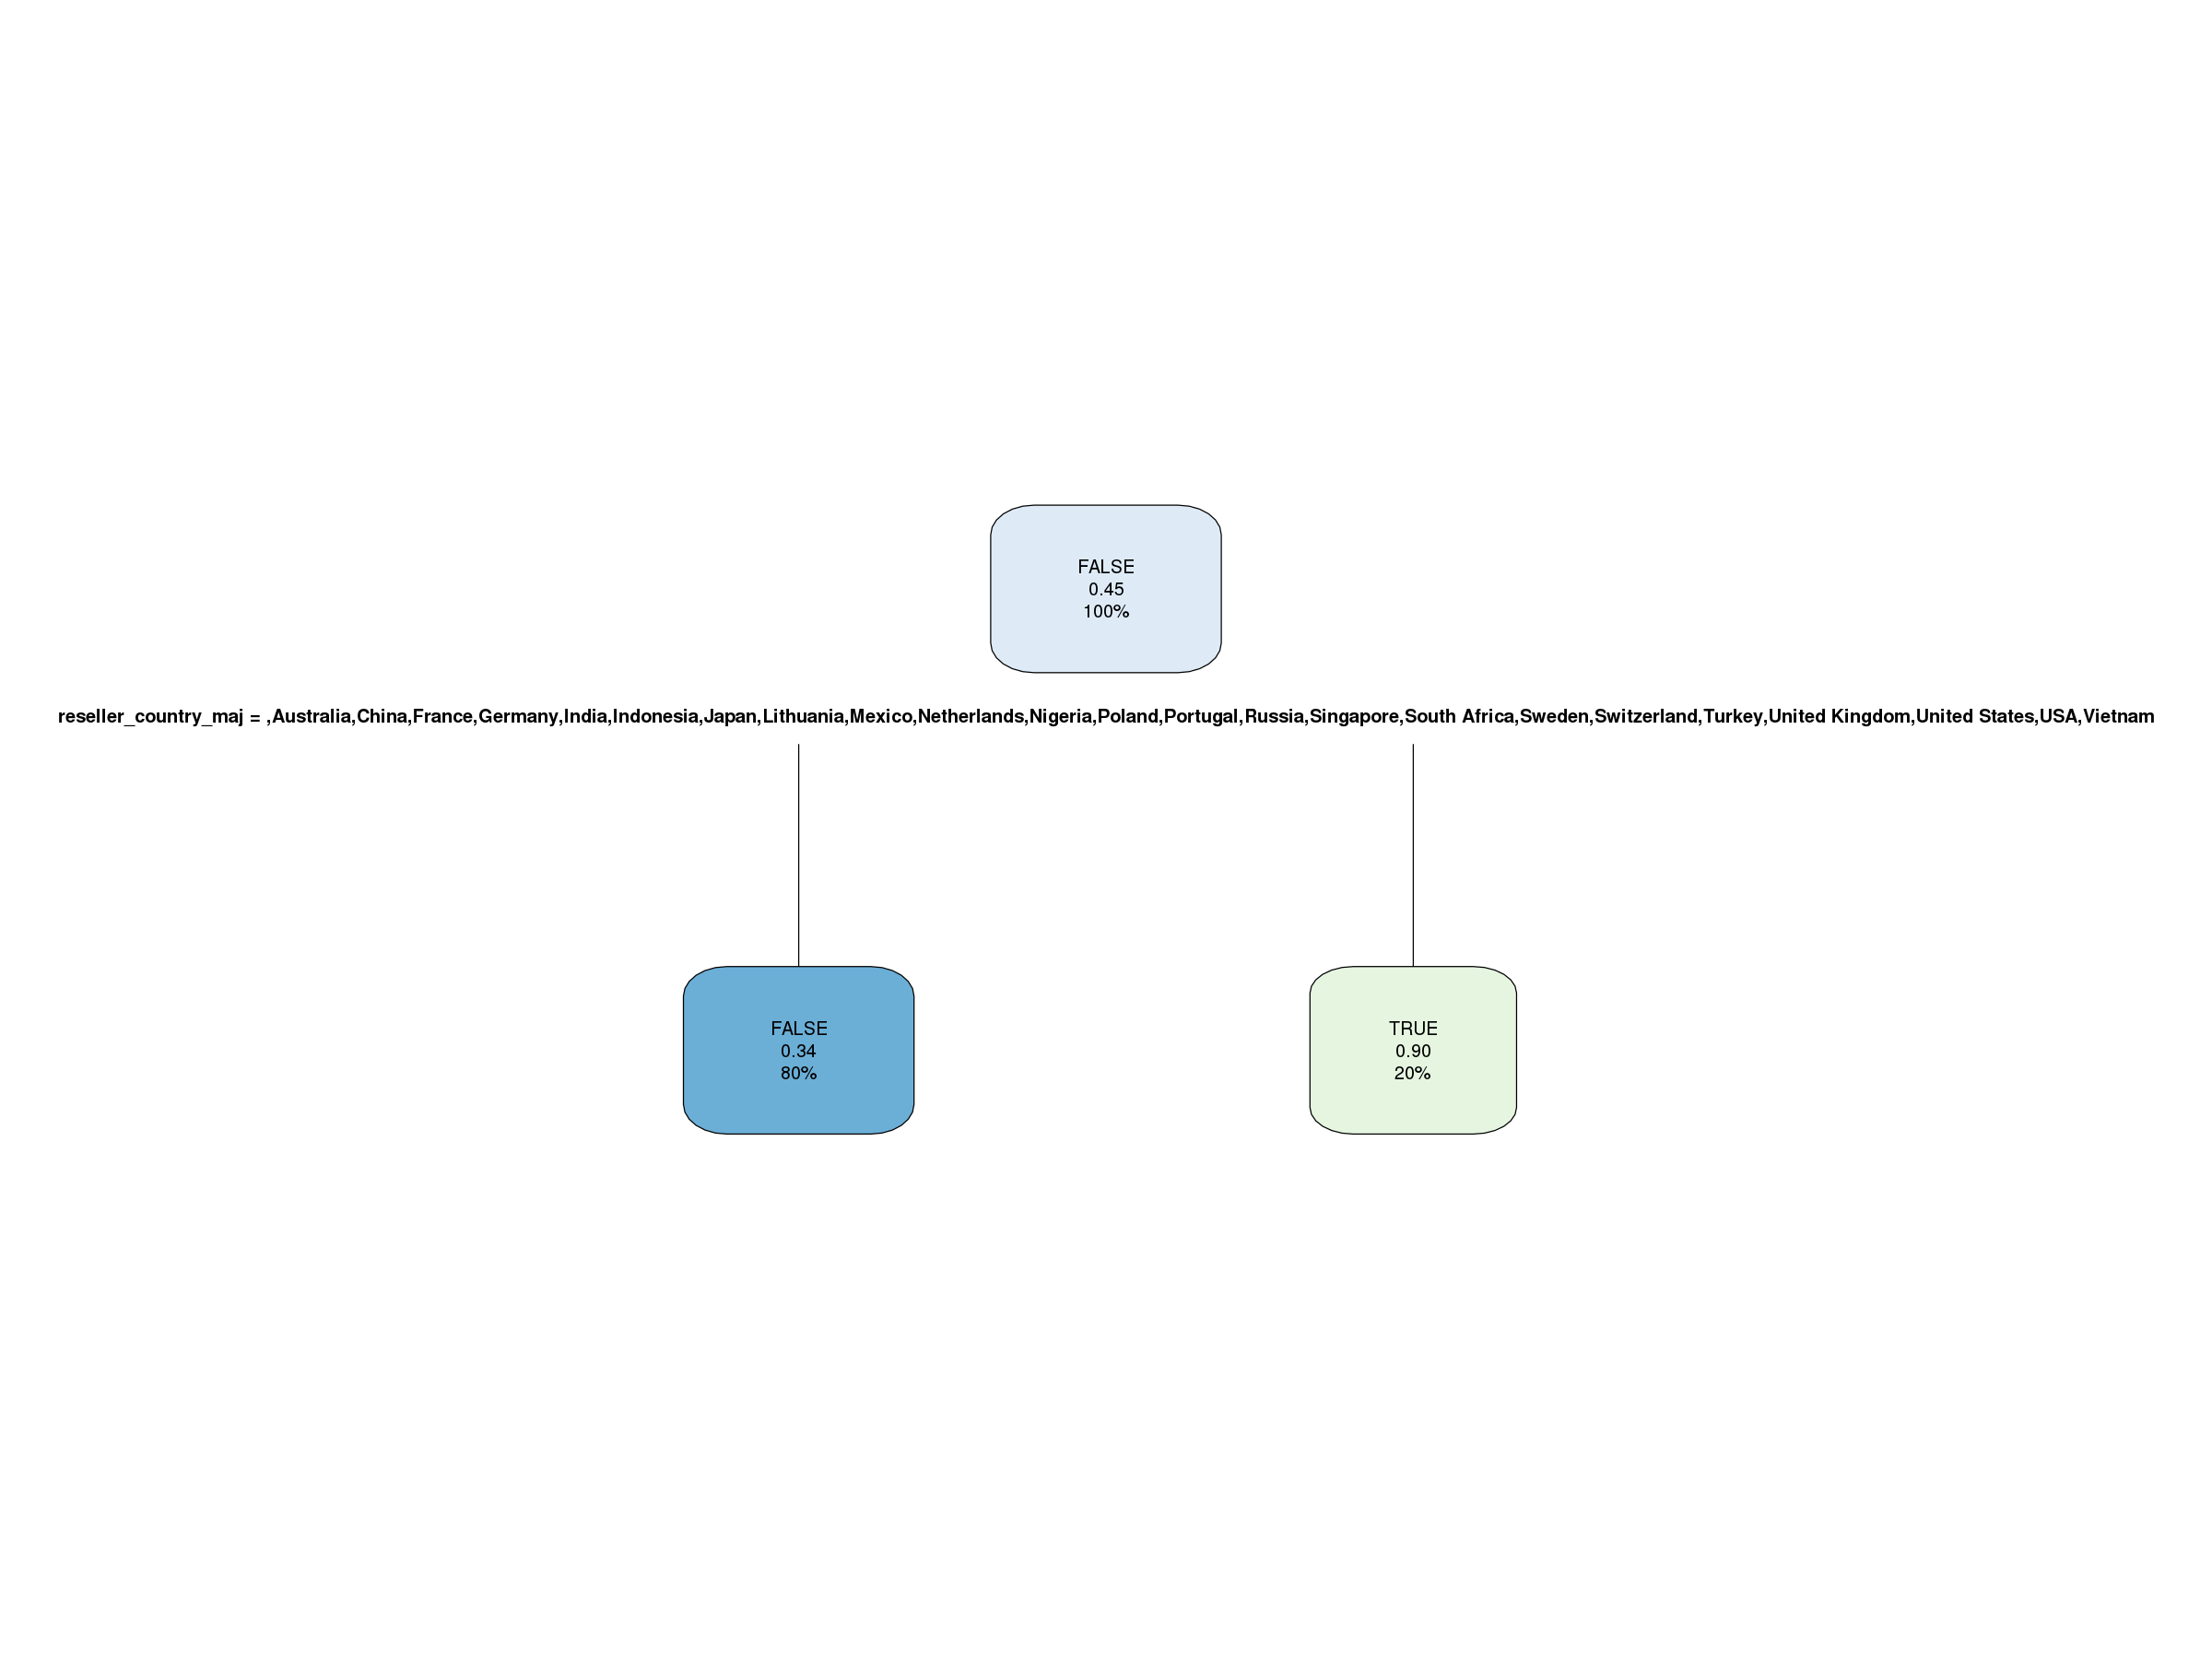

In [128]:
rpart.plot(pfit)

In [129]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    18    5
     TRUE     19    2
                                          
               Accuracy : 0.4545          
                 95% CI : (0.3039, 0.6115)
    No Information Rate : 0.8409          
    P-Value [Acc > NIR] : 1.000000        
                                          
                  Kappa : -0.1258         
                                          
 Mcnemar's Test P-Value : 0.007963        
                                          
            Sensitivity : 0.28571         
            Specificity : 0.48649         
         Pos Pred Value : 0.09524         
         Neg Pred Value : 0.78261         
             Prevalence : 0.15909         
         Detection Rate : 0.04545         
   Detection Prevalence : 0.47727         
      Balanced Accuracy : 0.38610         
                                          
       'Positive' Class : TRUE            
                     

In [130]:
# unpruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    11   12
     TRUE     14    7
                                          
               Accuracy : 0.4091          
                 95% CI : (0.2634, 0.5675)
    No Information Rate : 0.5682          
    P-Value [Acc > NIR] : 0.9885          
                                          
                  Kappa : -0.1892         
                                          
 Mcnemar's Test P-Value : 0.8445          
                                          
            Sensitivity : 0.3684          
            Specificity : 0.4400          
         Pos Pred Value : 0.3333          
         Neg Pred Value : 0.4783          
             Prevalence : 0.4318          
         Detection Rate : 0.1591          
   Detection Prevalence : 0.4773          
      Balanced Accuracy : 0.4042          
                                          
       'Positive' Class : TRUE            
                     

## Decision Tree
### l10_win_seg2seg2

In [131]:
names(train)

[1] "auc_win_aggseg2"      "l10_win_aggseg2"      "auc_win_seg2seg2"    
 [4] "l10_win_seg2seg2"     "count"                "ren_prp"             
 [7] "tld_rat"              "reseller_country_maj" "region_maj"          
[10] "daydom_min"           "daydom_max"           "daydom_mean"         
[13] "daydom_rng"           "daydom_std"           "daydom_skew"         
[16] "daydom_kurt"          "sldlen_min"           "sldlen_max"          
[19] "sldlen_mean"          "sldlen_rng"           "sldlen_std"          
[22] "sldlen_skew"          "sldlen_kurt"          "gibbs_min"           
[25] "gibbs_max"            "gibbs_mean"           "gibbs_rng"           
[28] "gibbs_std"            "gibbs_skew"           "gibbs_kurt"          
[31] "pdcnt_min"            "pdcnt_max"            "pdcnt_mean"          
[34] "pdcnt_rng"            "pdcnt_std"            "pdcnt_skew"          
[37] "pdcnt_kurt"           "rarpt_min"            "rarpt_max"           
[40] "rarpt_mean"           "rarpt_rng"            "rarpt_std"           
[43] "rarpt_skew"           "rarpt_kurt"

In [133]:
fit <- rpart(l10_win_seg2seg2 ~ .,
             method="class", 
             data=subset(train, select = -c(auc_win_aggseg2,l10_win_aggseg2,auc_win_seg2seg2) ))

In [134]:
printcp(fit) 


Classification tree:
rpart(formula = l10_win_seg2seg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    l10_win_aggseg2, auc_win_seg2seg2)), method = "class")

Variables actually used in tree construction:
[1] daydom_skew          ren_prp              reseller_country_maj
[4] sldlen_max          

Root node error: 48/141 = 0.34043

n=141 (106 observations deleted due to missingness)

        CP nsplit rel error xerror    xstd
1 0.156250      0   1.00000 1.0000 0.11722
2 0.104167      2   0.68750 1.2500 0.12231
3 0.041667      3   0.58333 1.1875 0.12140
4 0.010000      4   0.54167 1.2708 0.12256


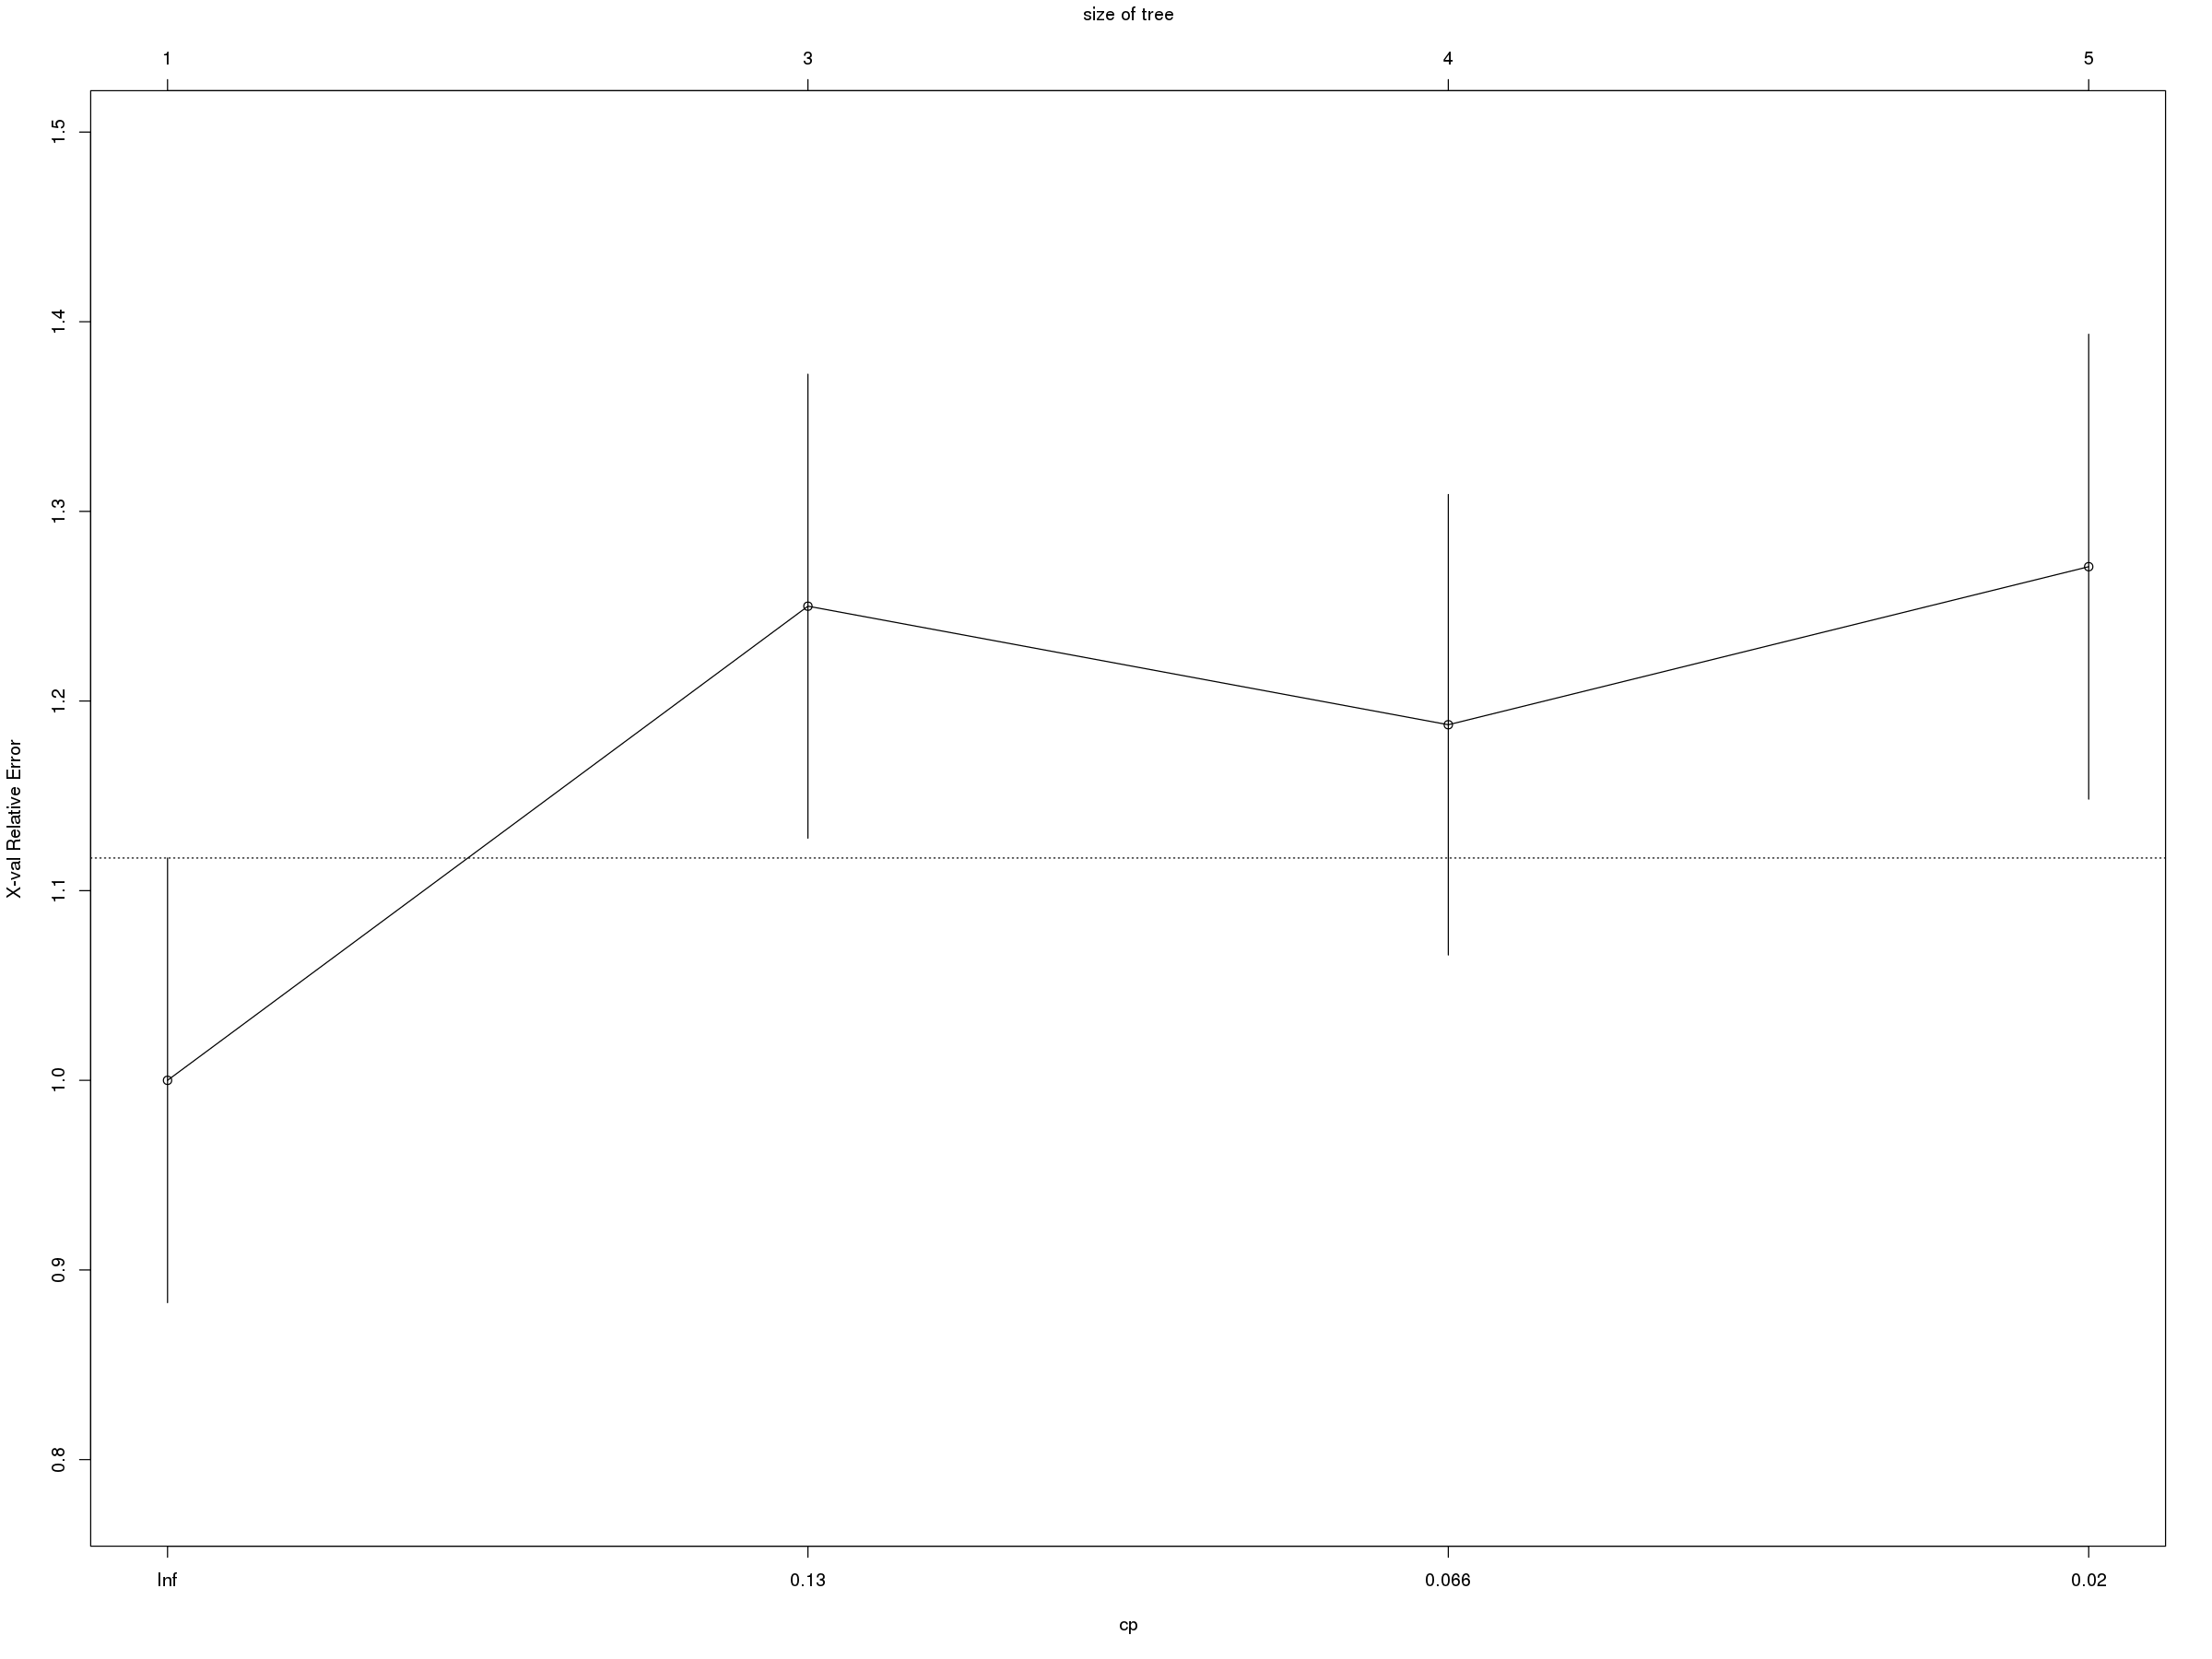

In [135]:
plotcp(fit) 

In [136]:
summary(fit)

Call:
rpart(formula = l10_win_seg2seg2 ~ ., data = subset(train, select = -c(auc_win_aggseg2, 
    l10_win_aggseg2, auc_win_seg2seg2)), method = "class")
  n=141 (106 observations deleted due to missingness)

          CP nsplit rel error   xerror      xstd
1 0.15625000      0 1.0000000 1.000000 0.1172226
2 0.10416667      2 0.6875000 1.250000 0.1223115
3 0.04166667      3 0.5833333 1.187500 0.1214021
4 0.01000000      4 0.5416667 1.270833 0.1225629

Variable importance
reseller_country_maj                count              tld_rat 
                  24                    9                    9 
         daydom_skew              ren_prp          daydom_kurt 
                   8                    7                    7 
          sldlen_max           sldlen_rng          sldlen_kurt 
                   6                    5                    5 
           gibbs_min          daydom_mean            gibbs_rng 
                   5                    4                    3 
          sld

Warning message in labels.rpart(x, minlength = minlength):
“more than 52 levels in a predicting factor, truncated for printout”


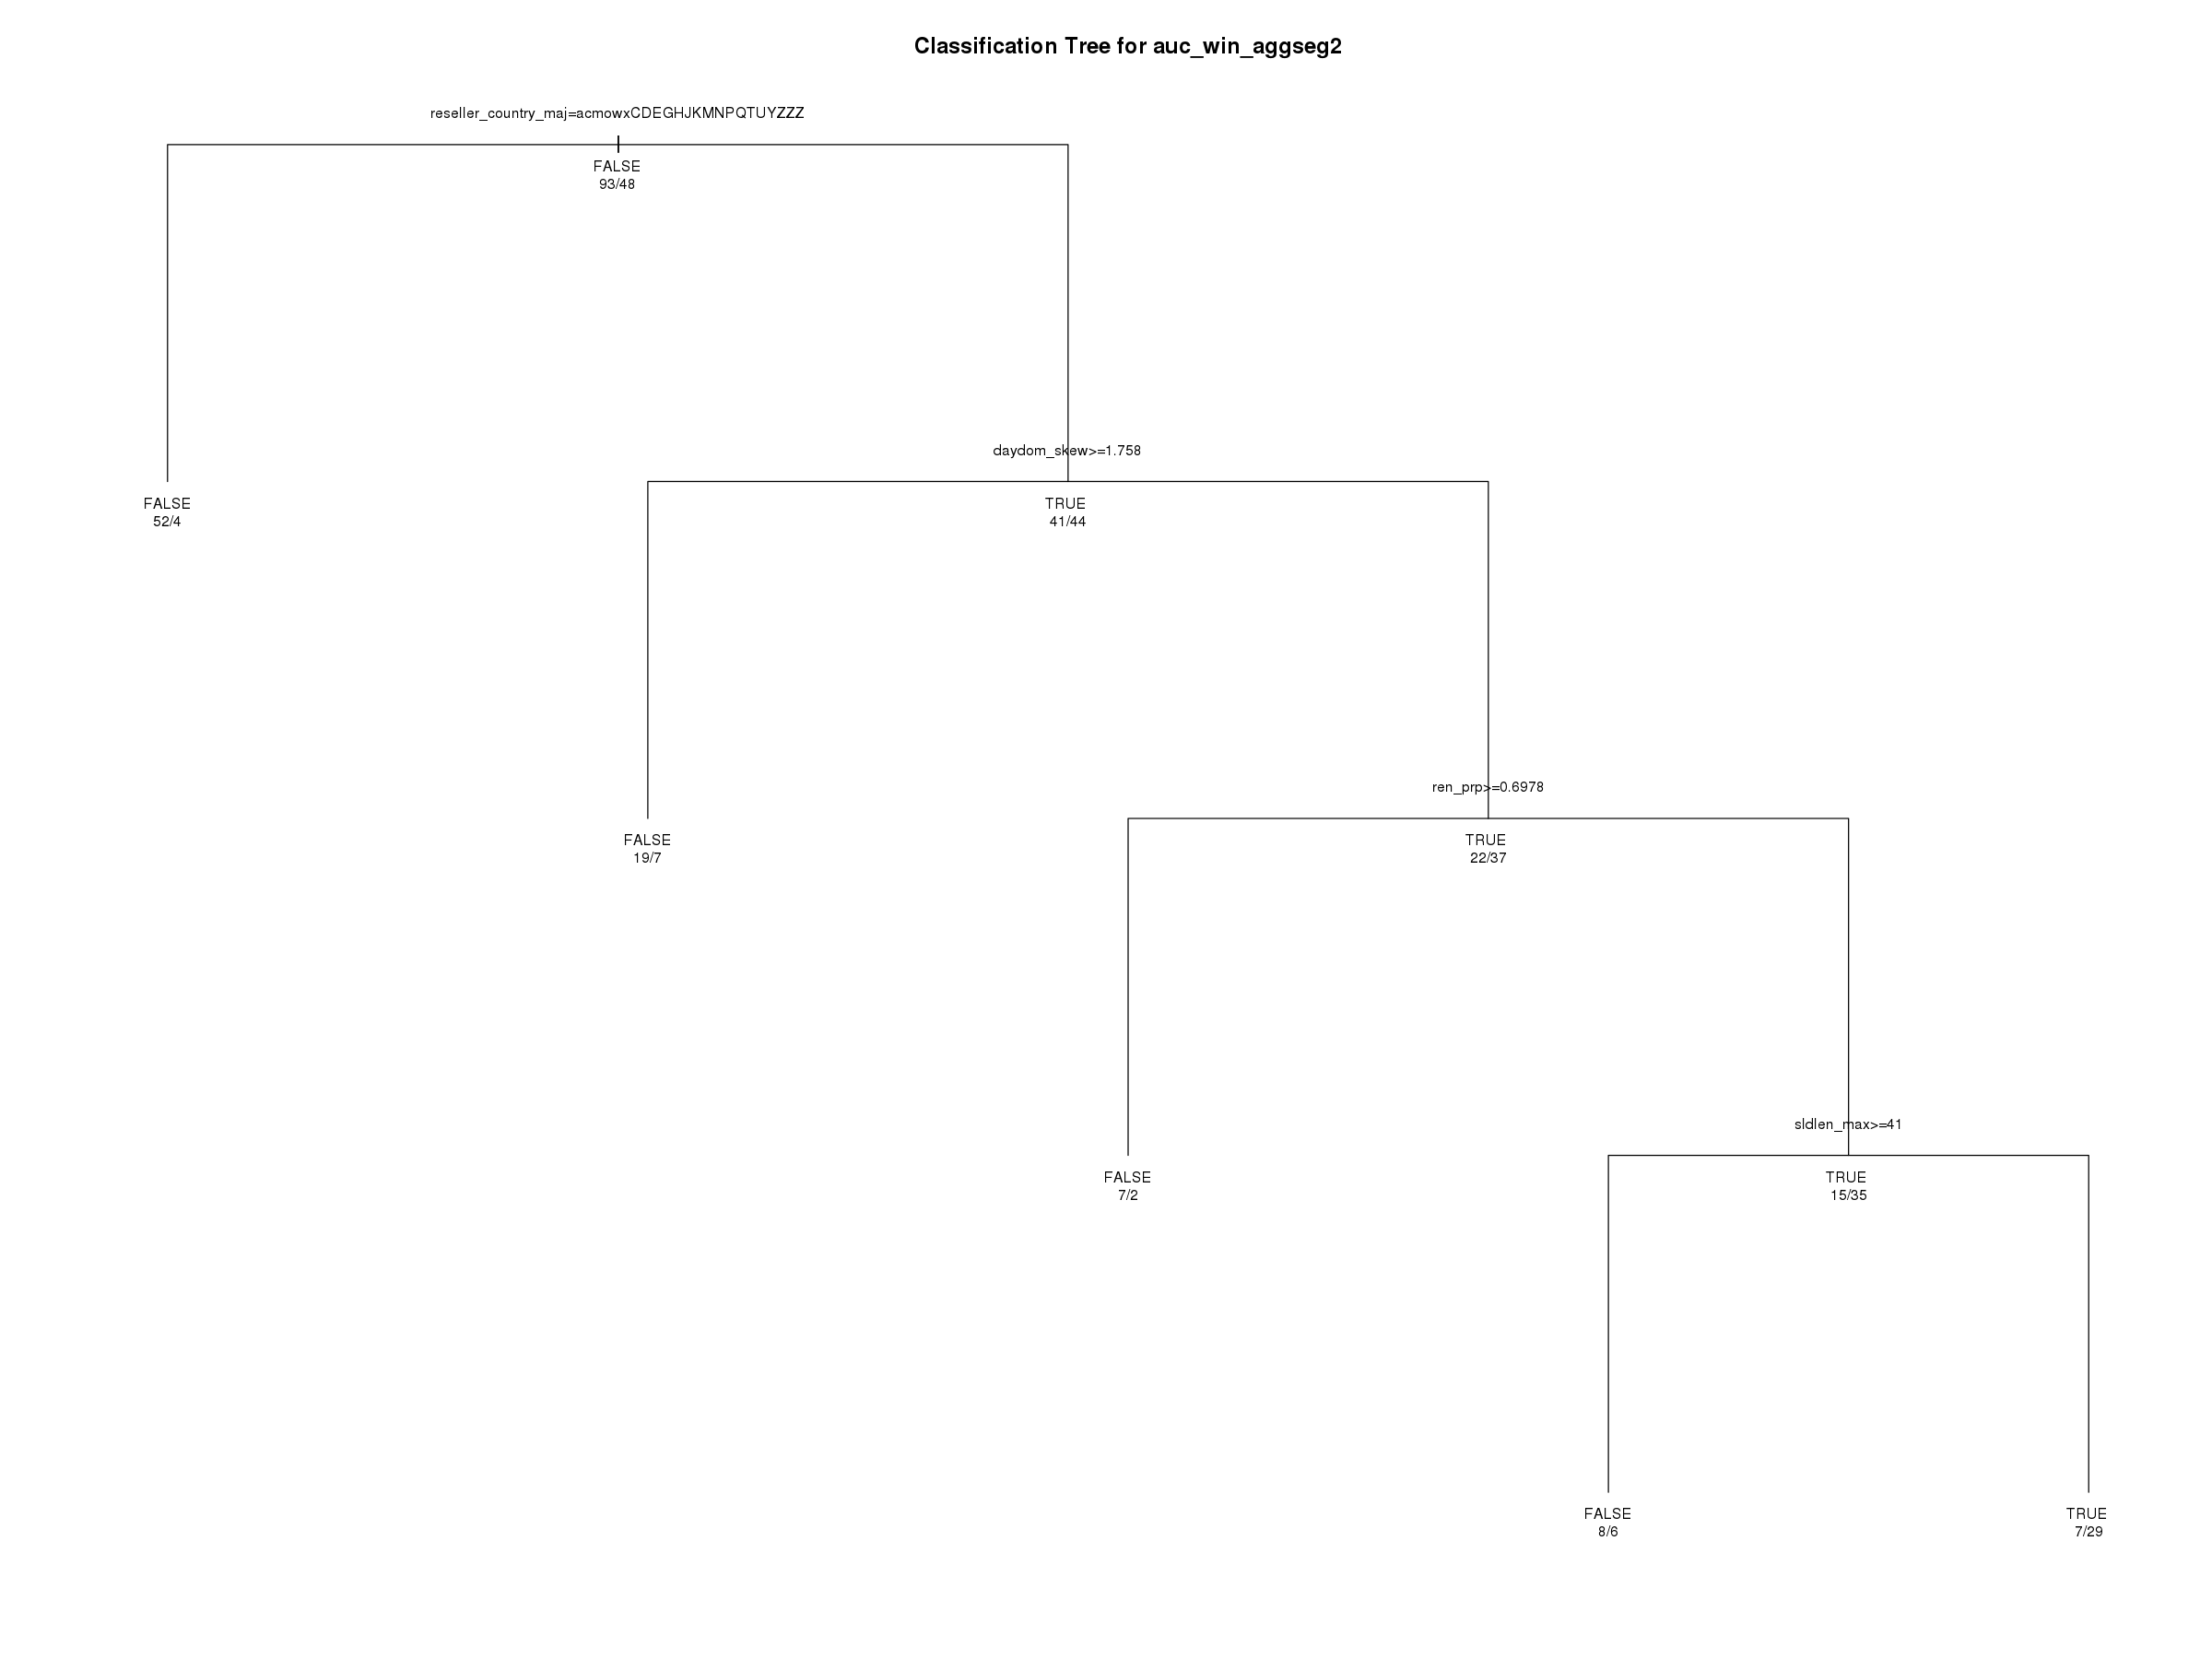

In [137]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for auc_win_aggseg2")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

In [138]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree for auc_win_aggseg2")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

ERROR: Error in plot.rpart(pfit, uniform = TRUE, main = "Pruned Classification Tree for auc_win_aggseg2"): fit is not a tree, just a root


Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


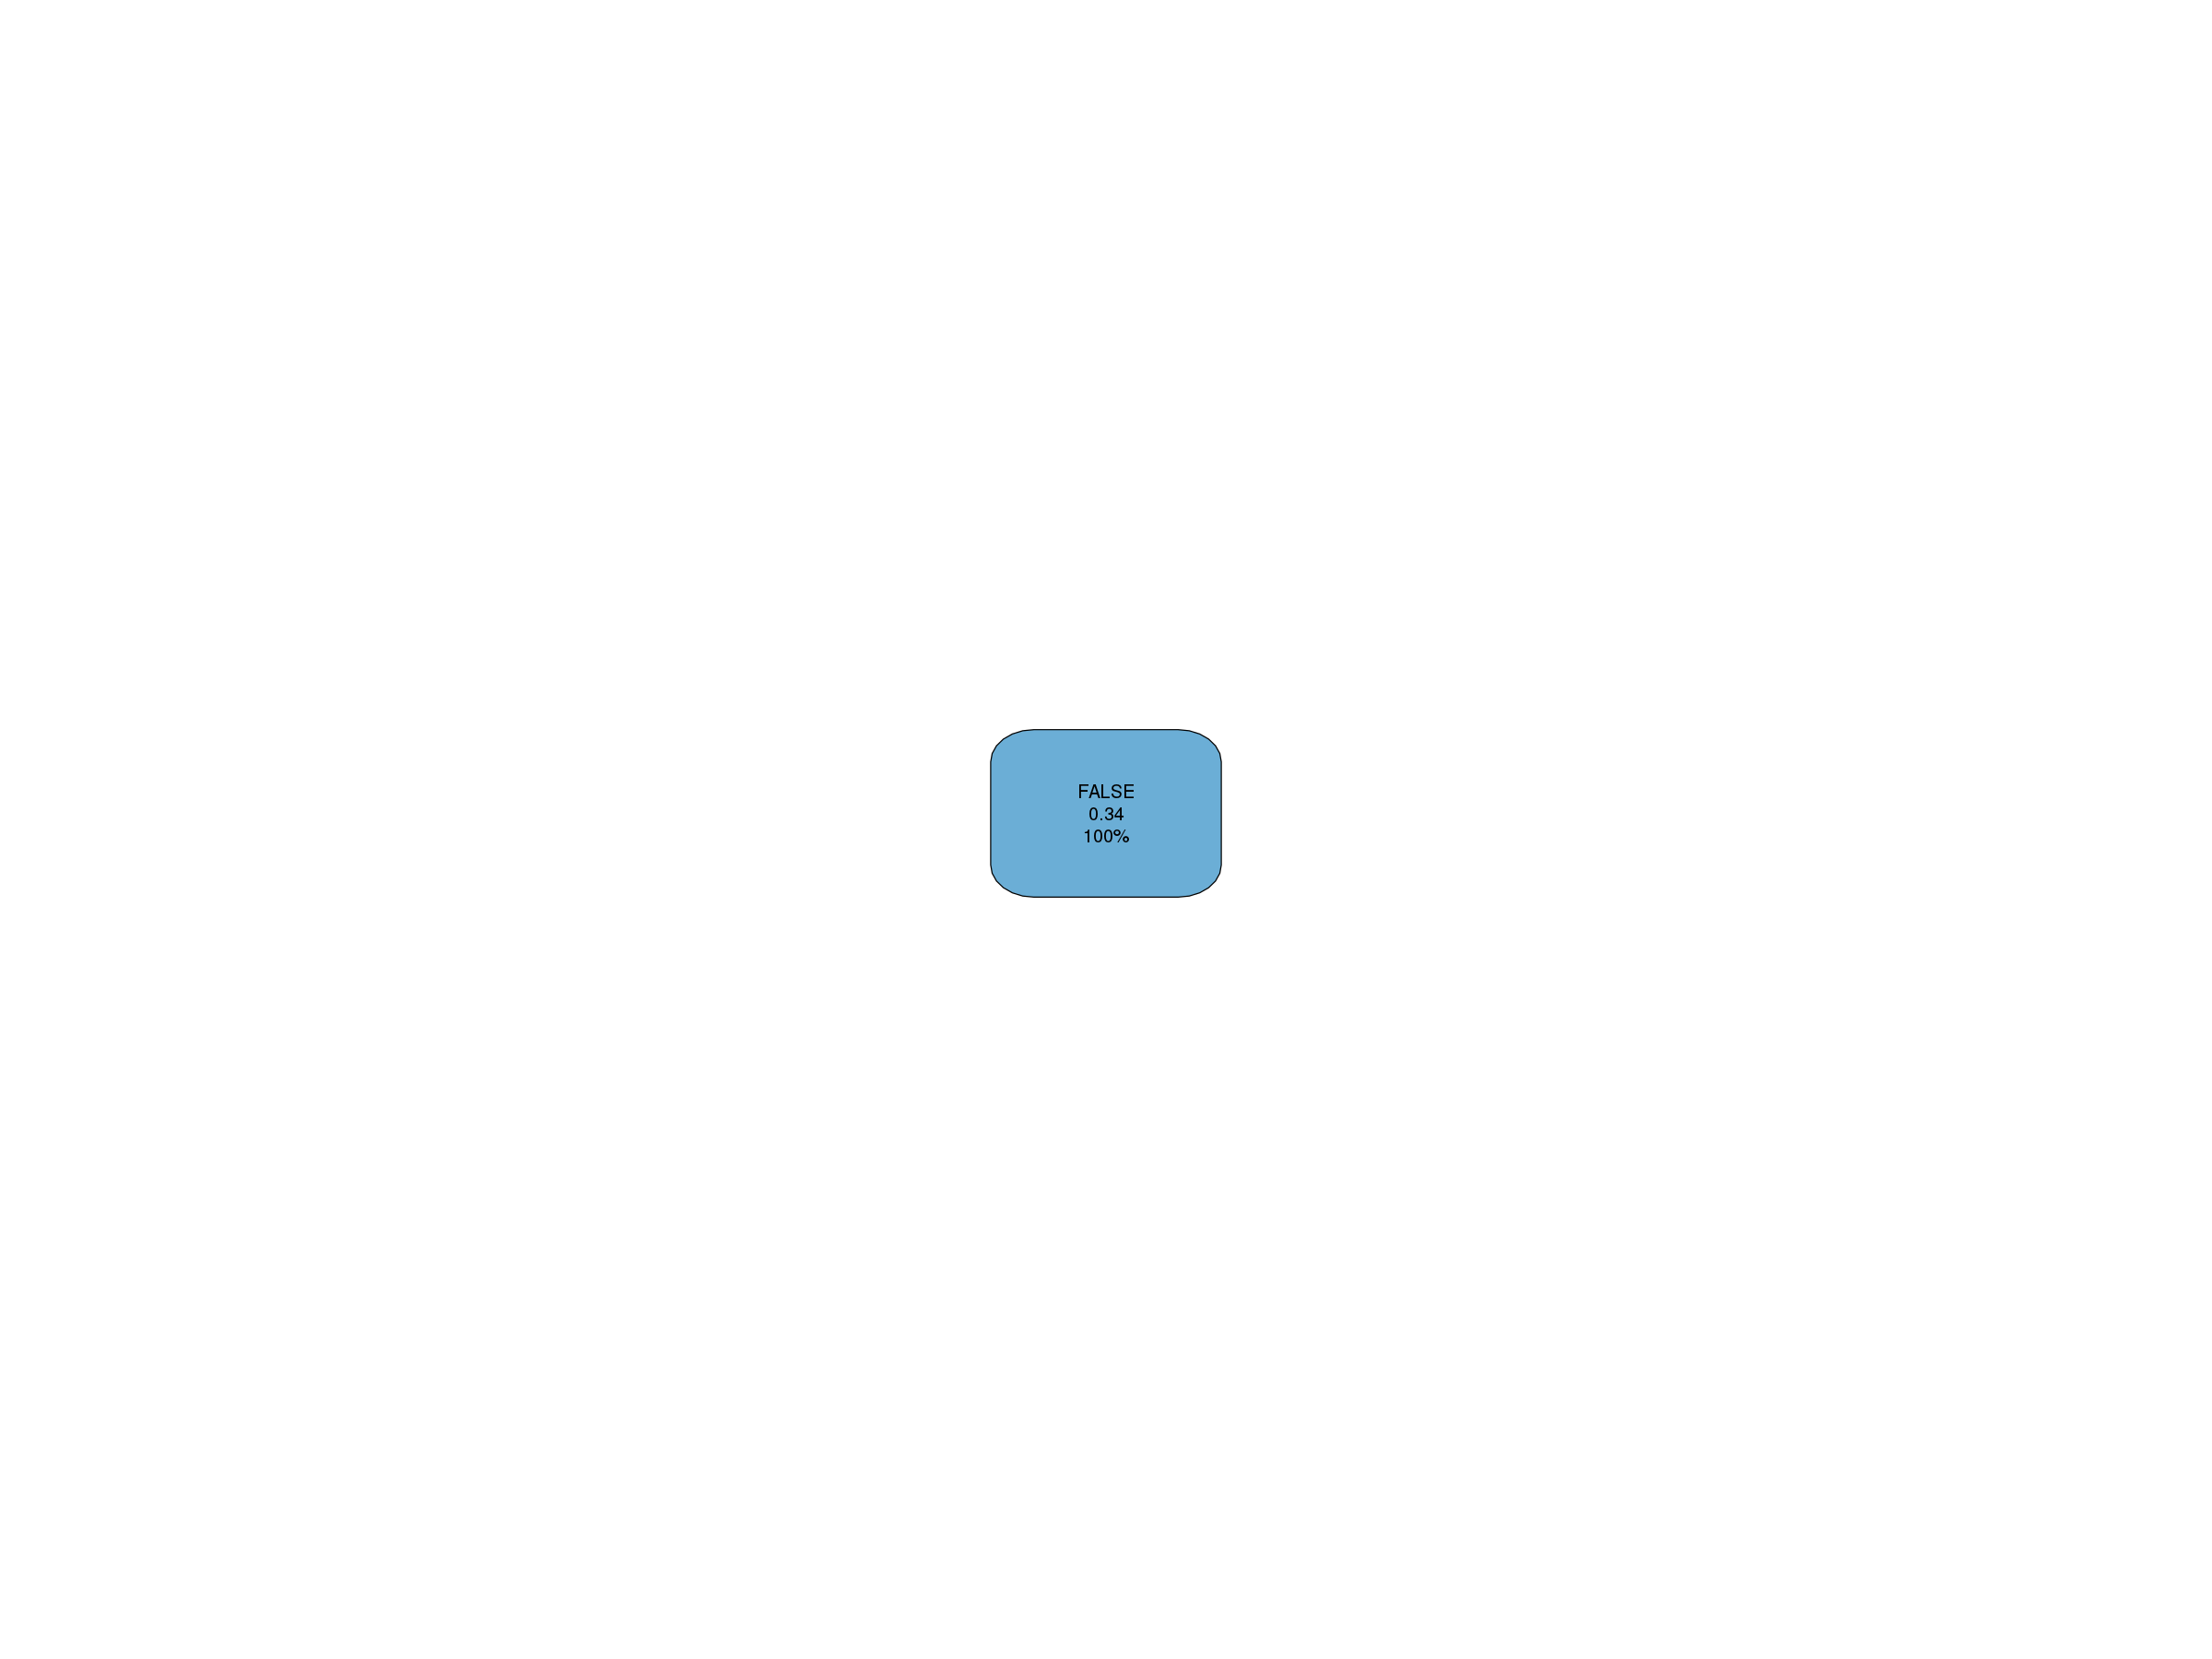

In [139]:
rpart.plot(pfit)

In [140]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")), positive='TRUE')

ERROR: Error in confusionMatrix.default(factor(test[["auc_win_aggseg2"]]), factor(predict(pfit, : the data cannot have more levels than the reference


In [141]:
# unpruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")), positive='TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    13   10
     TRUE     12    9
                                          
               Accuracy : 0.5             
                 95% CI : (0.3456, 0.6544)
    No Information Rate : 0.5682          
    P-Value [Acc > NIR] : 0.8565          
                                          
                  Kappa : -0.0062         
                                          
 Mcnemar's Test P-Value : 0.8312          
                                          
            Sensitivity : 0.4737          
            Specificity : 0.5200          
         Pos Pred Value : 0.4286          
         Neg Pred Value : 0.5652          
             Prevalence : 0.4318          
         Detection Rate : 0.2045          
   Detection Prevalence : 0.4773          
      Balanced Accuracy : 0.4968          
                                          
       'Positive' Class : TRUE            
                     